<a href="https://colab.research.google.com/github/Shruti-Raj-Vansh-Singh/Speech-Emotion-detector-2D/blob/master/Speech_Emotion_Detection_Spectrogram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import os
import sys
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report 
from sklearn.model_selection import train_test_split

#for playing the audios
from IPython.display import Audio

import keras  
from keras.models import Model
from keras.layers import Conv2D, Dense, MaxPool2D, Flatten, BatchNormalization, Dropout, Activation,Input,Concatenate, Input
from keras.callbacks import ReduceLROnPlateau
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
  warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category = DeprecationWarning)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [ ]:
%cd /content/
!mkdir RAVDESS
%cd RAVDESS
from google.colab import drive
drive.mount('/content/drive')
!unzip '/content/drive/My Drive/dataset/RAVDESS.zip'

/content
/content/RAVDESS
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
Archive:  /content/drive/My Drive/dataset/RAVDESS.zip
   creating: Actor_01/
  inflating: Actor_01/03-01-01-01-01-01-01.wav  
  inflating: Actor_01/03-01-01-01-01-02-01.wav  
  inflating: Actor_01/03-01-01-01-02-01-01.wav  
  inflating: Actor_01/03-01-01-01-02-02-01.wav  
  inflating: Actor_01/03-01-02-01-01-01-01.wav  
  inflating: Actor_01/03-01-02-01-01-02-01.wav  
  inflating: Actor_01/03-01-02-01-02-01-01.wav  
  inflating: Actor

In [ ]:
%cd 
ravdess_directory_list = os.listdir(path='/content/RAVDESS')
print(ravdess_directory_list)
file_emotion = []
file_path =[]

#since we have 20 different actors we need to extract files for each actor
for dir in ravdess_directory_list:
  actor = os.listdir(path='/content/RAVDESS/' + dir)
  for files in actor:
    part = files.split('.'[0])
    part = files.split('-')
    #the third part of the file represents the emotion associated with that file
    file_emotion.append(int(part[2]))
    file_path.append('/content/RAVDESS/' + dir + '/' + files)

emotion_df = pd.DataFrame(file_emotion,columns = ['Emotions'])
    
#dataframe for the path of files
path_df = pd.DataFrame(file_path, columns=['Paths'])
ravdess_df = pd.concat([emotion_df, path_df], axis=1)

#changing the interger value to true emotions 
ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
ravdess_df.head()

/root
['Actor_24', 'Actor_13', 'Actor_12', 'Actor_09', 'Actor_16', 'Actor_23', 'Actor_14', 'Actor_05', 'Actor_10', 'Actor_21', 'Actor_04', 'Actor_07', 'Actor_08', 'Actor_20', 'Actor_19', 'Actor_03', 'Actor_06', 'Actor_02', 'Actor_18', 'Actor_11', 'Actor_01', 'Actor_22', 'Actor_15', 'Actor_17']


Emotions                                              Paths
0      fear  /content/RAVDESS/Actor_24/03-01-06-01-01-01-24...
1  surprise  /content/RAVDESS/Actor_24/03-01-08-02-02-02-24...
2   disgust  /content/RAVDESS/Actor_24/03-01-07-01-01-02-24...
3     angry  /content/RAVDESS/Actor_24/03-01-05-02-02-01-24...
4      fear  /content/RAVDESS/Actor_24/03-01-06-02-01-01-24...

In [ ]:
#creating a csv file from our dataset
%cd /content
ravdess_df.to_csv('ravdess.csv',index=False)
ravdess_df.head()

/content


Emotions                                              Paths
0      fear  /content/RAVDESS/Actor_24/03-01-06-01-01-01-24...
1  surprise  /content/RAVDESS/Actor_24/03-01-08-02-02-02-24...
2   disgust  /content/RAVDESS/Actor_24/03-01-07-01-01-02-24...
3     angry  /content/RAVDESS/Actor_24/03-01-05-02-02-01-24...
4      fear  /content/RAVDESS/Actor_24/03-01-06-02-01-01-24...

## DATA VISUALIZATION AND EXPLORATION


#### Ploting the count of emotions
countplot to see the distribution of data

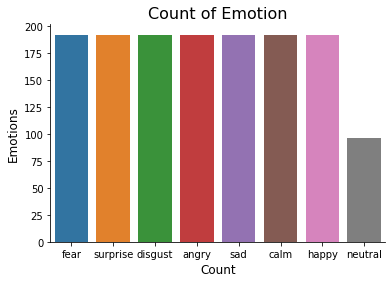

In [ ]:
plt.title('Count of Emotion', size=16)
sns.countplot(ravdess_df.Emotions)
plt.xlabel('Count', size=12)
plt.ylabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

#### Ploting the waveform of the audio signal
Wave plots help us know the loudness of the audio at a given time

In [ ]:
def create_waveform(data, sr, e):   #sr- sampling rate
  plt.figure(figsize=(15,5))
  plt.title("Waveplot for audio with "+e+' Emotion', size=15)
  librosa.display.waveplot(data, sr= sr)
  plt.show()  

#### Ploting a Spectrogram for the audio
A Spectrogram is a visual representation of the spectrum of frequnecies of sound or other signals as they vary with time. It's a representation of frequencies changing with respect to to time for given audio/mi=usic signal. 

In [ ]:
def create_spectrogram(data, sr, e):
  #stft funtions converts the data into short term fourier transform
  X =  librosa.stft(data)
  Xdb =  librosa.amplitude_to_db(abs(X))
  plt.figure(figsize=(12,8))
  plt.title('Specrtogram for audio with '+e+'Emotion', size=15)
  librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
  plt.colorbar()

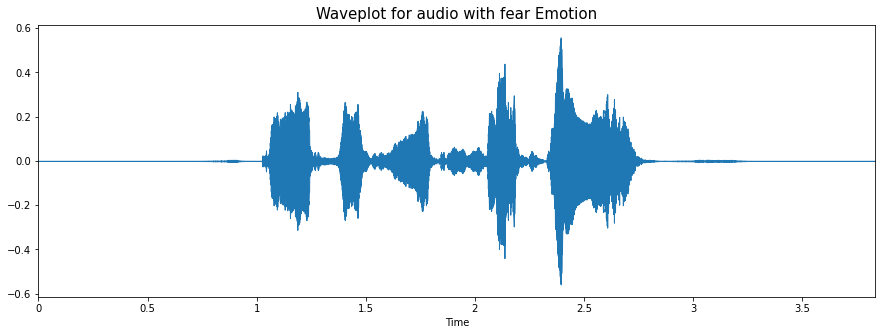

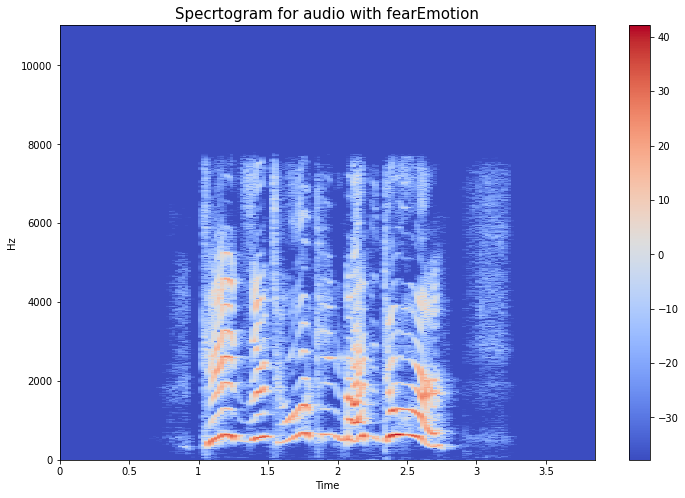

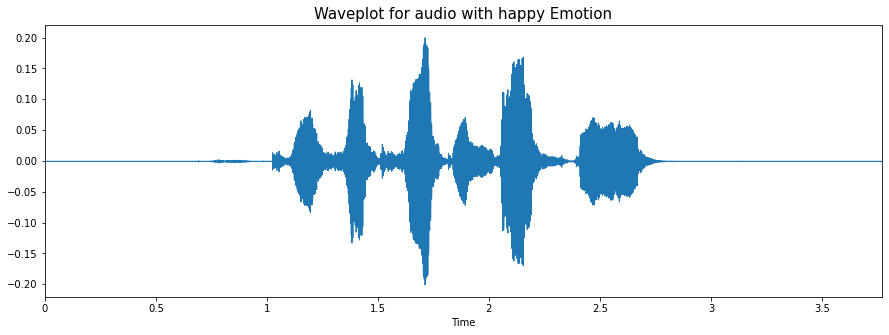

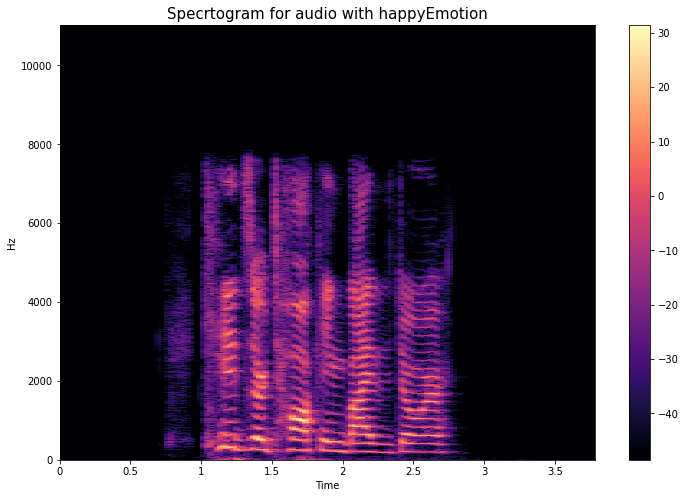

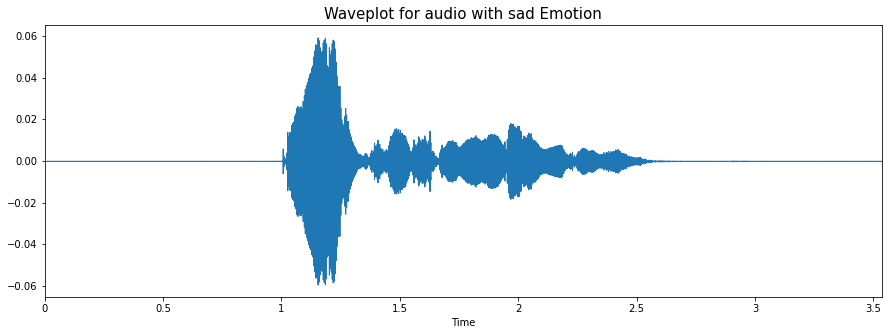

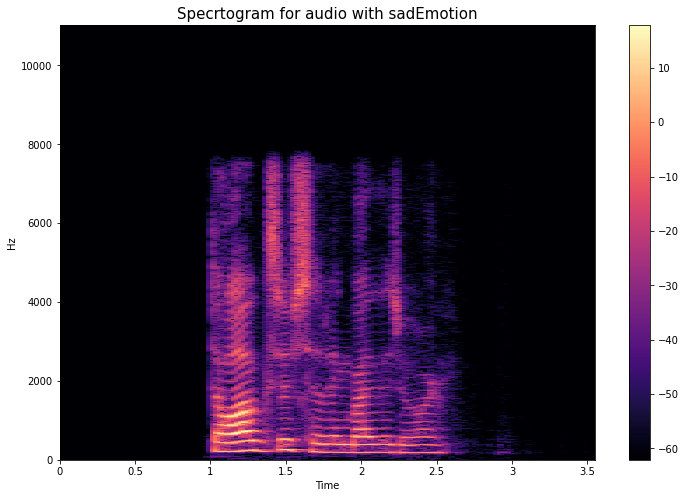

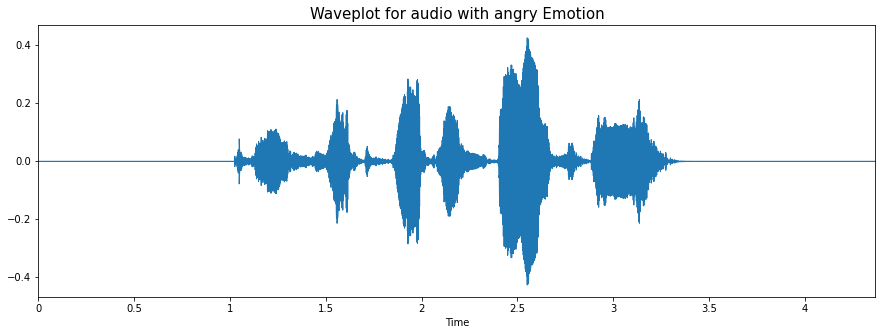

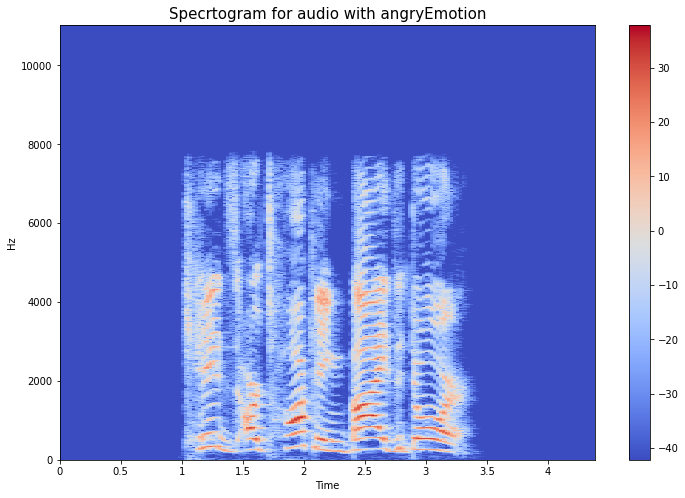

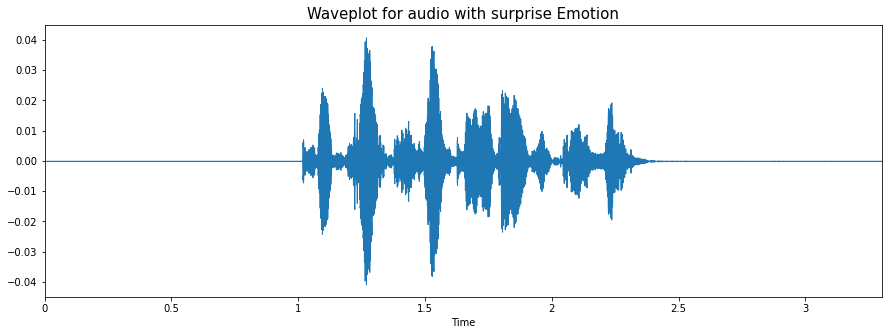

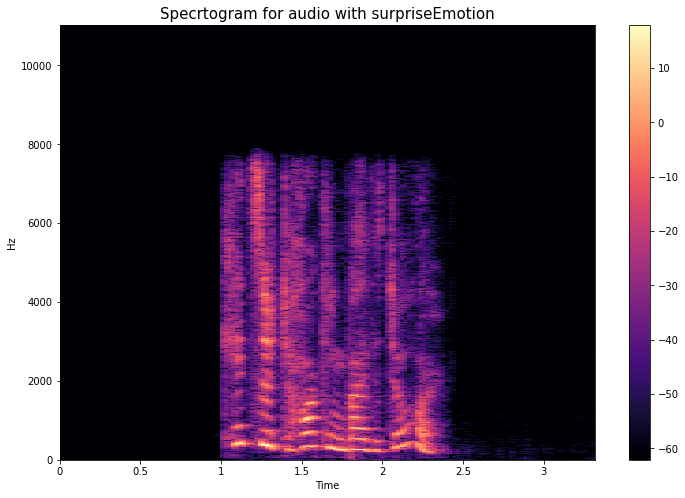

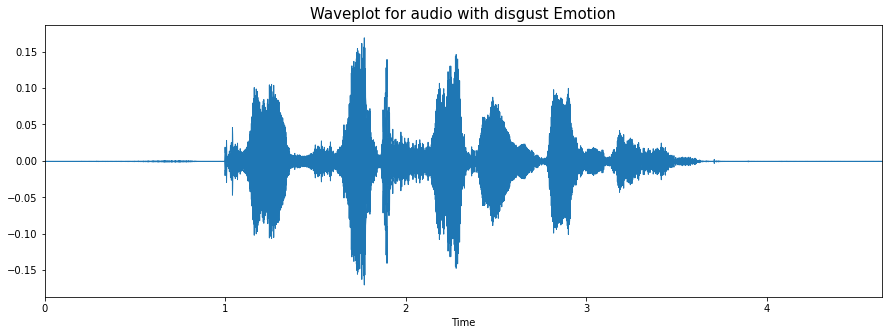

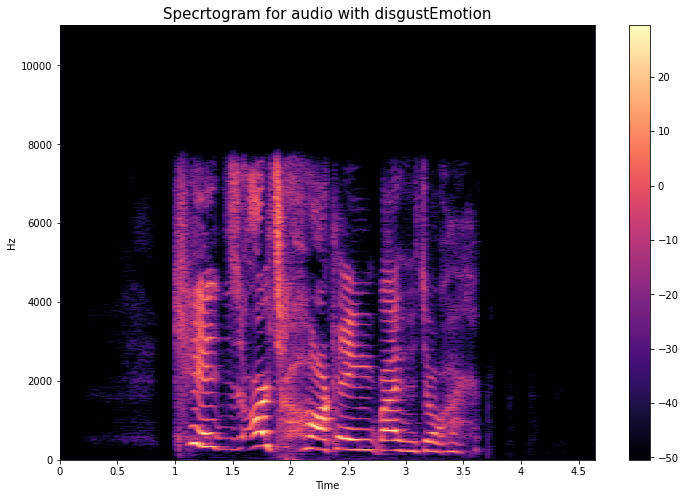

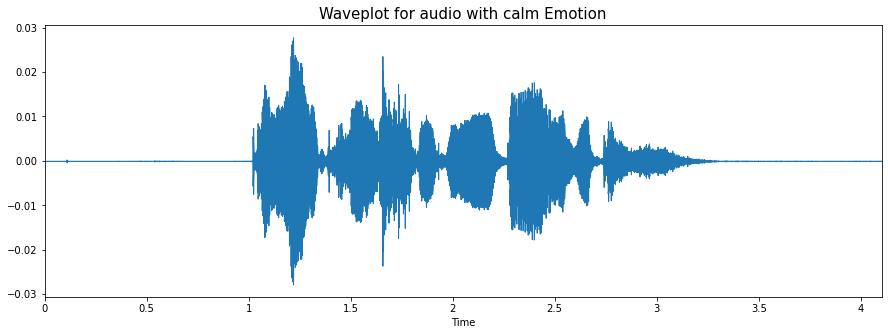

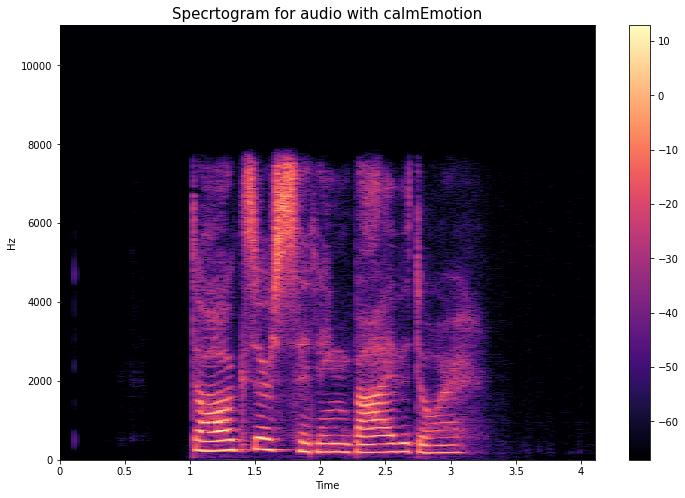

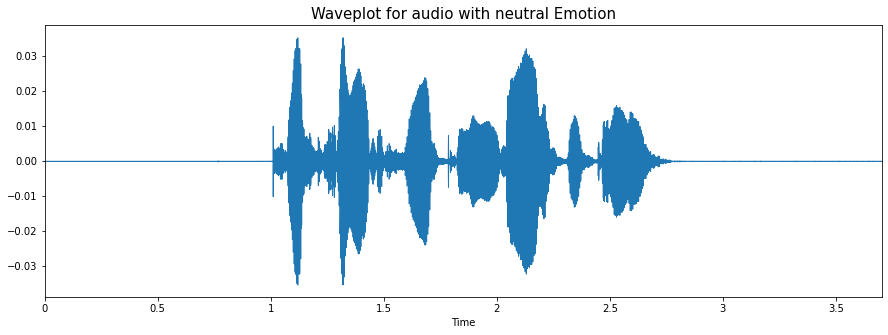

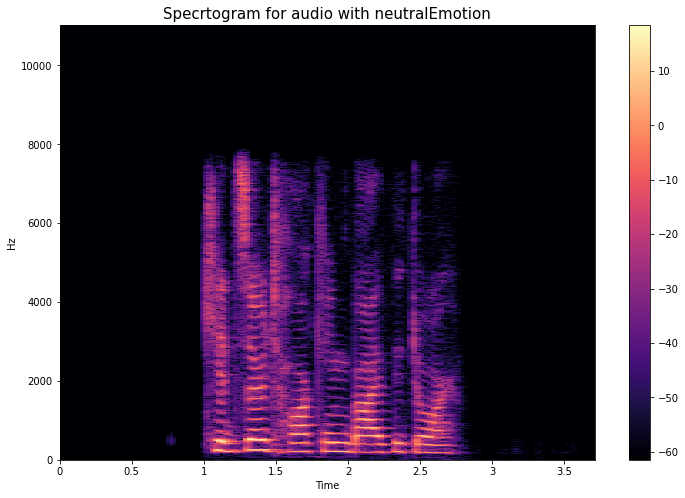

In [ ]:
emotions =['fear','happy', 'sad', 'angry', 'surprise','disgust', 'calm','neutral']
for emotion in emotions:
  path = np.array(ravdess_df.Paths[ravdess_df.Emotions==emotion])[1]
  data, sampling_rate = librosa.load(path)
  create_waveform(data,sampling_rate, emotion)
  create_spectrogram(data, sampling_rate, emotion)
  Audio(path)
  print()
  

In [ ]:
Audio(path)

In [ ]:
ravdess_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 1439
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Emotions  1440 non-null   object
 1   Paths     1440 non-null   object
dtypes: object(2)
memory usage: 22.6+ KB


## DATA AUGMENTATION
Since our data set is not that big we will modify our existing dataset and generate synthetic data from audio, like injecting noises, shifting time, changing pitch and speed. \
This would make our model more generalized. An important thing to keep in mind is that, the augmented data must have the same label as the orignal data. 

In [ ]:
def noise(data):
  noise_amp = 0.035*np.random.uniform()*np.amax(data)
  data = data + noise_amp*np.random.normal(size=data.shape[0])
  return data

In [ ]:
def stretch(data, rate=0.8):
  return librosa.effects.time_stretch(data,rate)

In [ ]:
def pitch(data, sampling_rate, pitch_factor=0.7):
  return (librosa.effects.pitch_shift(data, sampling_rate, pitch_factor))

Simple audio without modulations


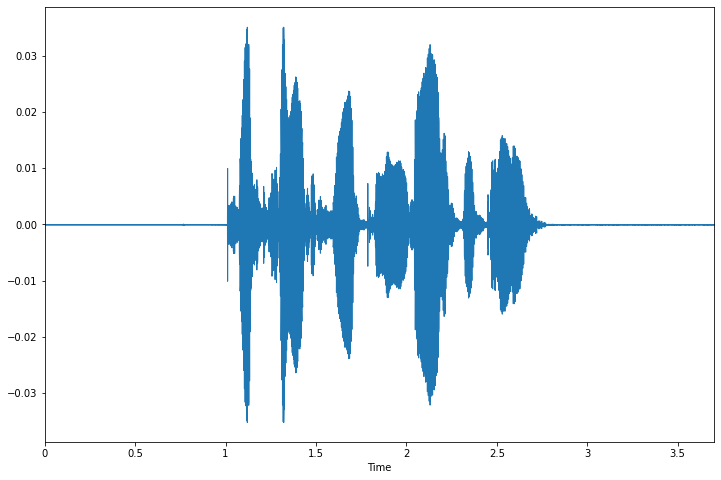

In [ ]:
print('Simple audio without modulations')
plt.figure(figsize=(12,8))
librosa.display.waveplot(y=data, sr= sampling_rate)
Audio(path)

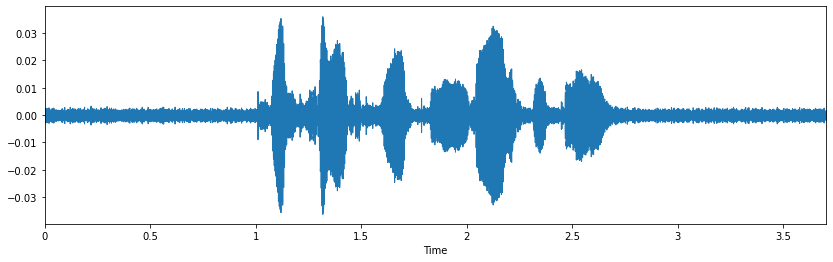

In [ ]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr = sampling_rate)
Audio(x, rate=sampling_rate)

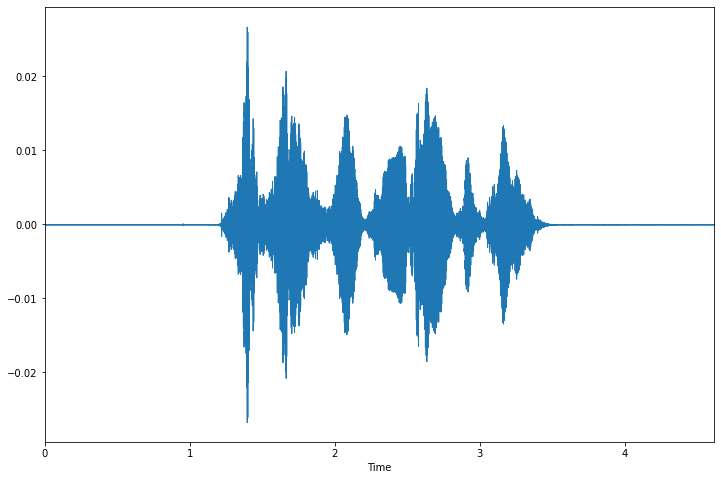

In [ ]:
x = stretch(data)
plt.figure(figsize=(12,8))
librosa.display.waveplot(y=x, sr=sampling_rate)
Audio(x, rate = sampling_rate)

In [ ]:
%cd /content/
!mkdir spectrogram

/content


/content


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this war

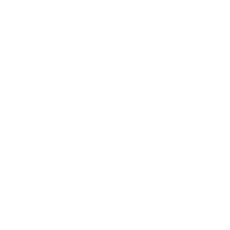

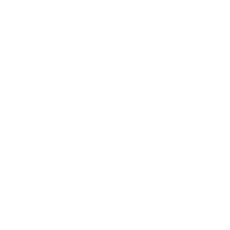

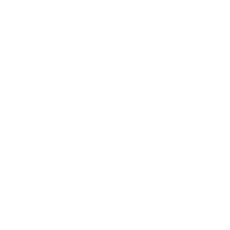

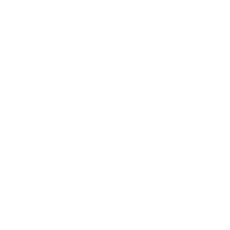

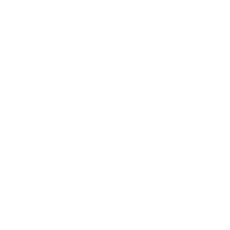

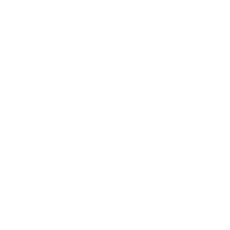

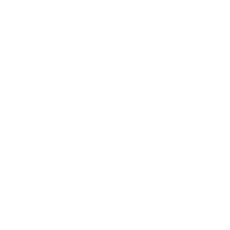

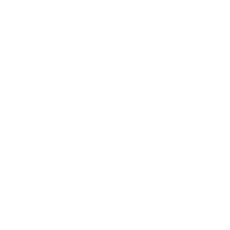

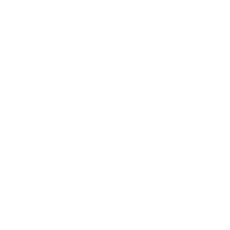

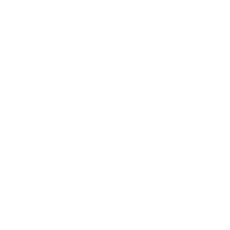

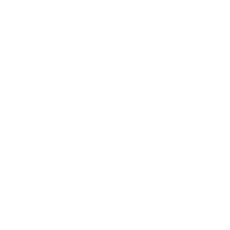

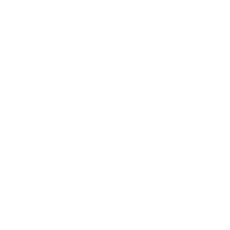

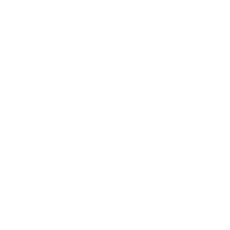

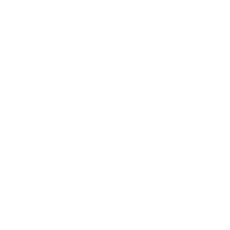

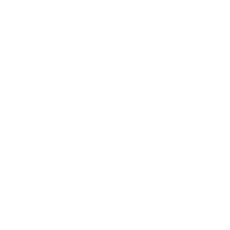

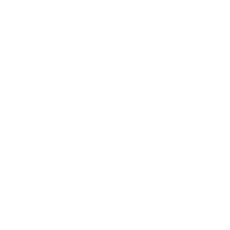

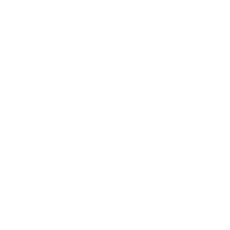

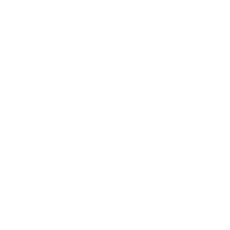

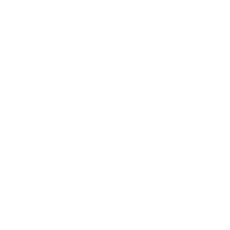

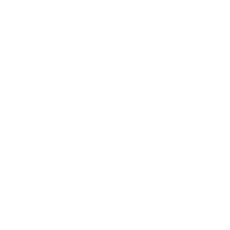

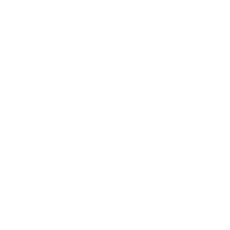

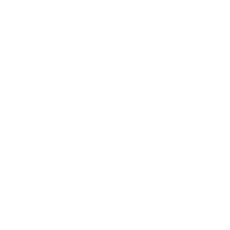

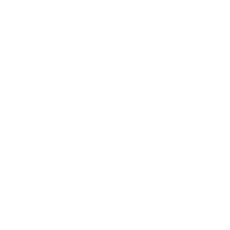

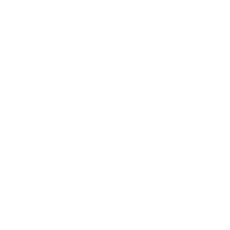

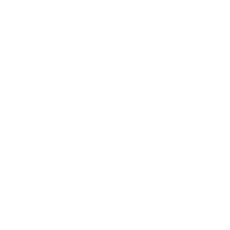

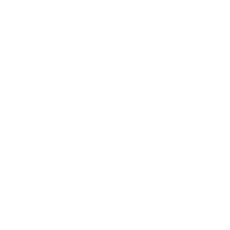

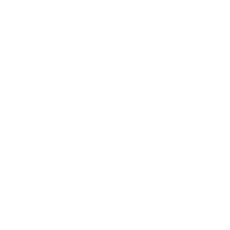

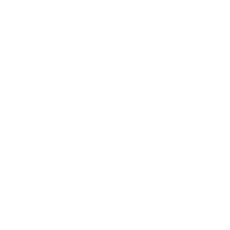

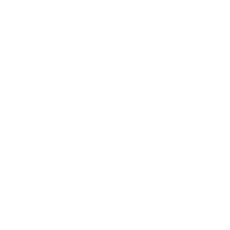

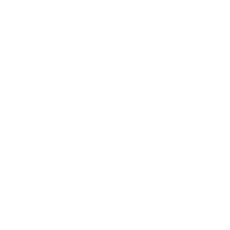

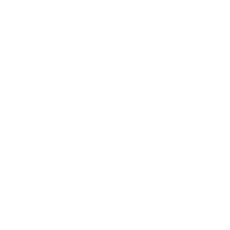

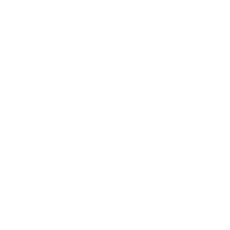

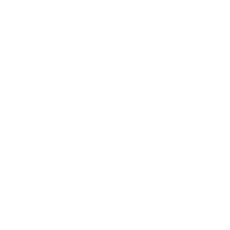

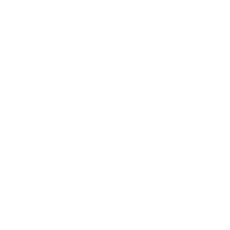

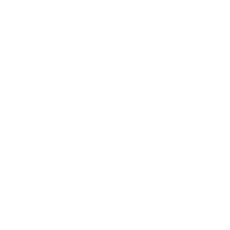

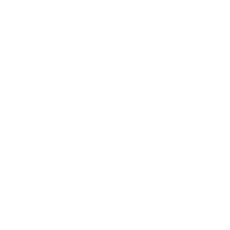

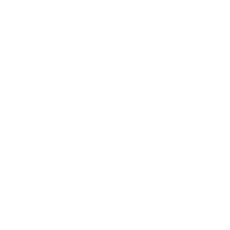

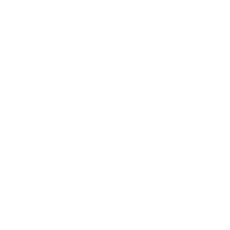

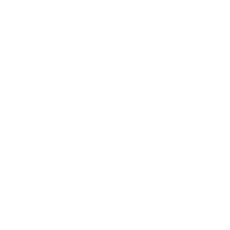

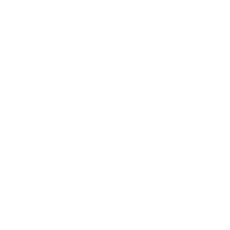

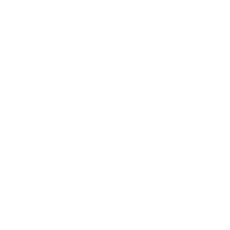

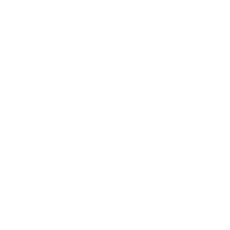

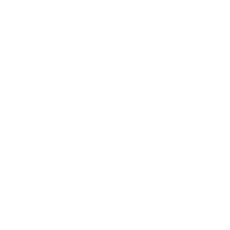

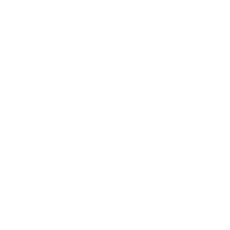

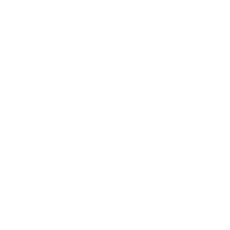

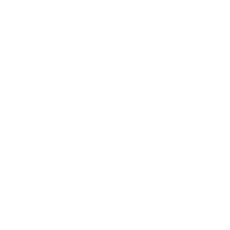

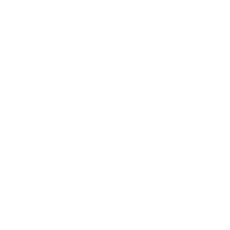

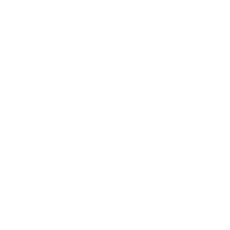

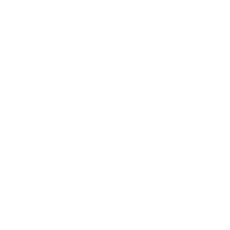

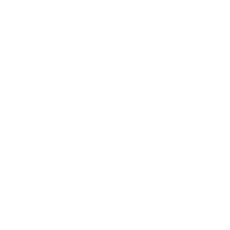

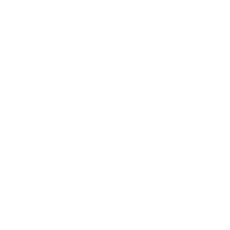

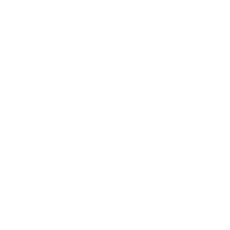

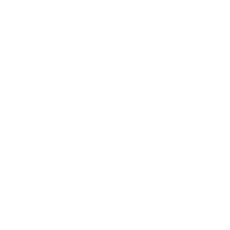

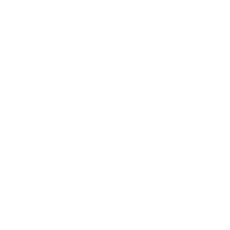

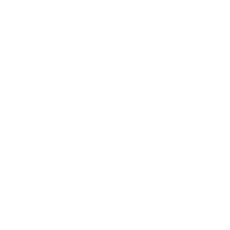

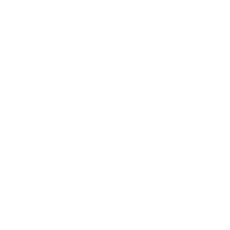

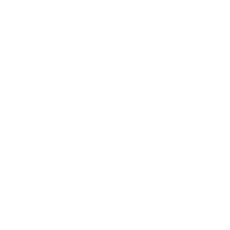

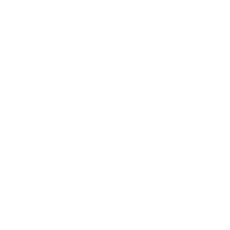

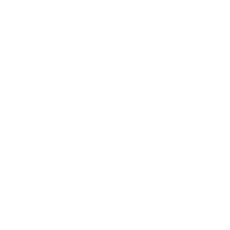

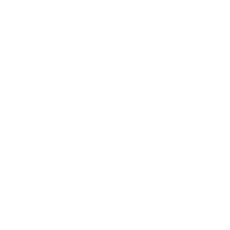

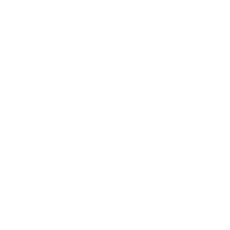

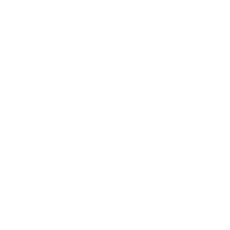

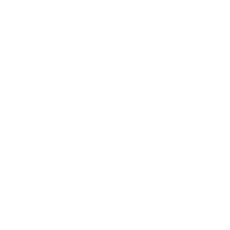

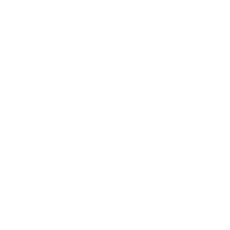

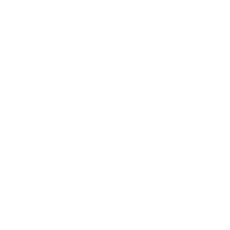

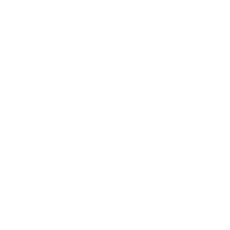

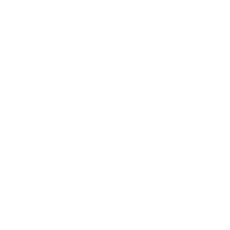

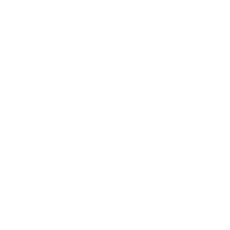

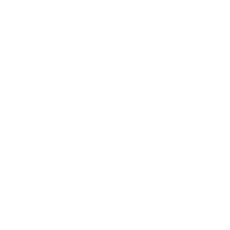

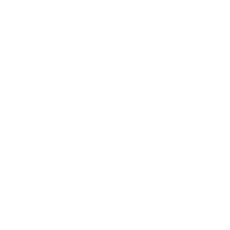

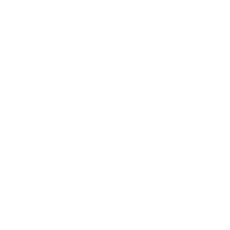

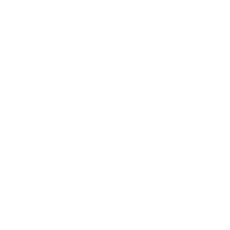

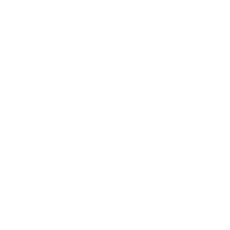

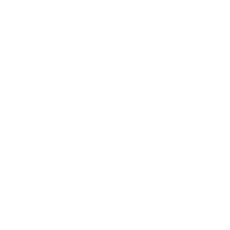

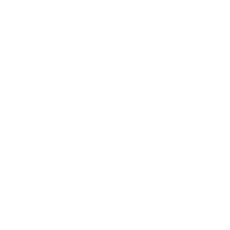

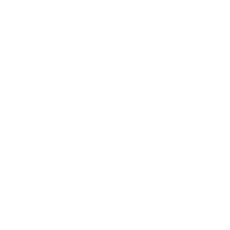

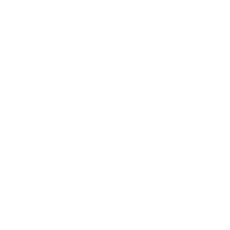

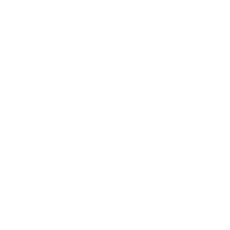

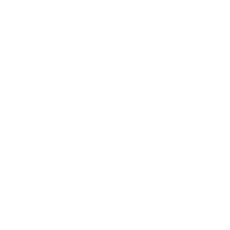

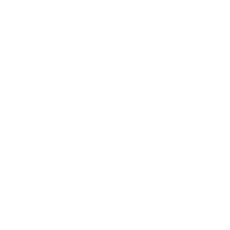

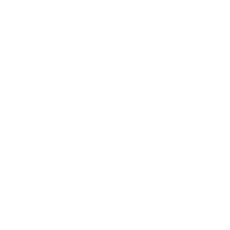

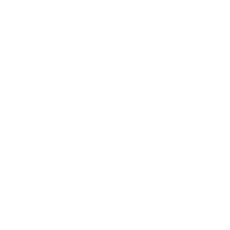

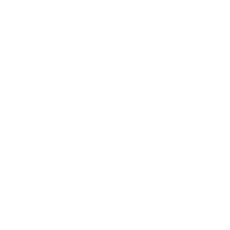

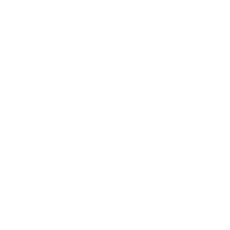

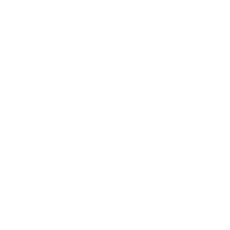

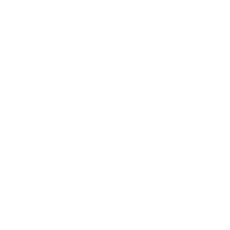

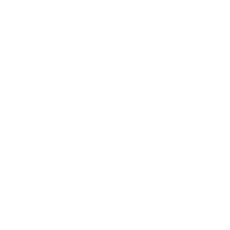

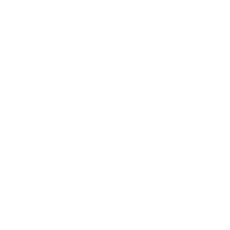

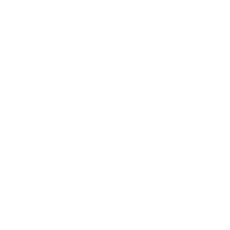

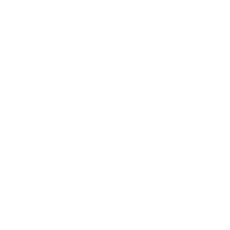

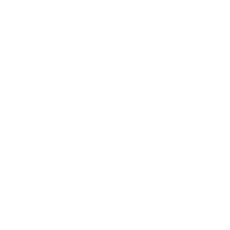

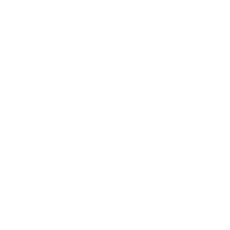

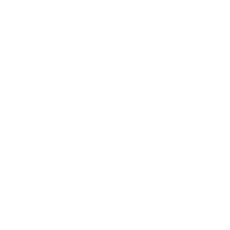

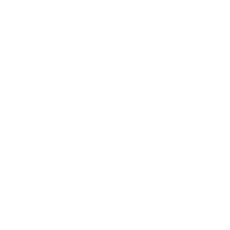

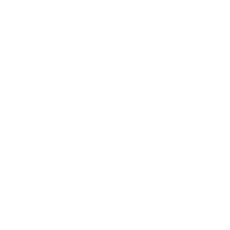

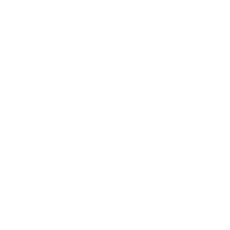

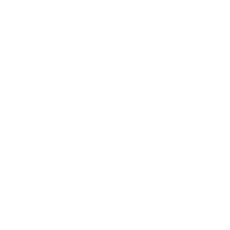

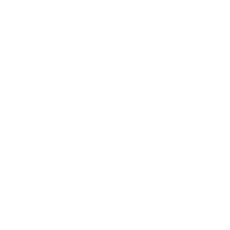

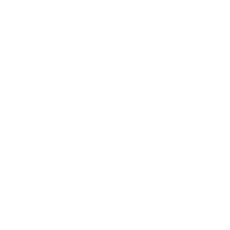

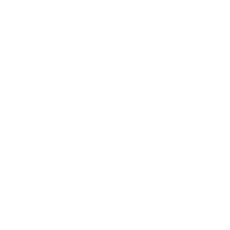

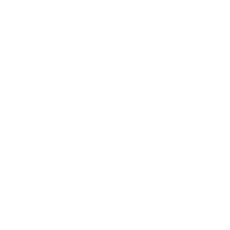

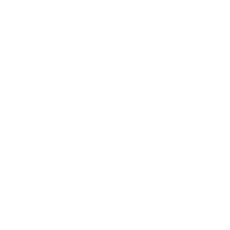

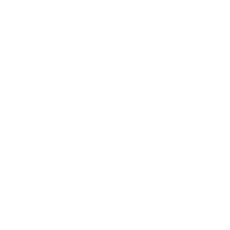

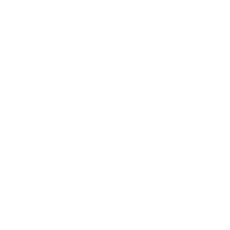

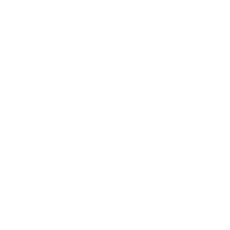

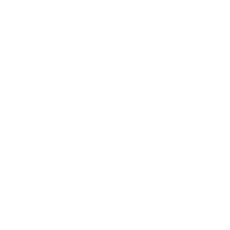

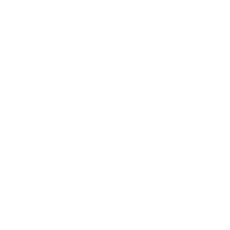

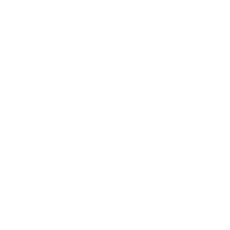

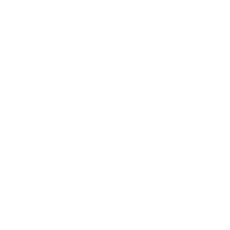

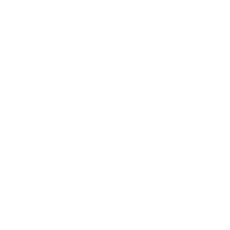

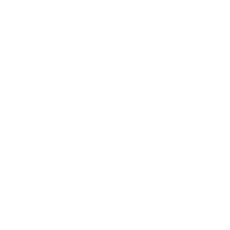

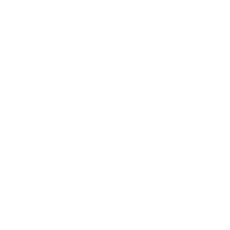

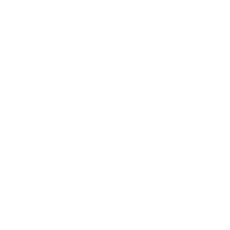

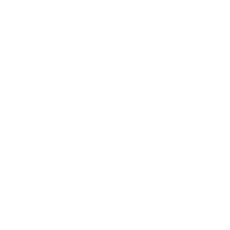

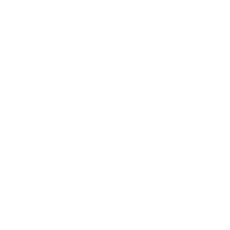

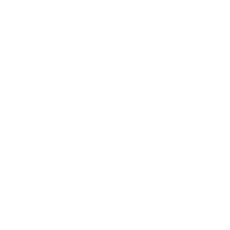

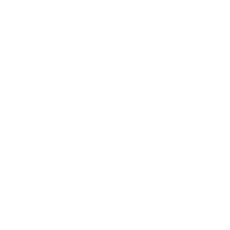

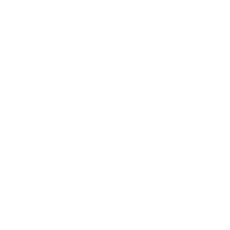

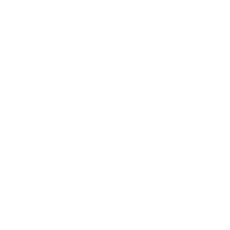

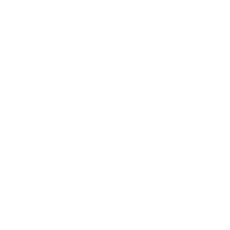

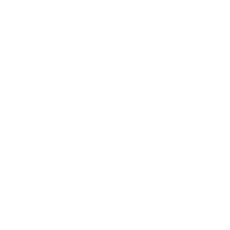

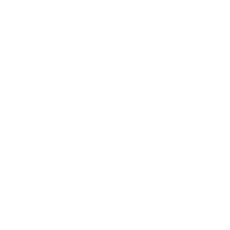

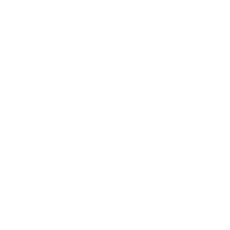

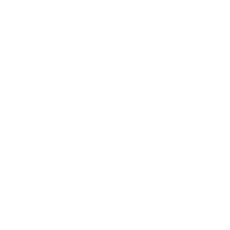

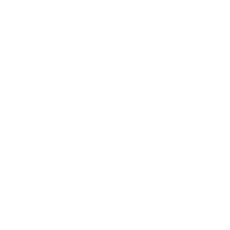

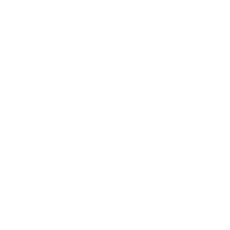

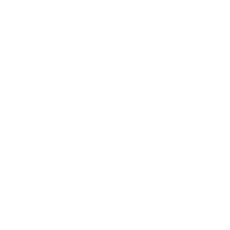

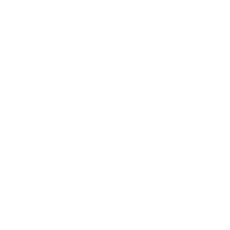

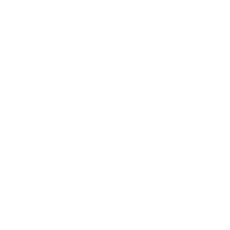

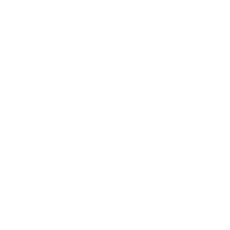

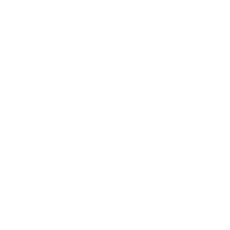

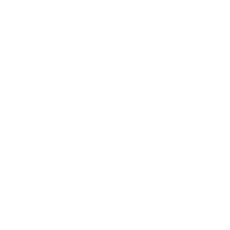

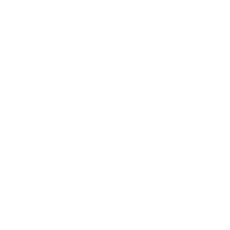

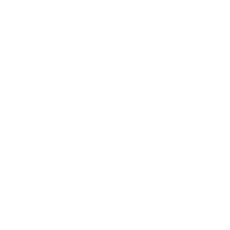

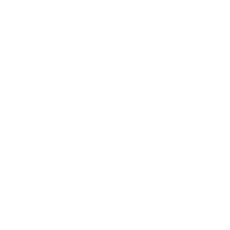

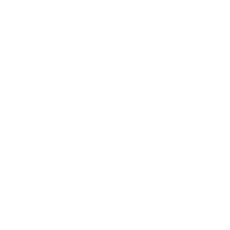

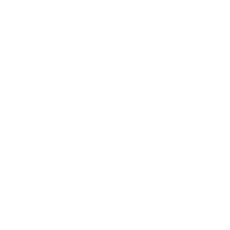

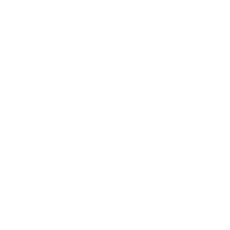

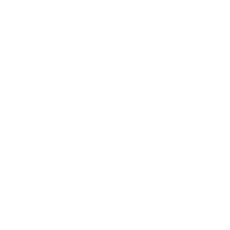

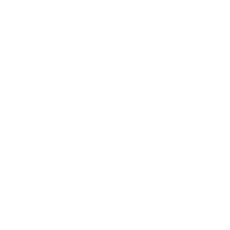

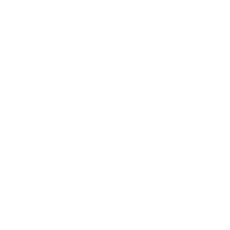

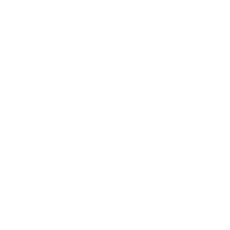

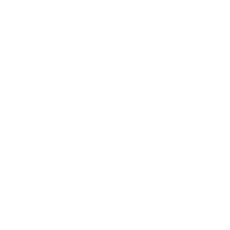

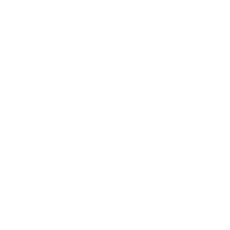

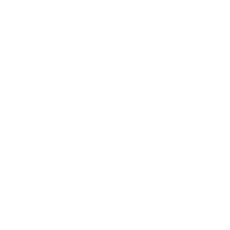

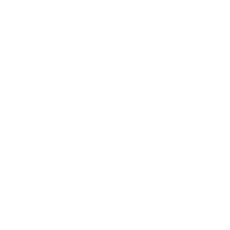

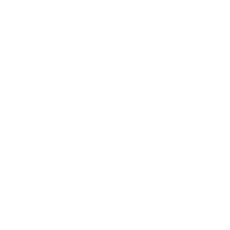

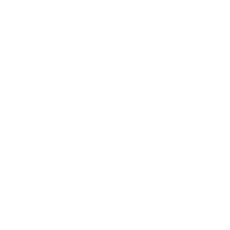

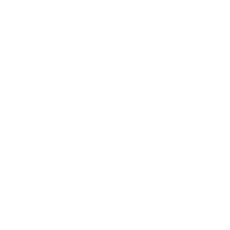

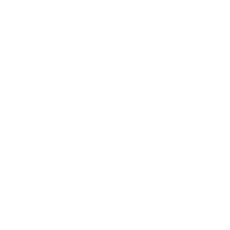

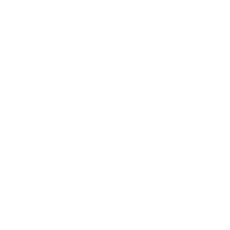

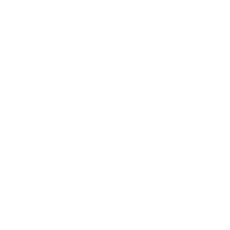

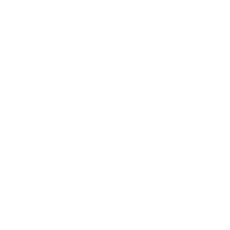

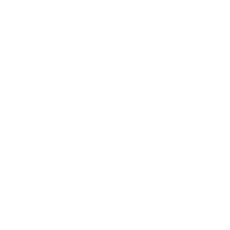

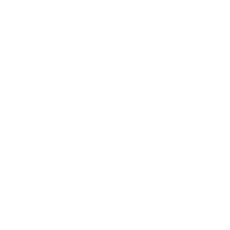

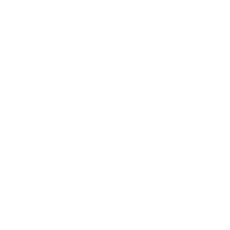

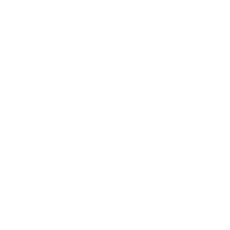

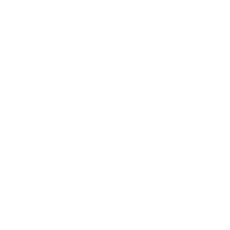

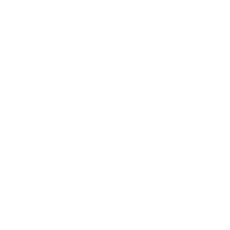

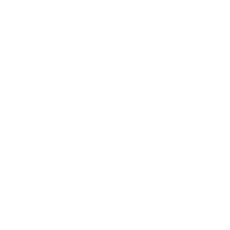

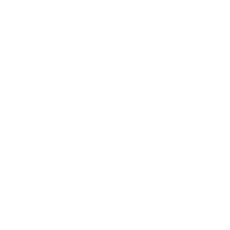

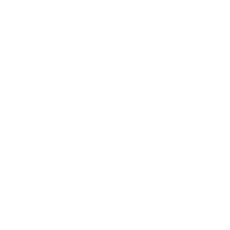

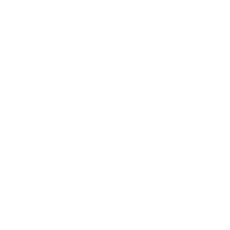

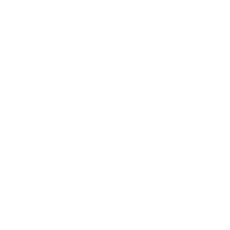

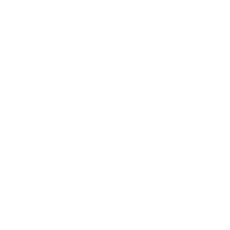

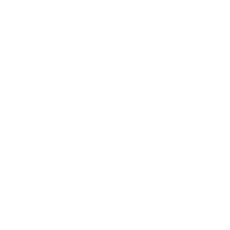

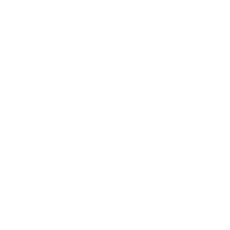

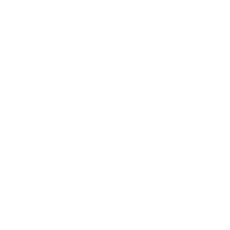

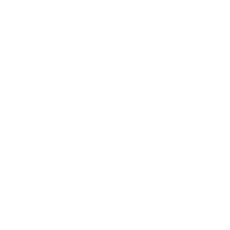

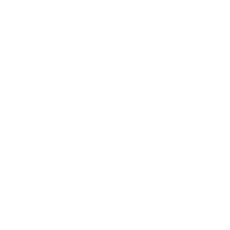

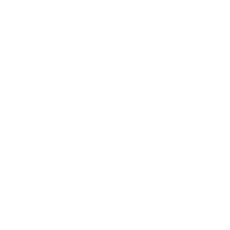

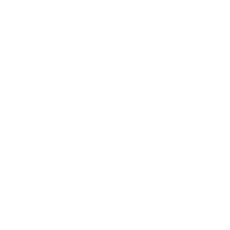

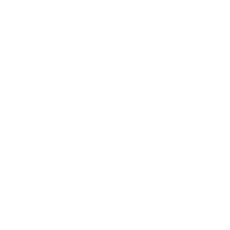

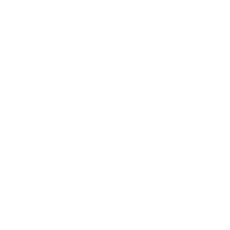

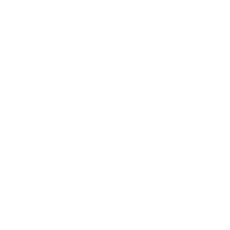

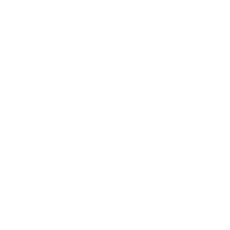

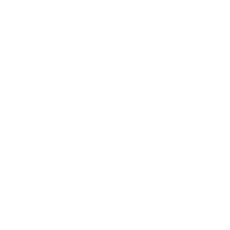

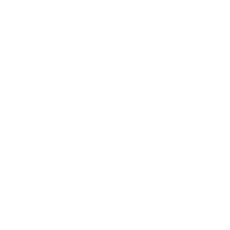

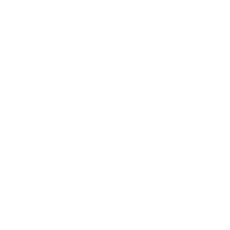

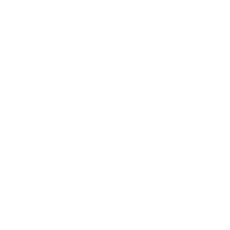

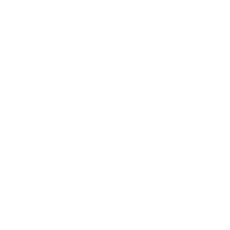

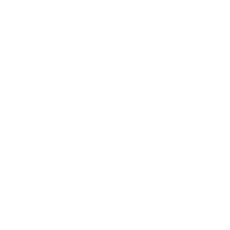

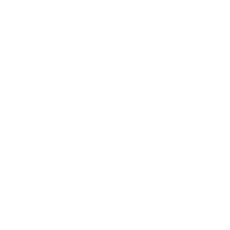

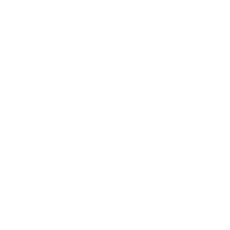

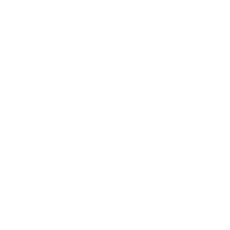

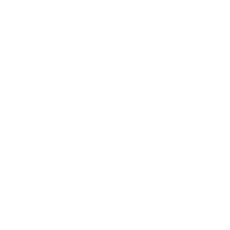

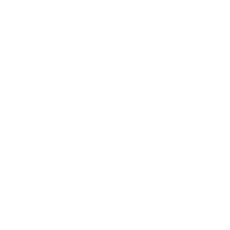

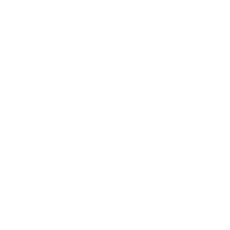

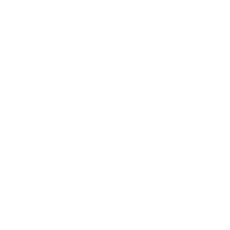

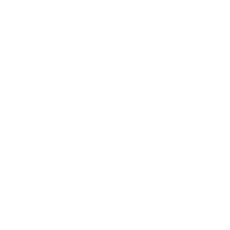

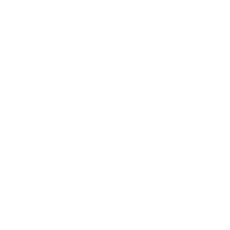

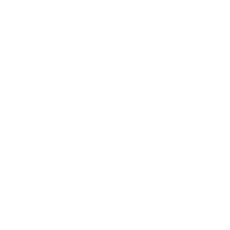

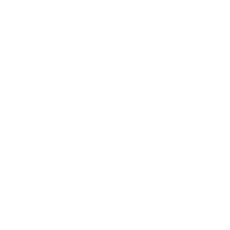

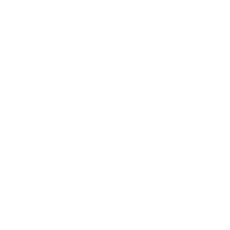

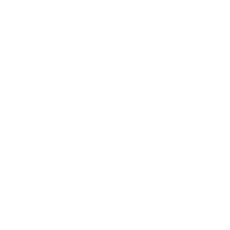

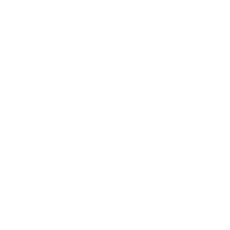

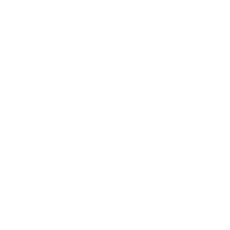

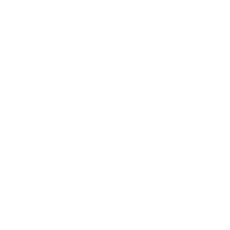

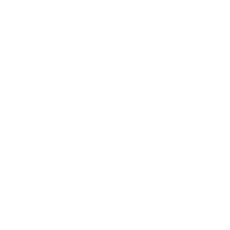

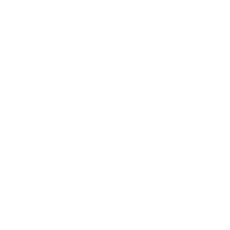

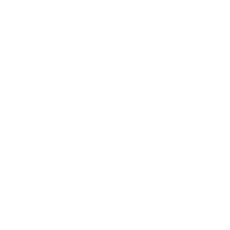

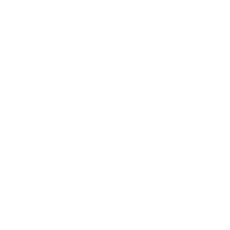

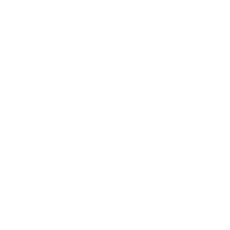

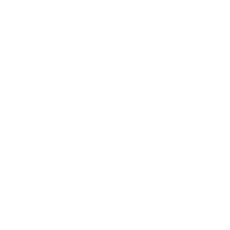

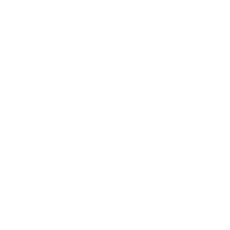

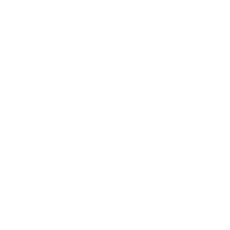

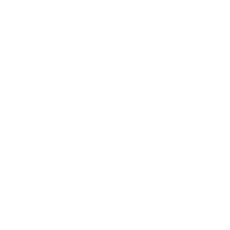

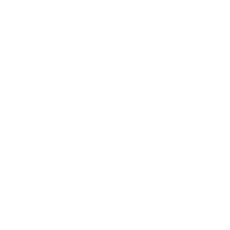

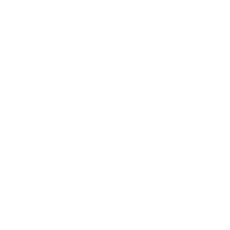

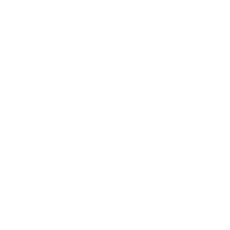

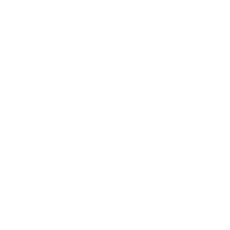

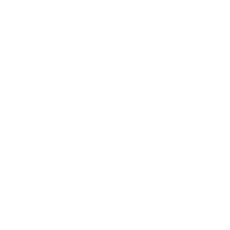

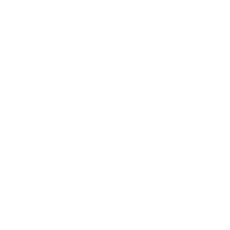

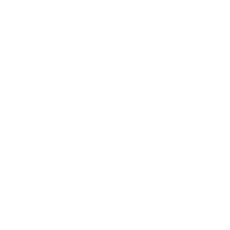

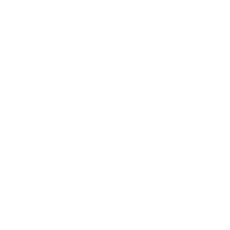

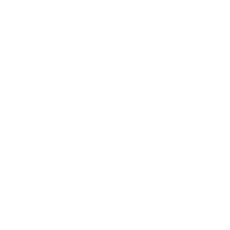

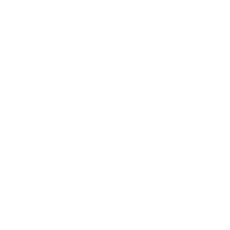

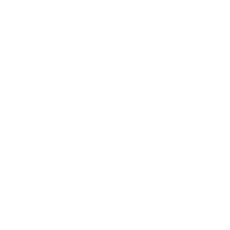

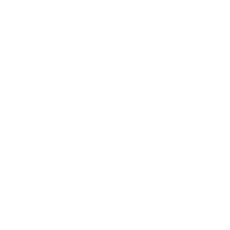

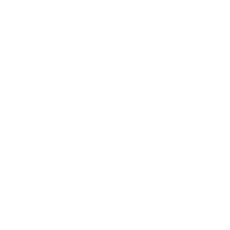

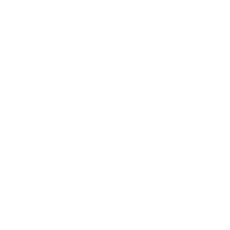

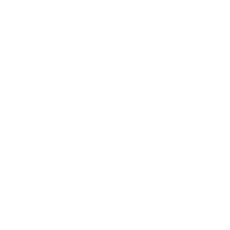

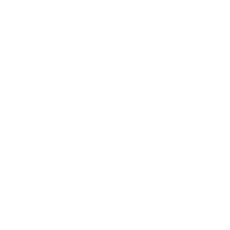

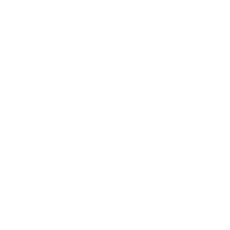

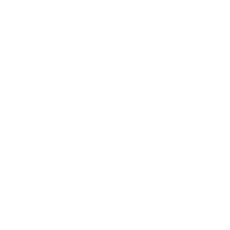

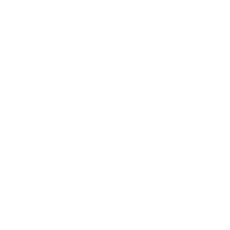

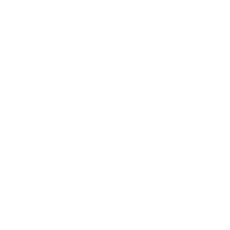

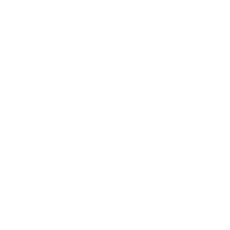

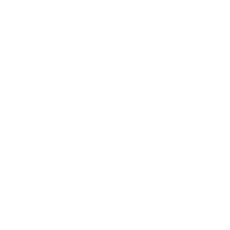

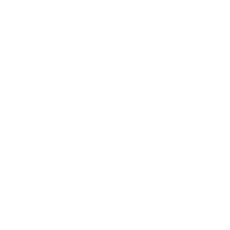

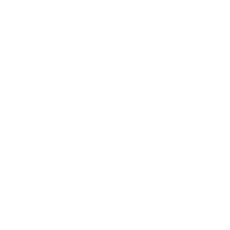

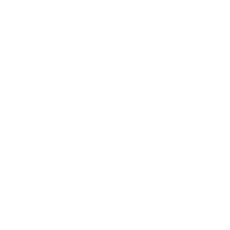

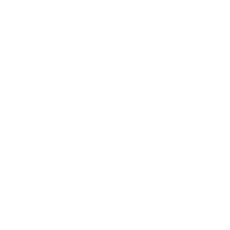

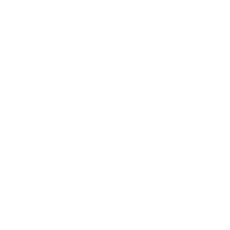

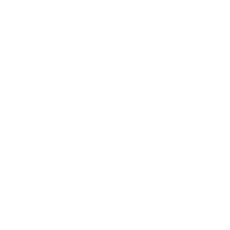

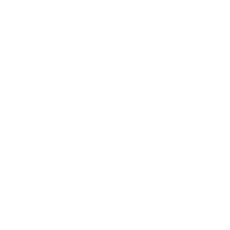

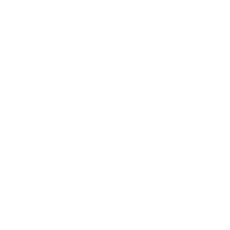

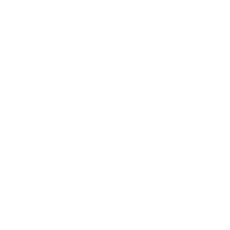

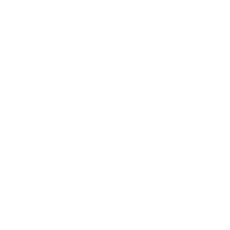

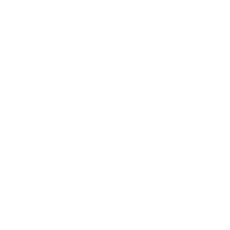

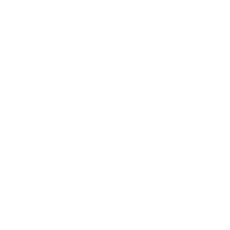

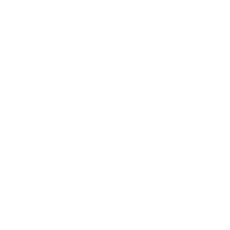

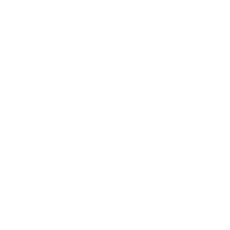

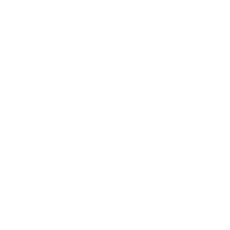

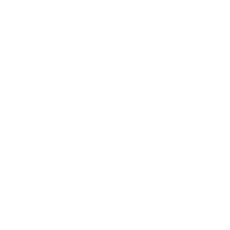

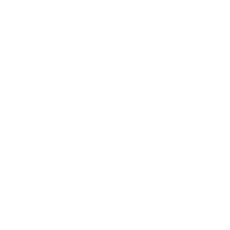

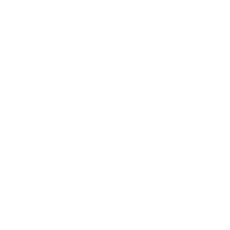

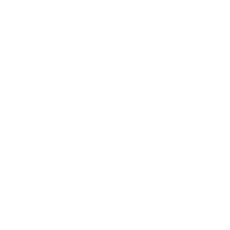

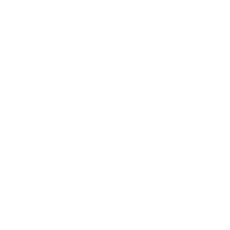

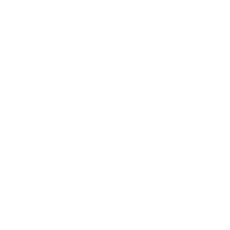

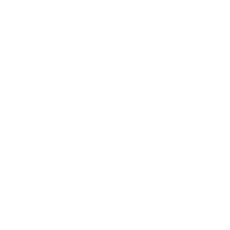

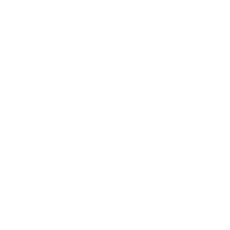

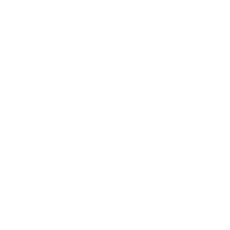

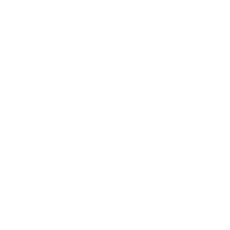

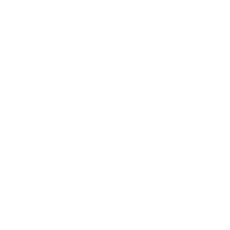

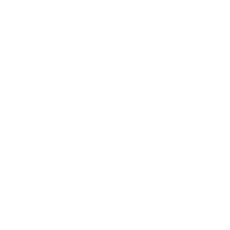

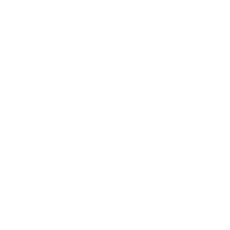

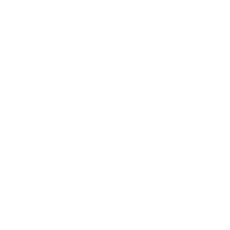

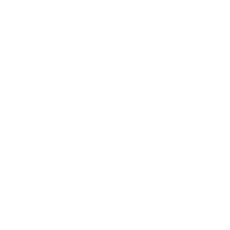

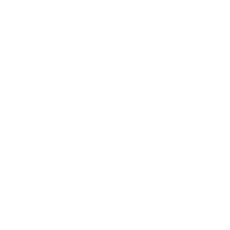

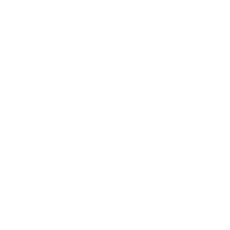

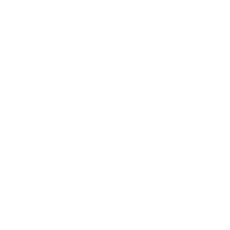

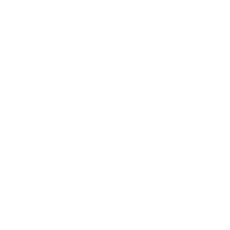

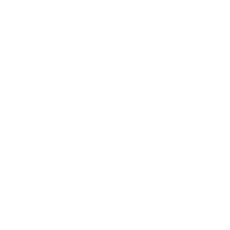

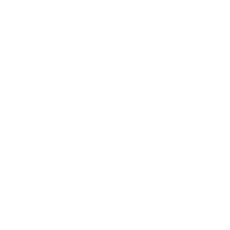

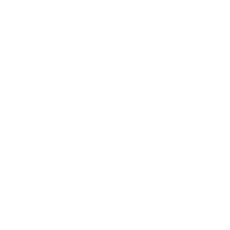

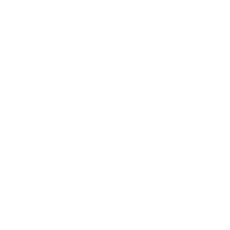

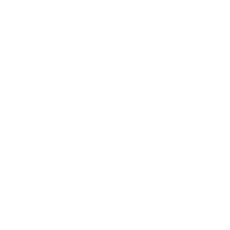

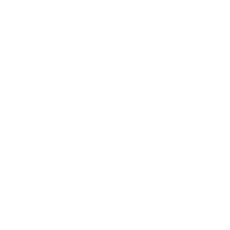

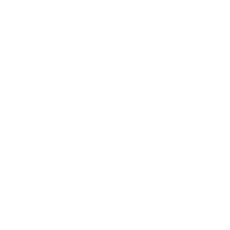

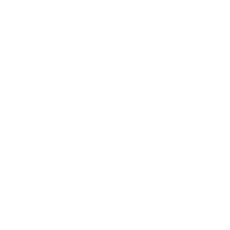

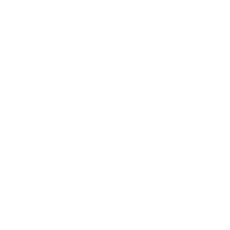

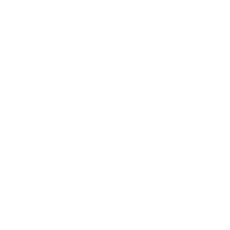

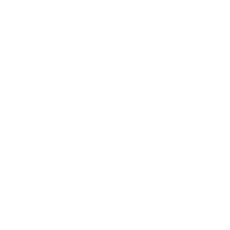

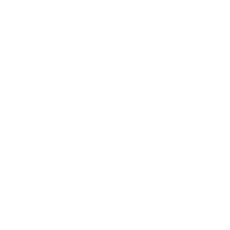

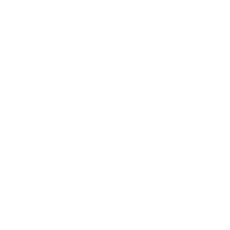

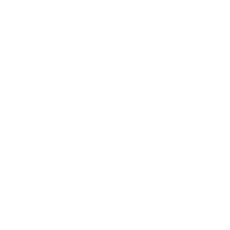

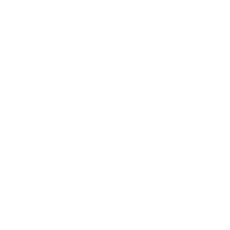

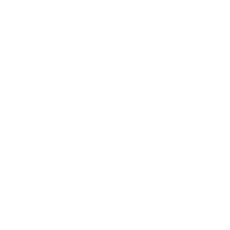

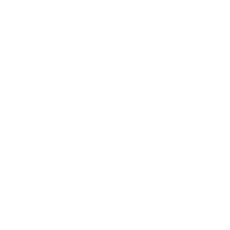

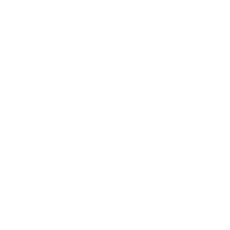

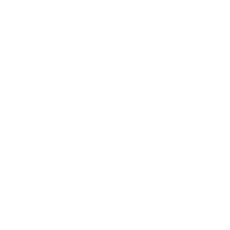

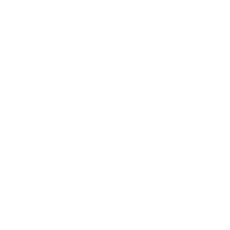

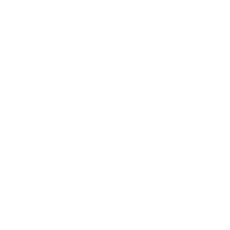

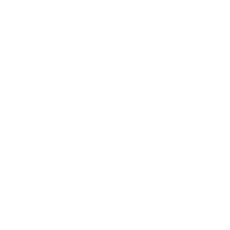

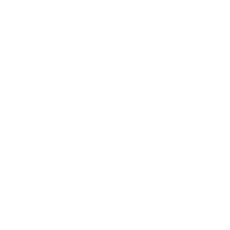

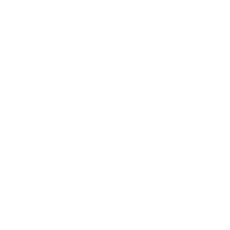

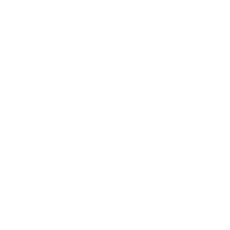

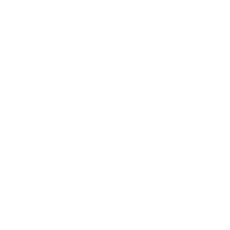

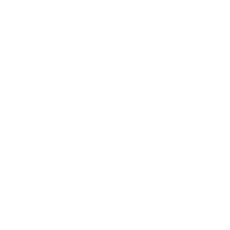

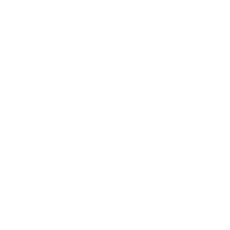

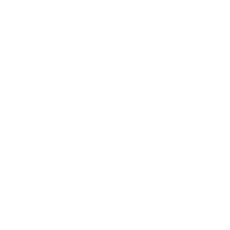

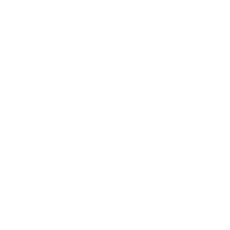

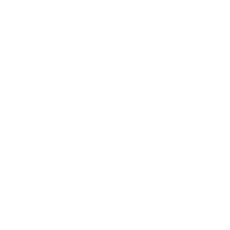

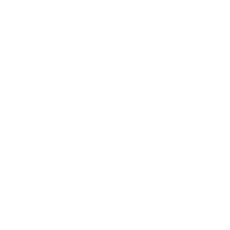

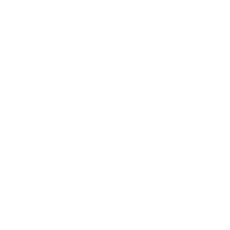

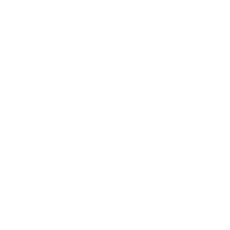

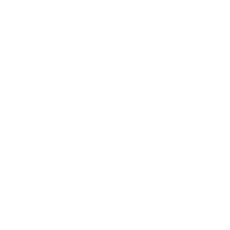

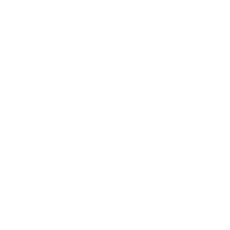

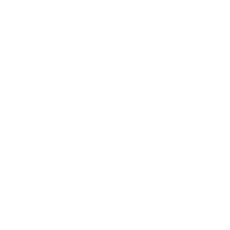

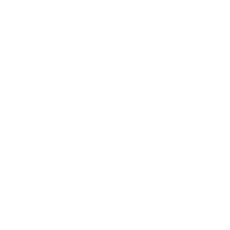

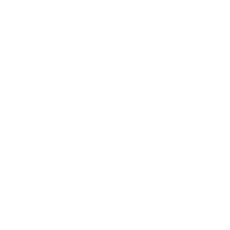

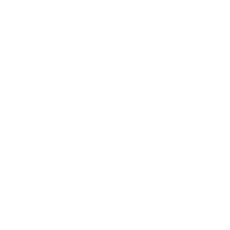

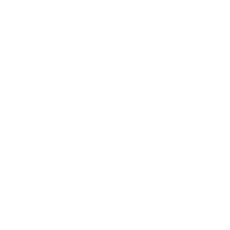

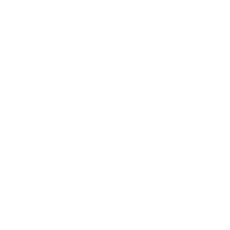

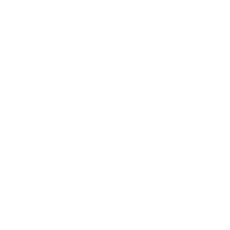

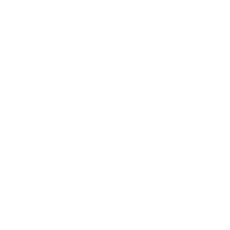

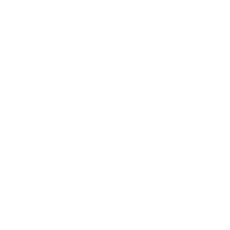

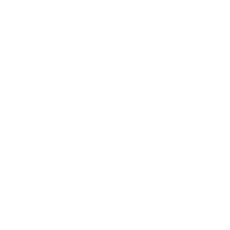

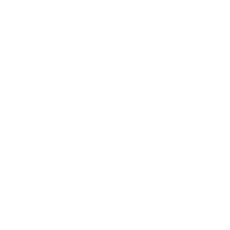

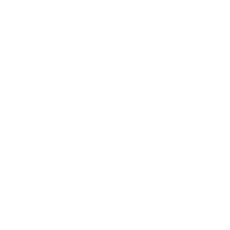

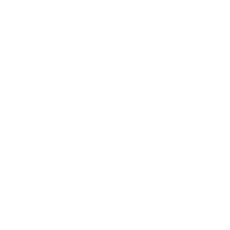

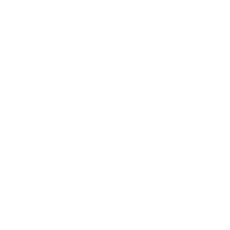

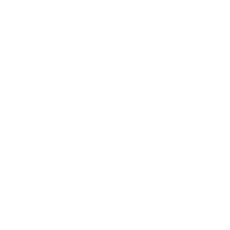

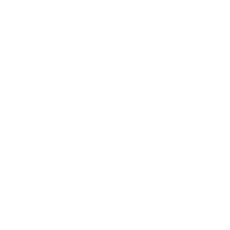

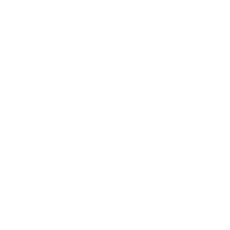

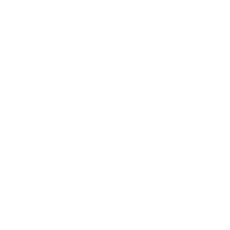

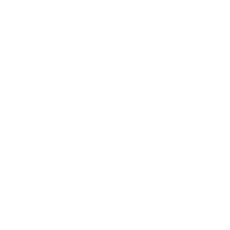

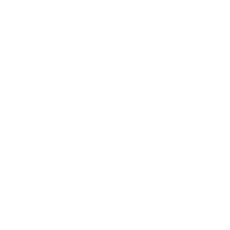

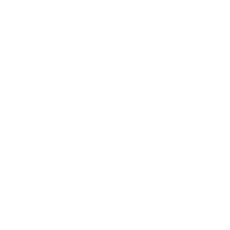

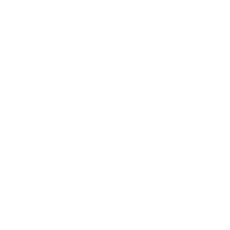

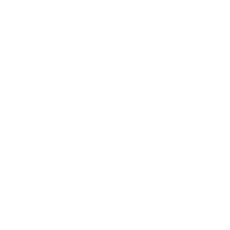

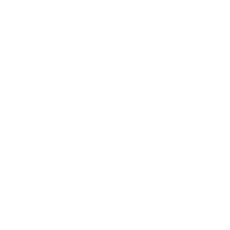

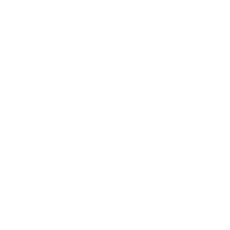

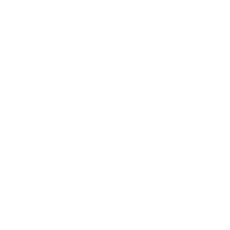

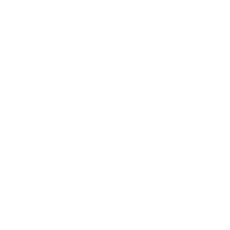

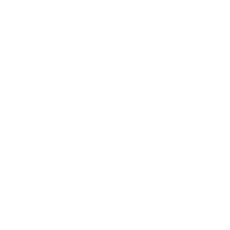

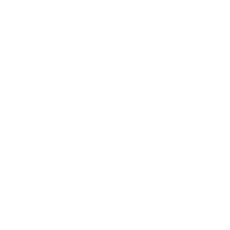

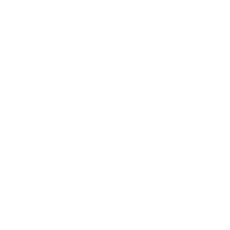

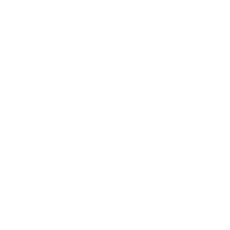

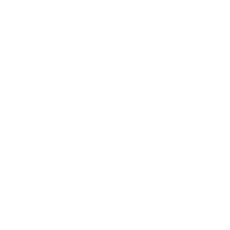

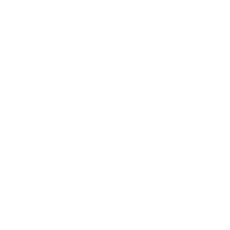

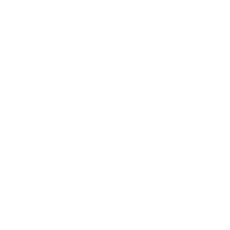

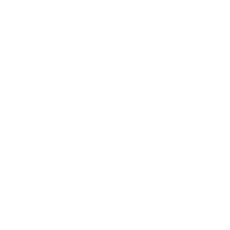

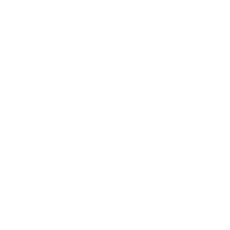

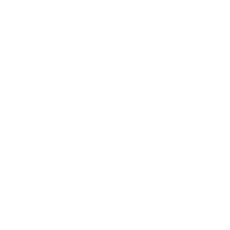

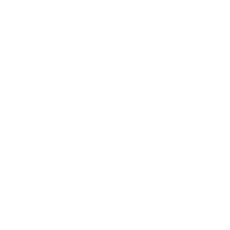

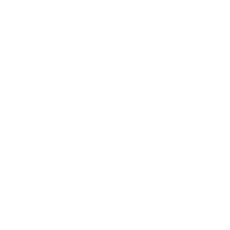

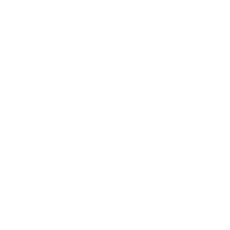

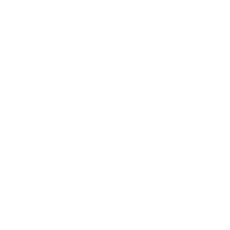

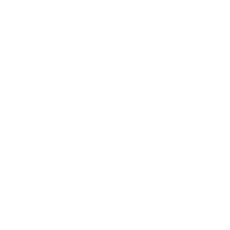

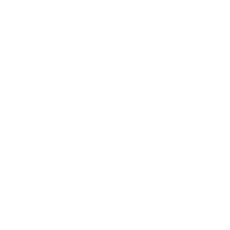

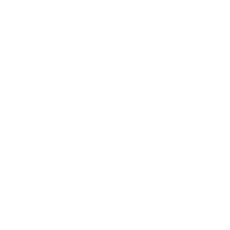

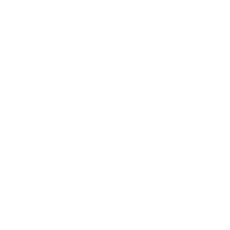

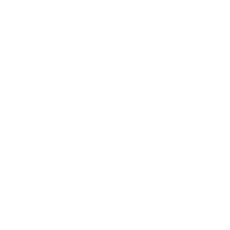

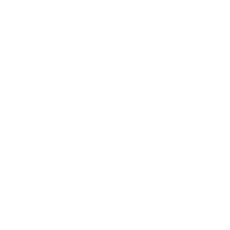

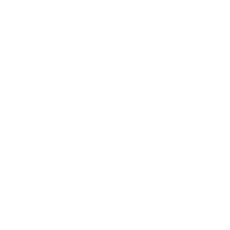

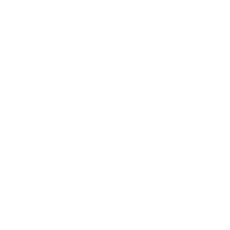

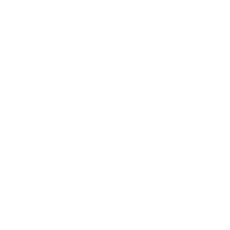

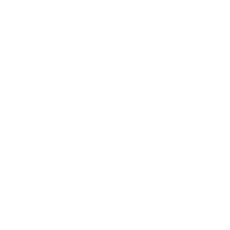

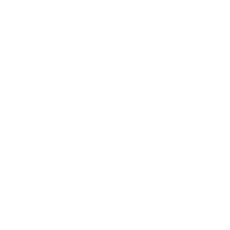

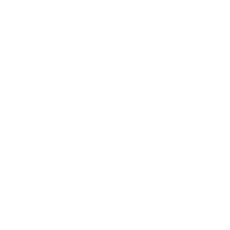

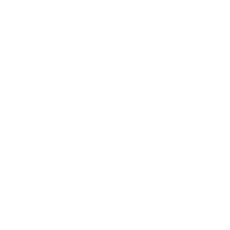

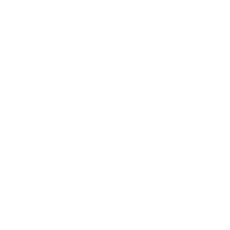

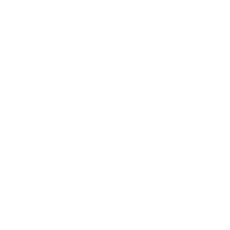

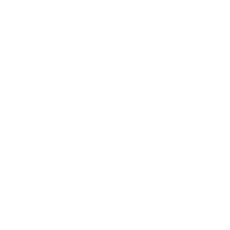

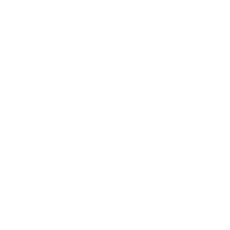

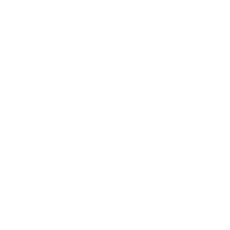

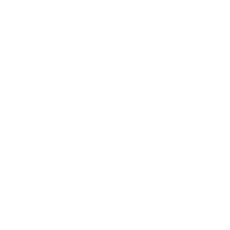

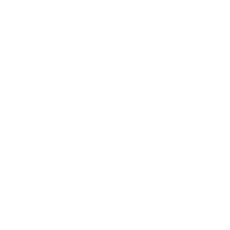

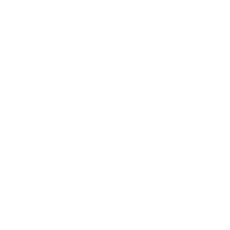

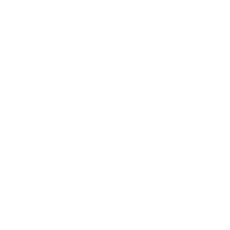

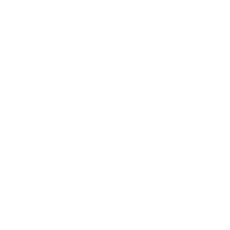

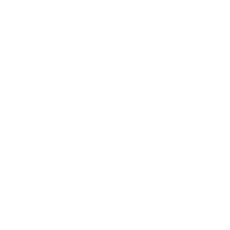

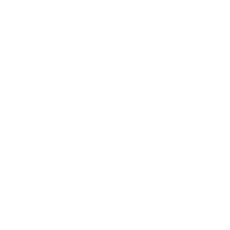

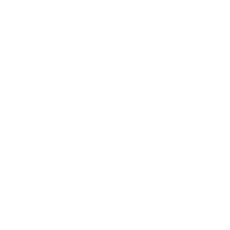

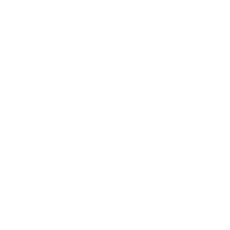

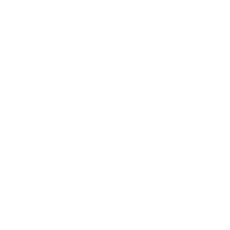

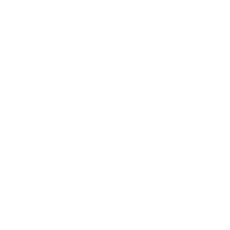

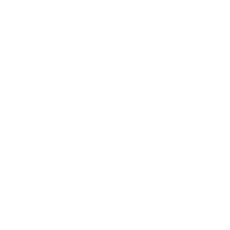

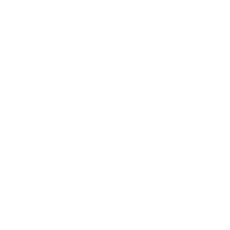

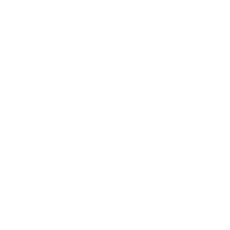

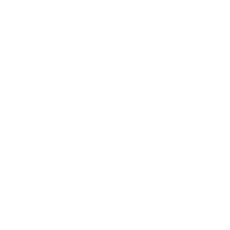

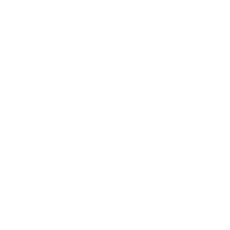

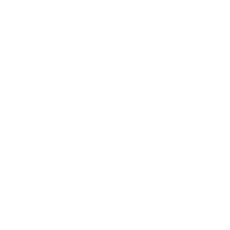

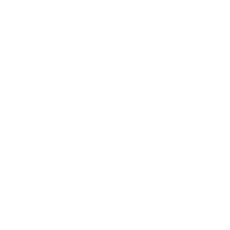

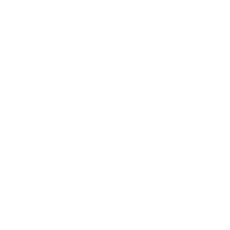

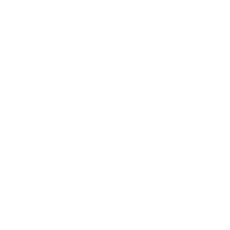

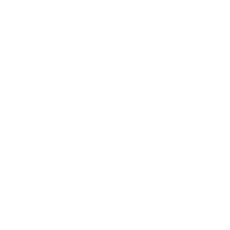

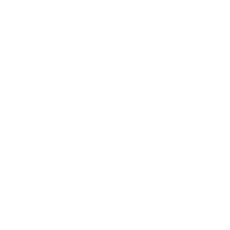

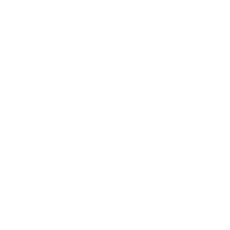

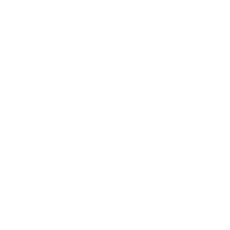

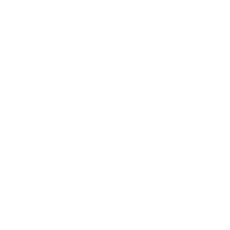

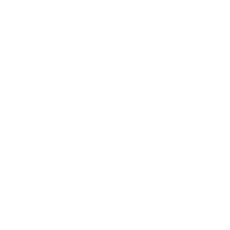

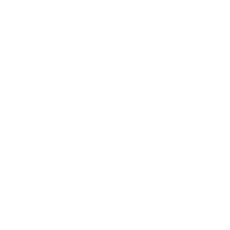

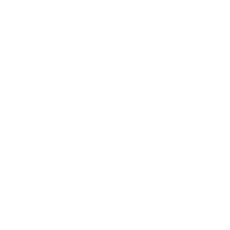

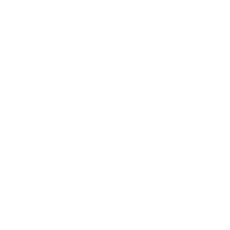

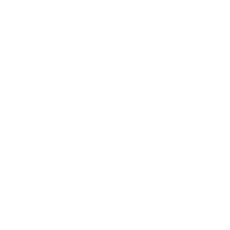

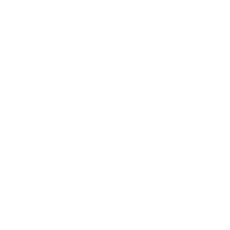

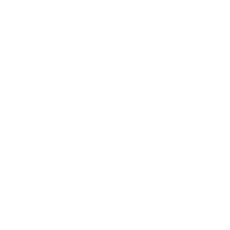

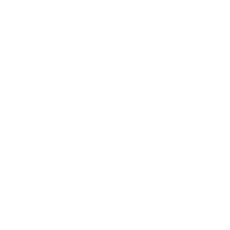

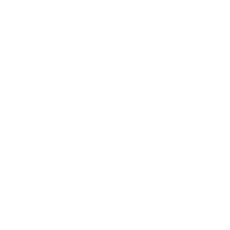

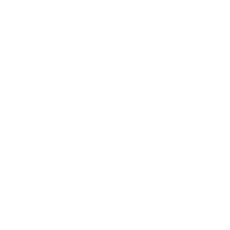

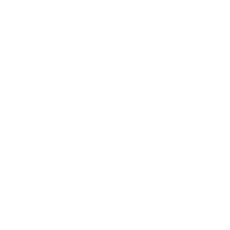

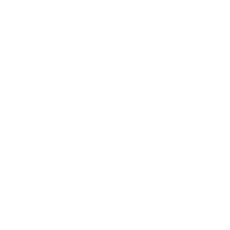

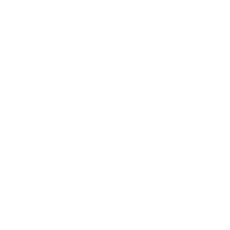

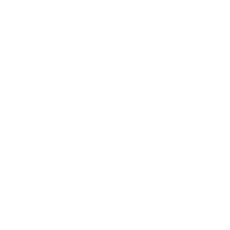

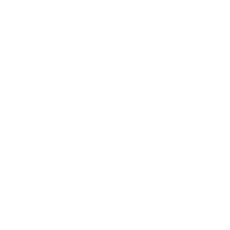

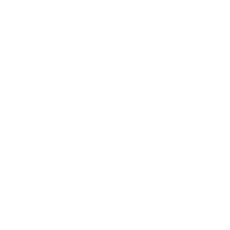

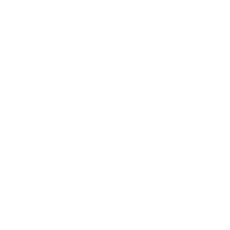

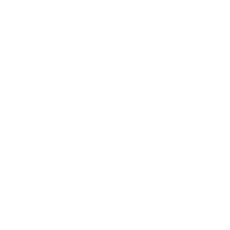

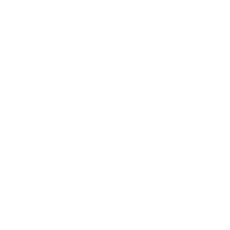

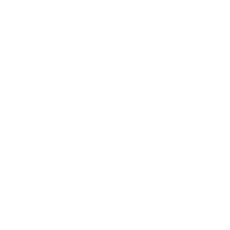

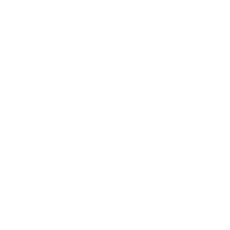

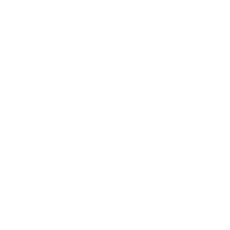

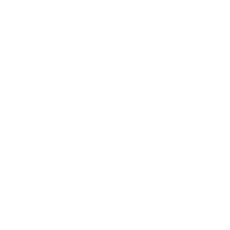

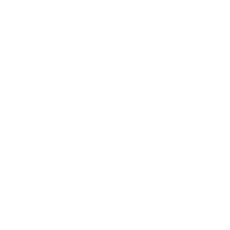

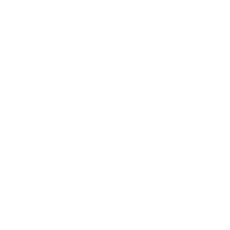

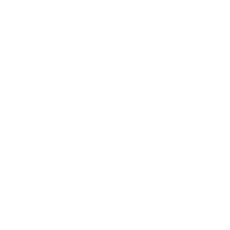

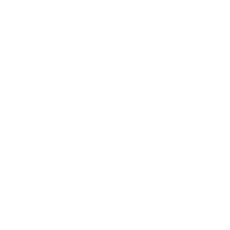

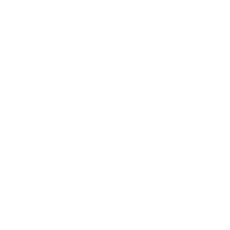

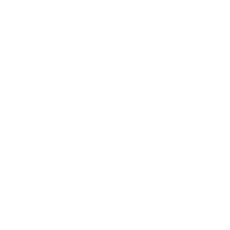

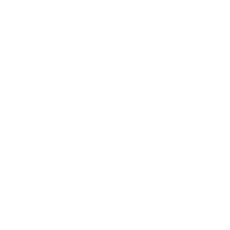

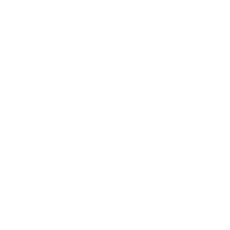

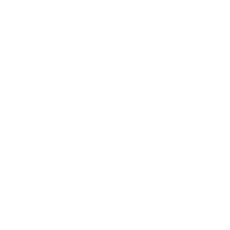

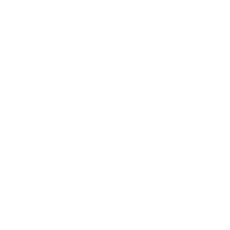

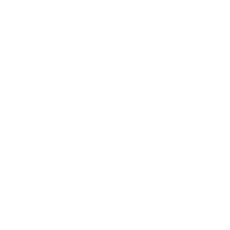

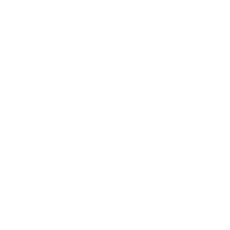

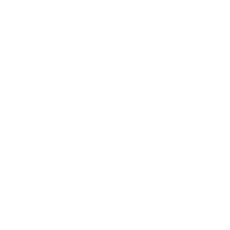

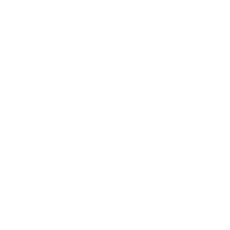

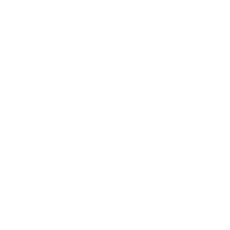

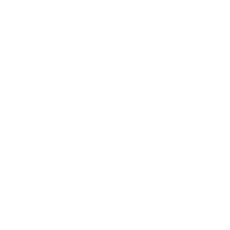

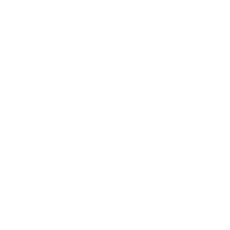

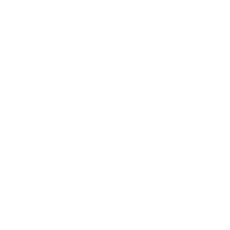

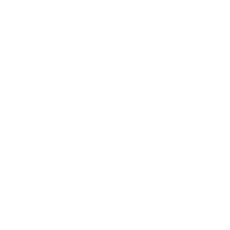

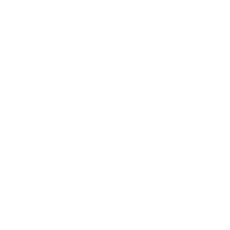

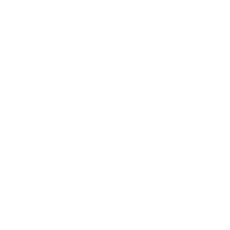

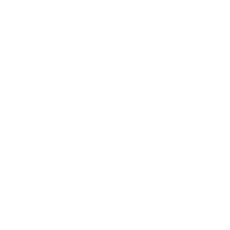

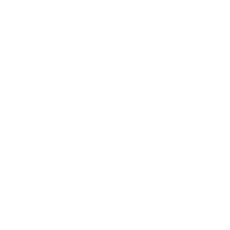

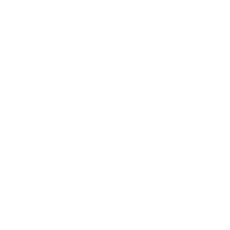

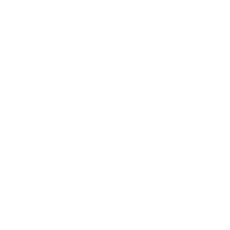

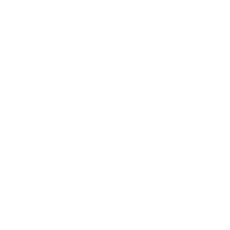

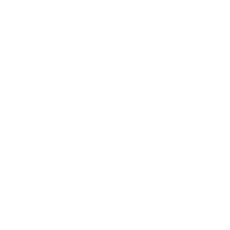

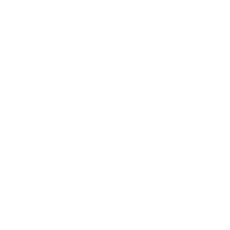

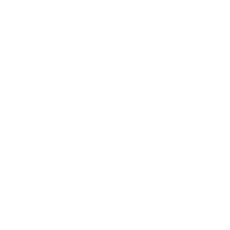

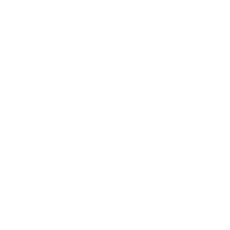

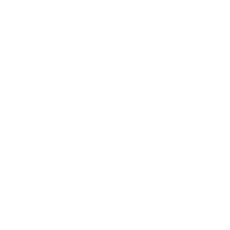

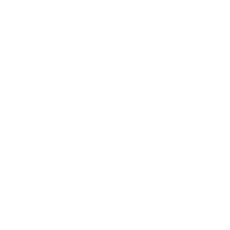

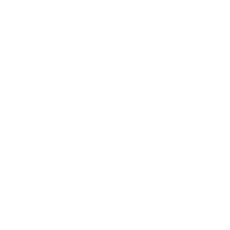

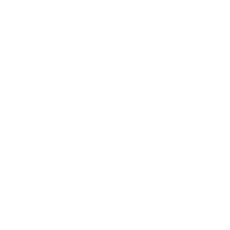

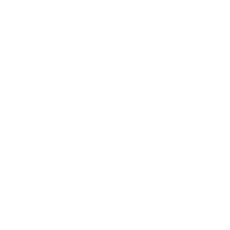

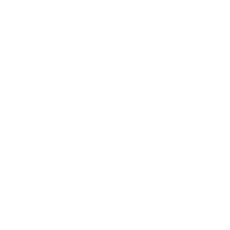

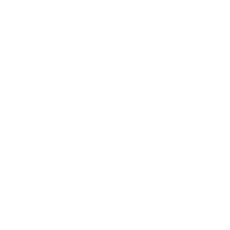

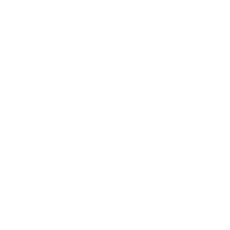

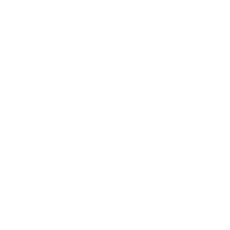

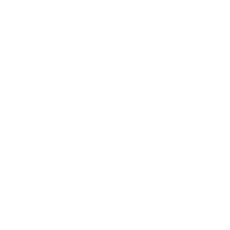

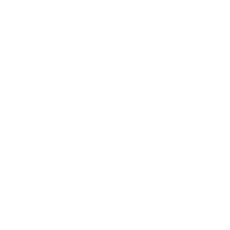

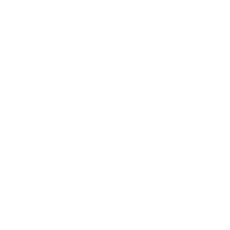

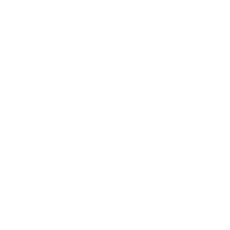

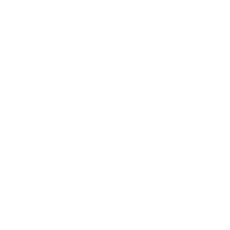

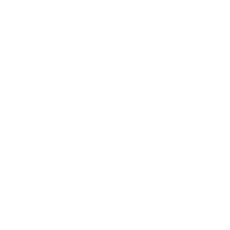

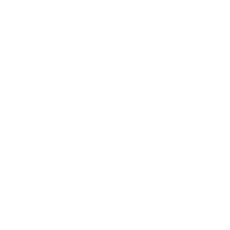

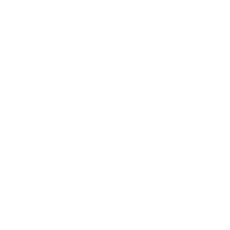

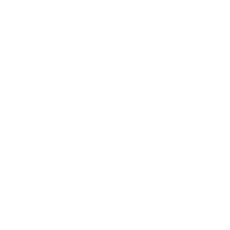

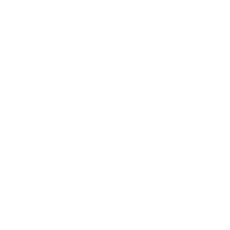

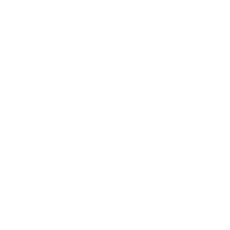

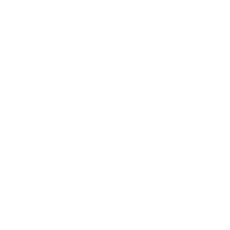

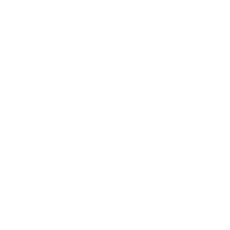

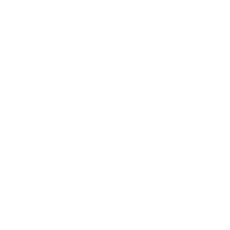

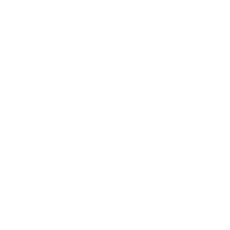

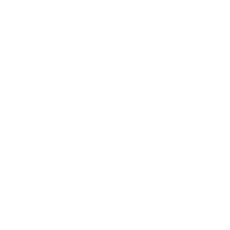

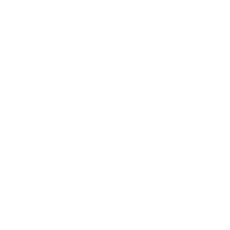

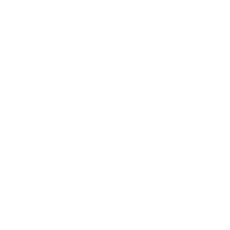

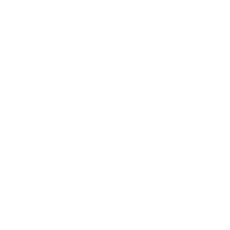

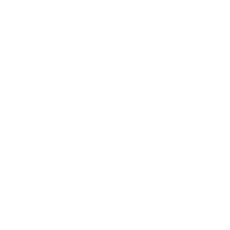

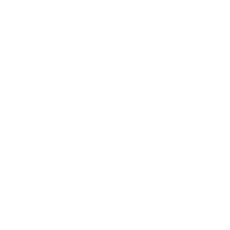

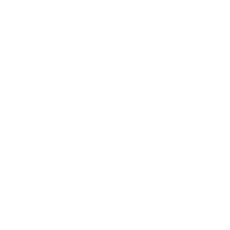

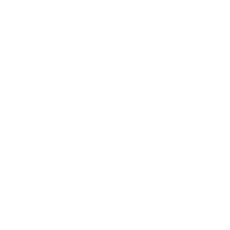

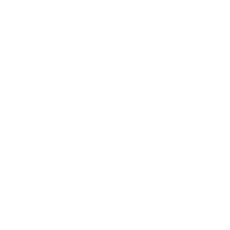

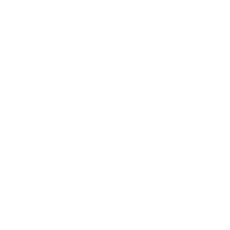

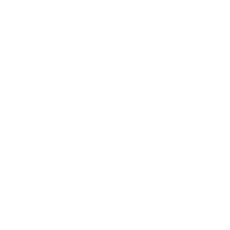

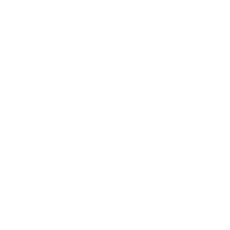

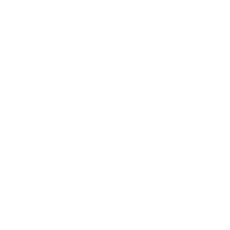

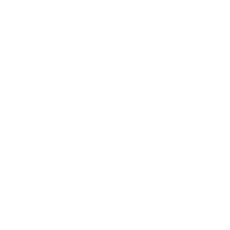

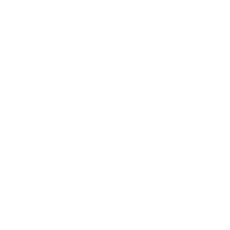

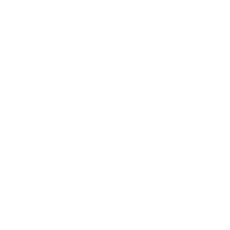

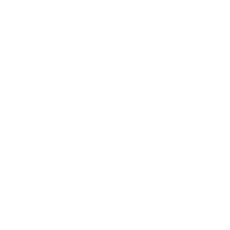

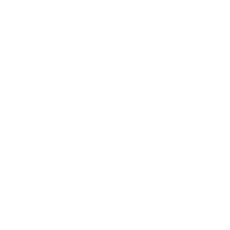

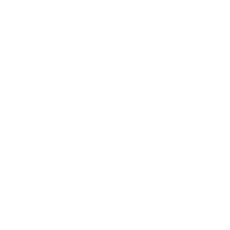

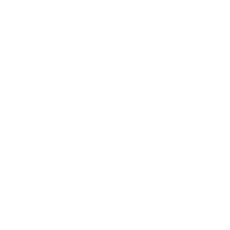

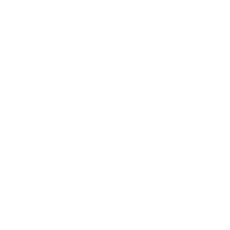

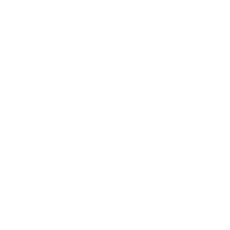

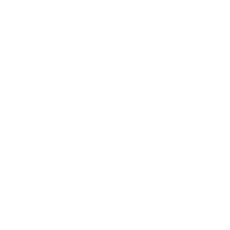

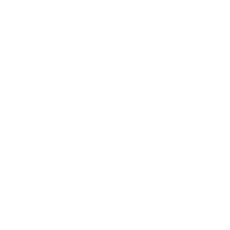

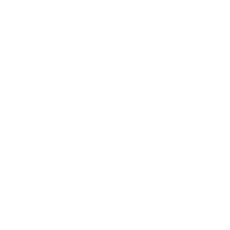

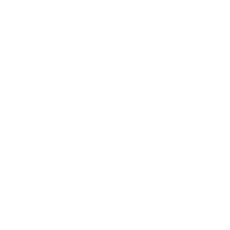

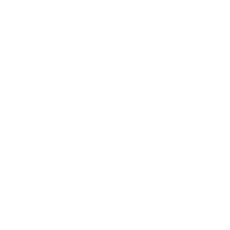

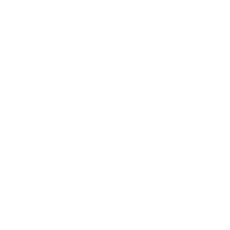

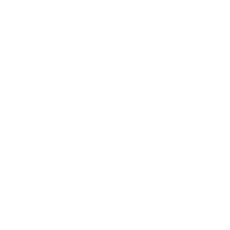

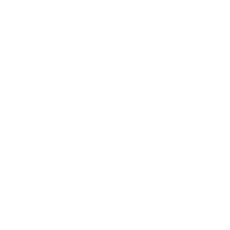

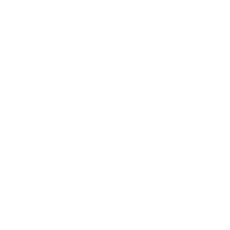

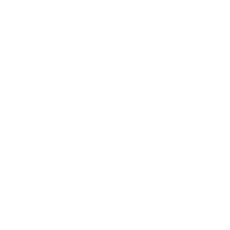

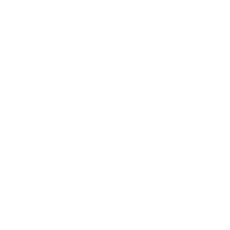

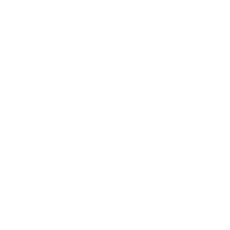

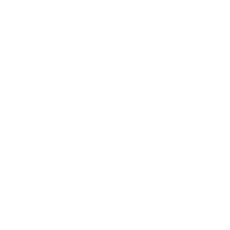

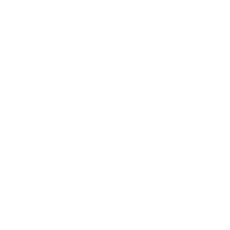

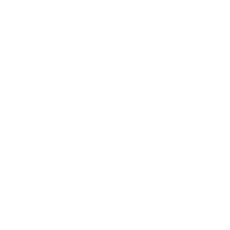

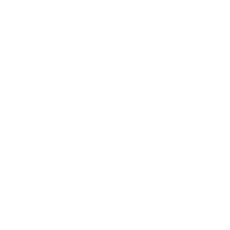

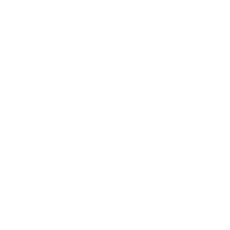

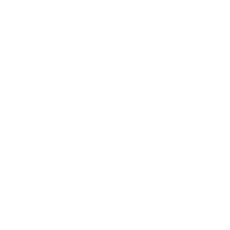

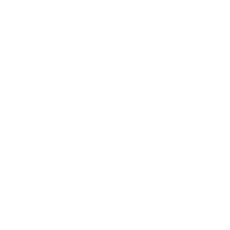

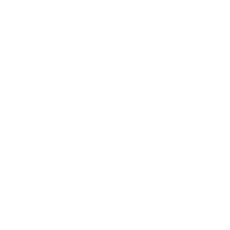

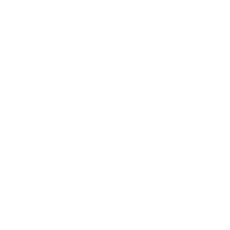

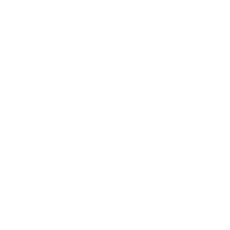

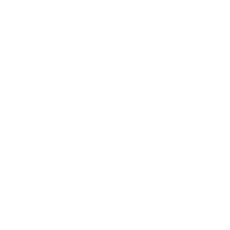

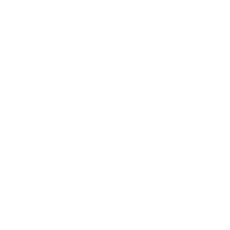

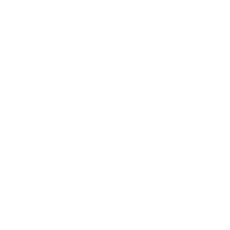

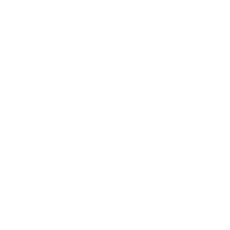

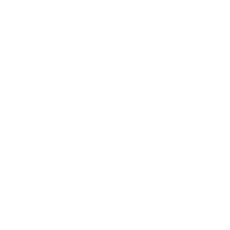

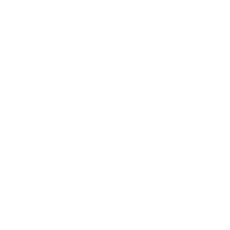

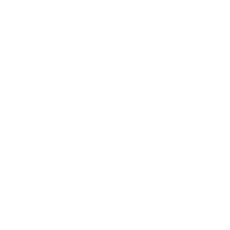

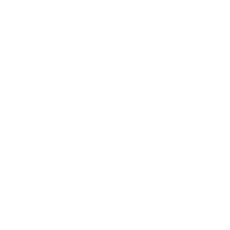

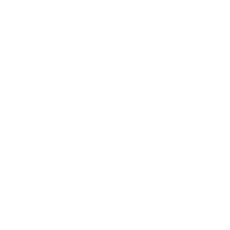

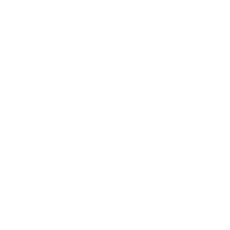

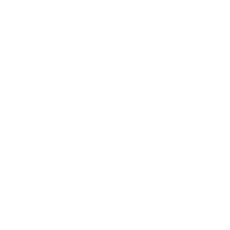

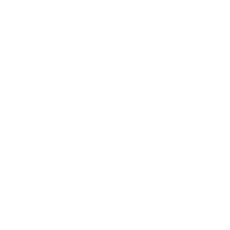

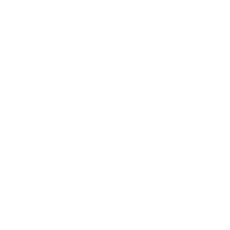

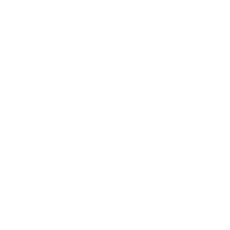

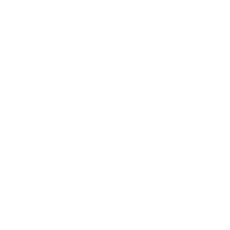

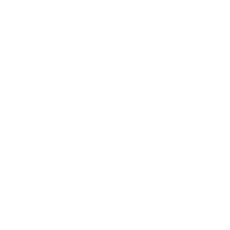

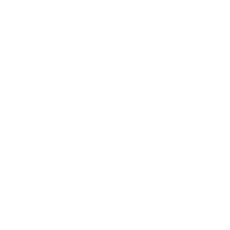

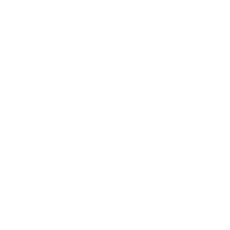

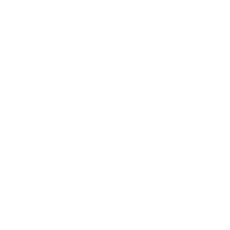

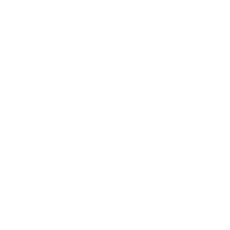

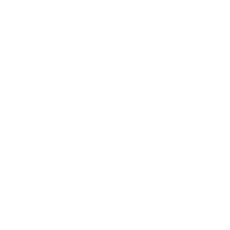

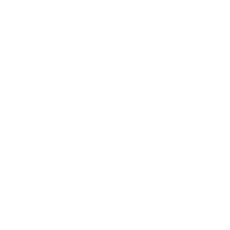

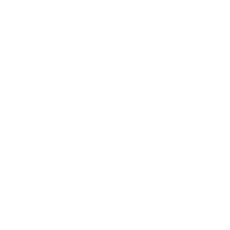

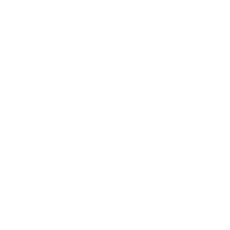

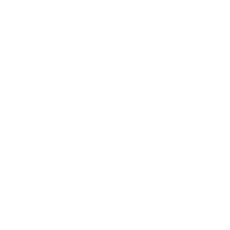

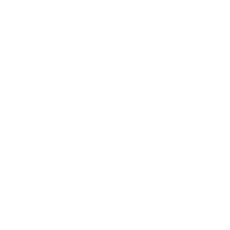

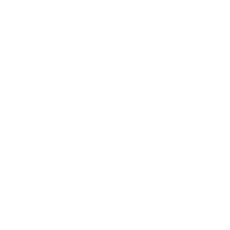

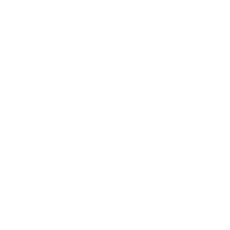

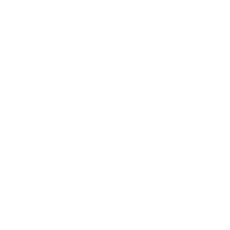

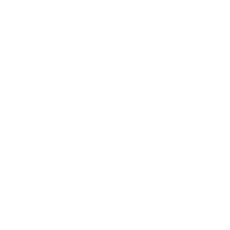

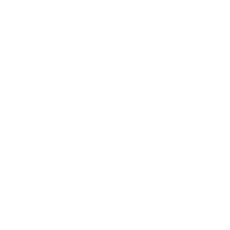

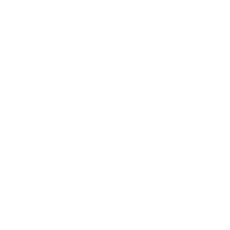

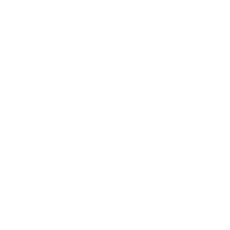

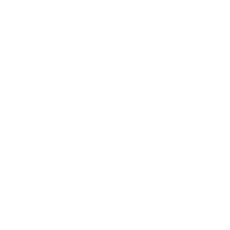

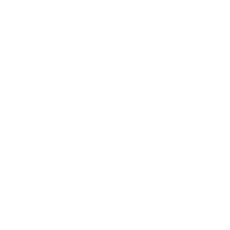

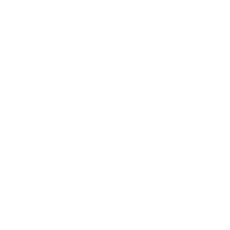

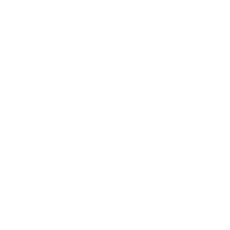

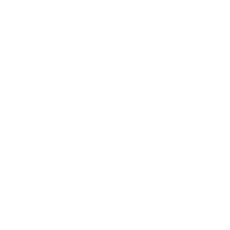

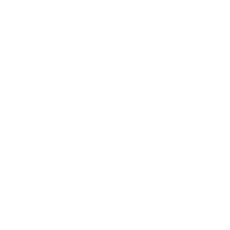

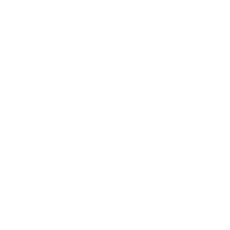

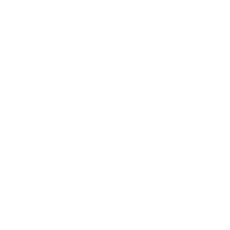

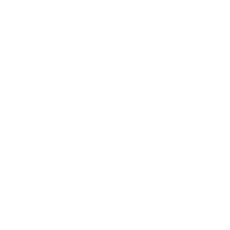

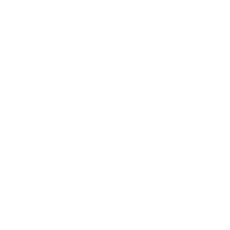

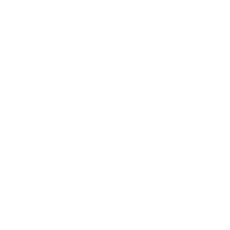

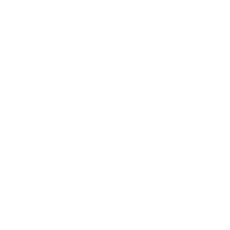

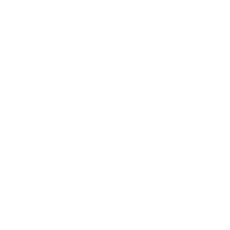

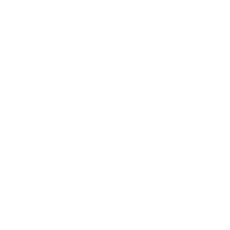

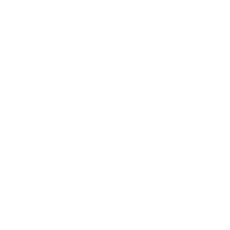

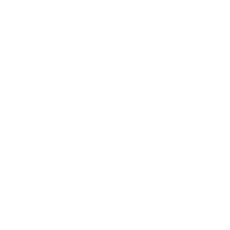

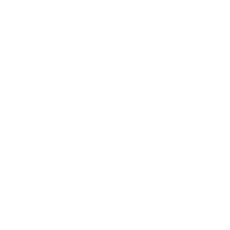

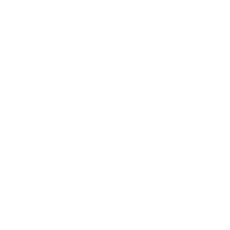

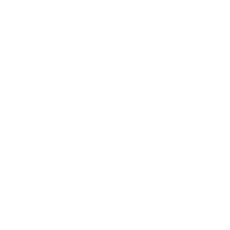

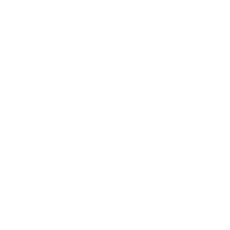

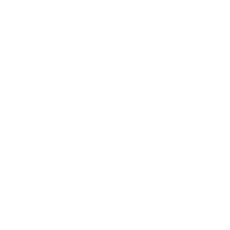

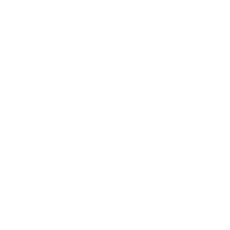

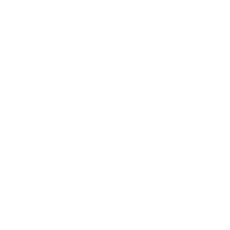

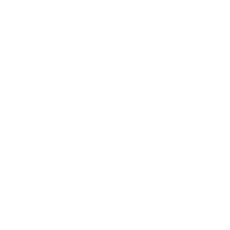

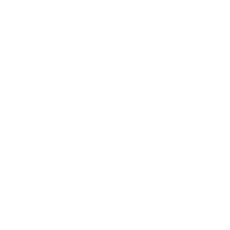

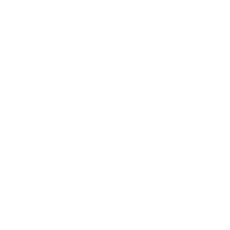

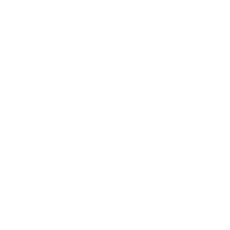

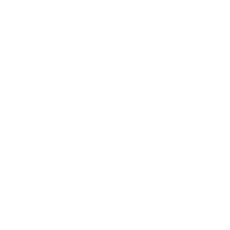

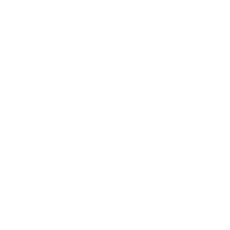

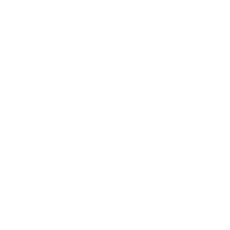

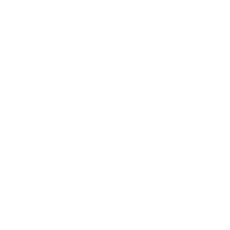

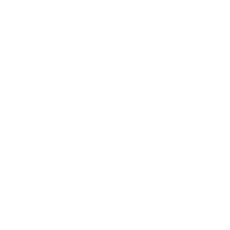

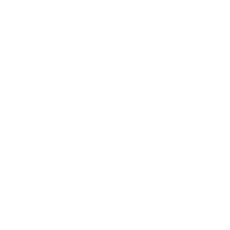

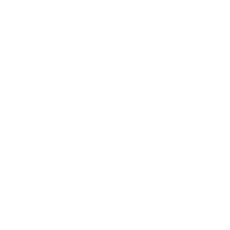

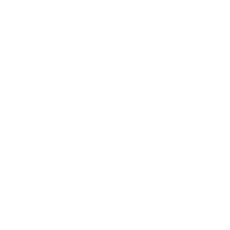

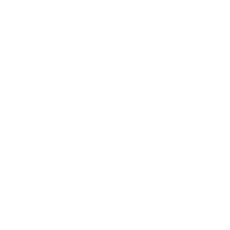

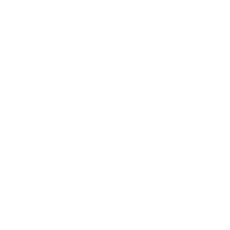

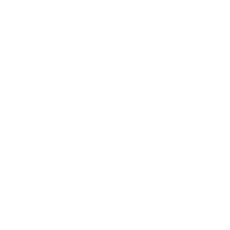

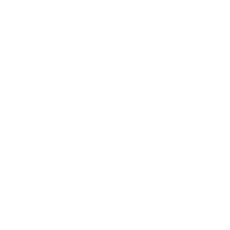

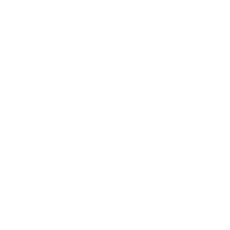

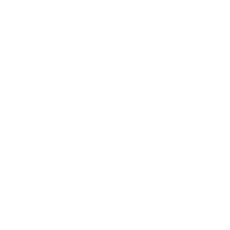

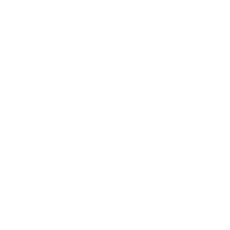

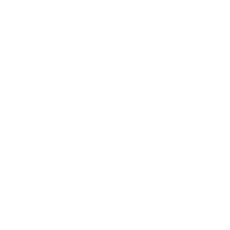

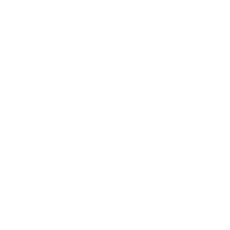

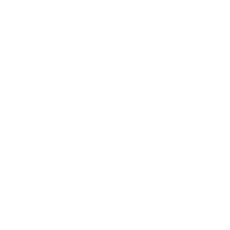

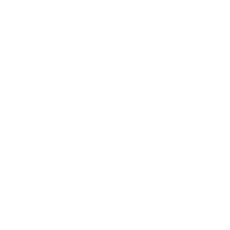

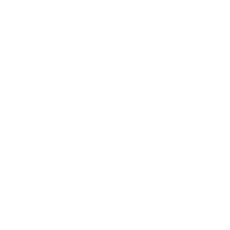

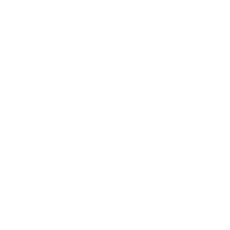

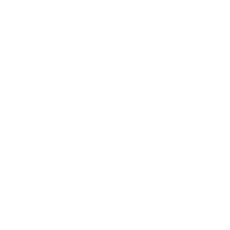

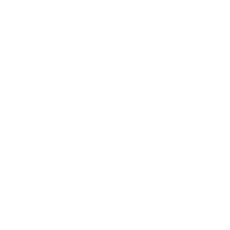

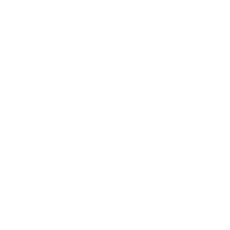

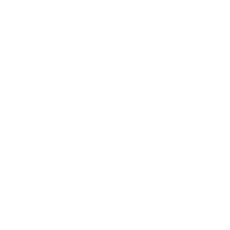

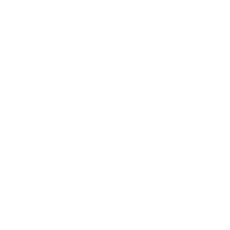

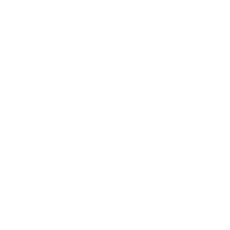

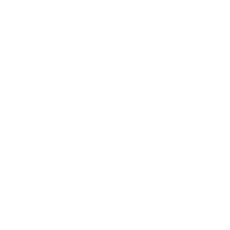

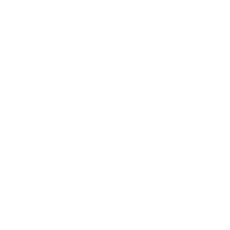

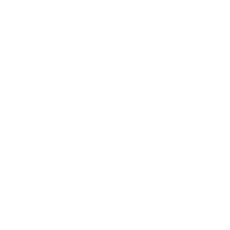

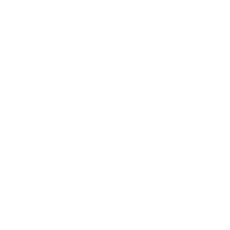

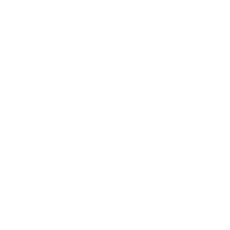

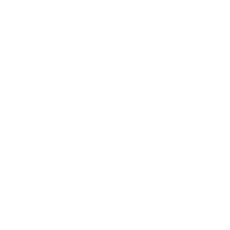

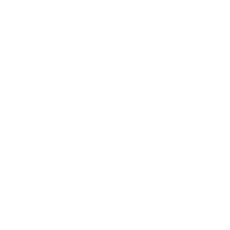

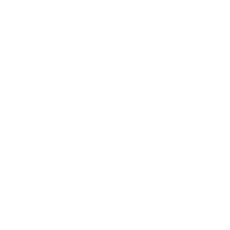

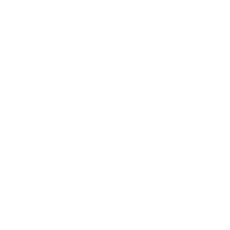

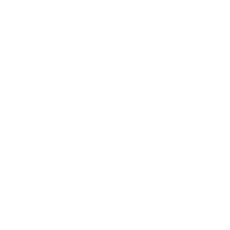

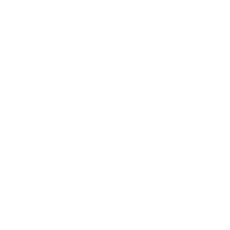

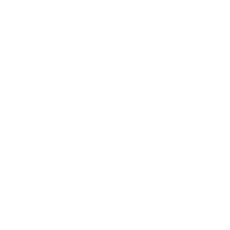

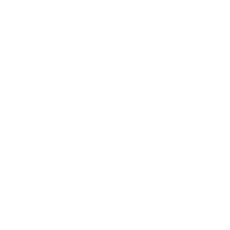

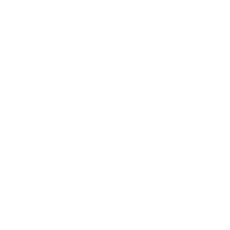

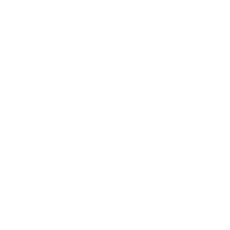

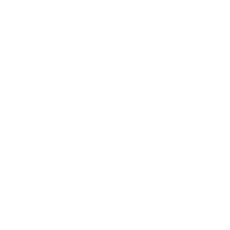

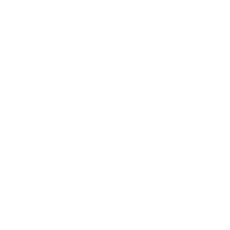

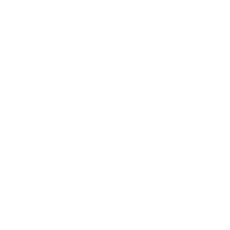

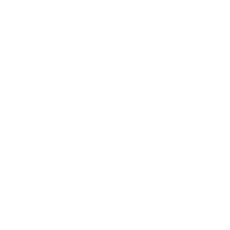

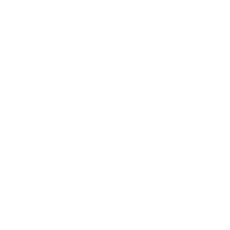

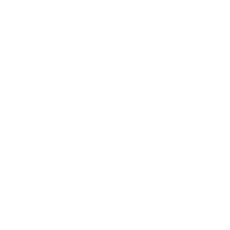

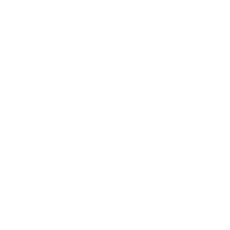

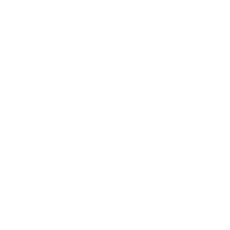

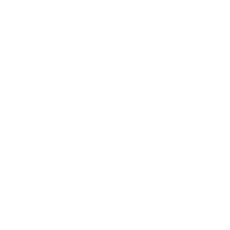

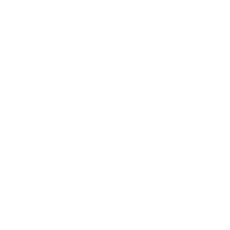

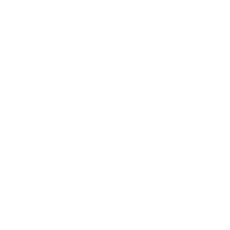

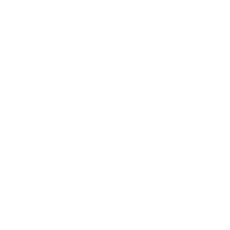

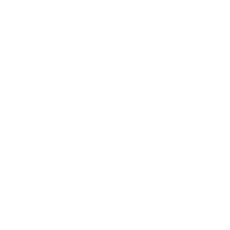

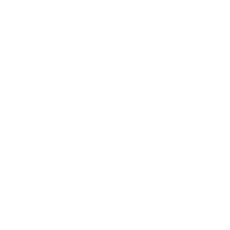

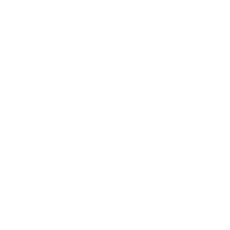

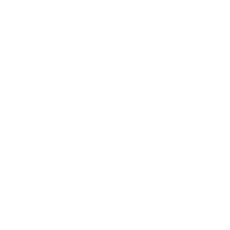

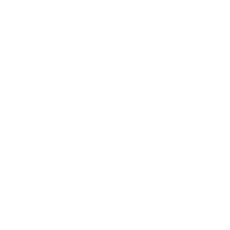

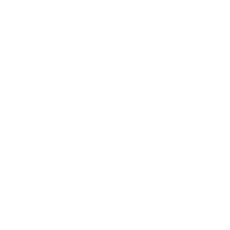

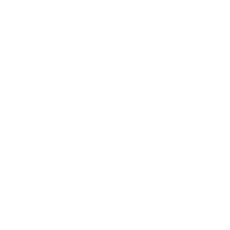

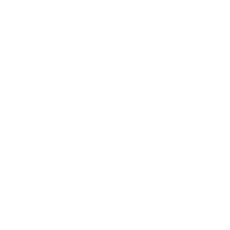

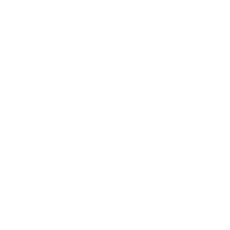

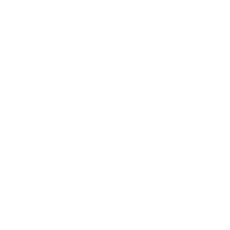

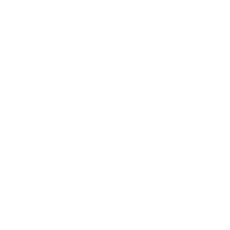

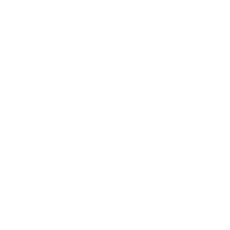

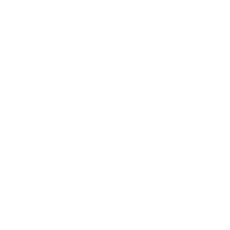

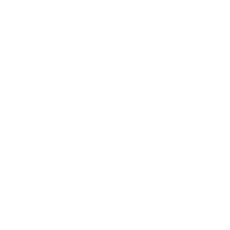

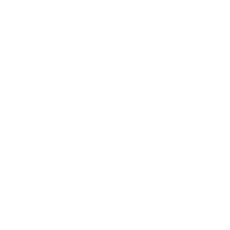

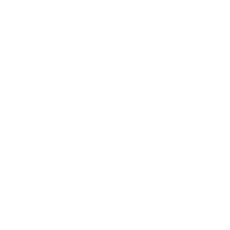

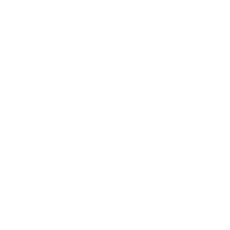

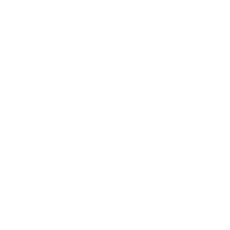

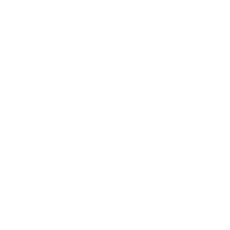

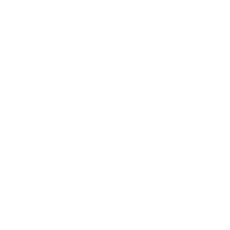

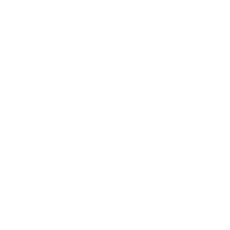

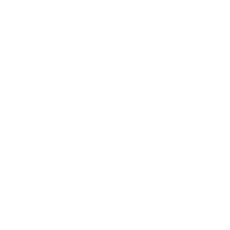

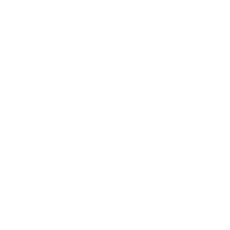

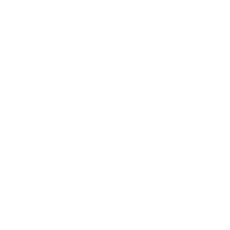

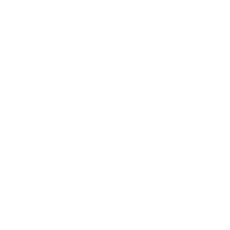

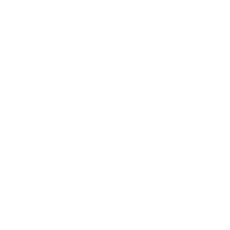

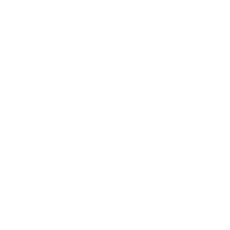

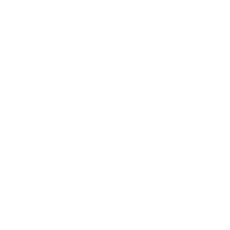

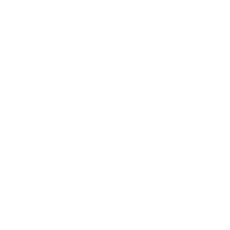

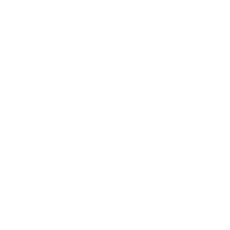

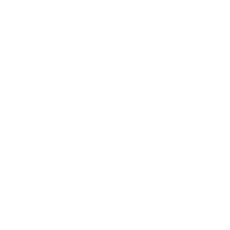

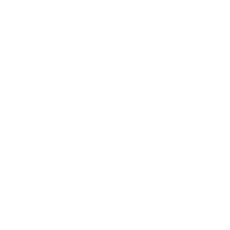

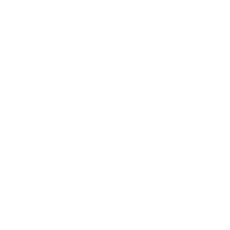

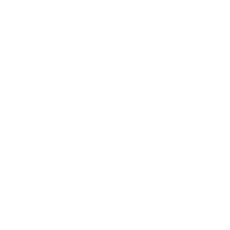

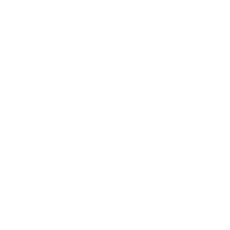

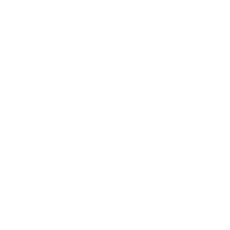

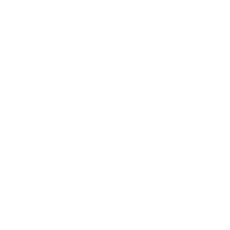

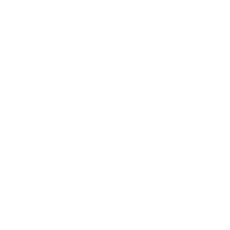

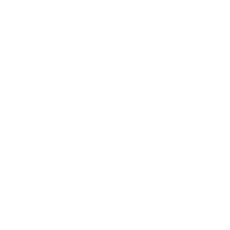

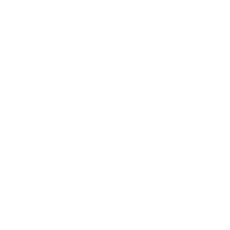

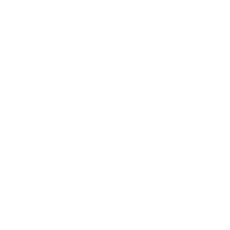

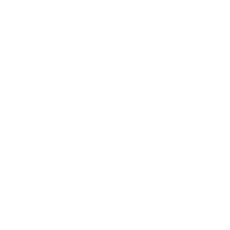

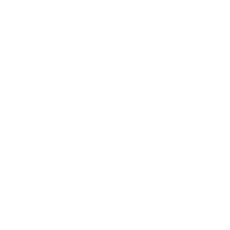

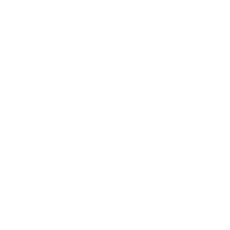

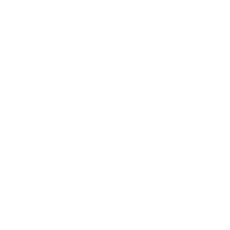

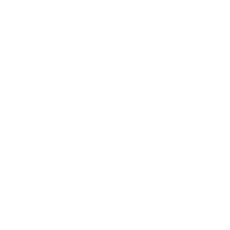

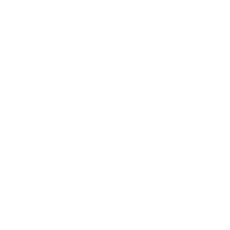

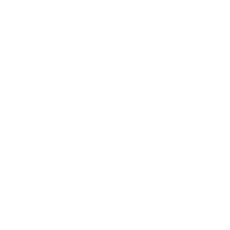

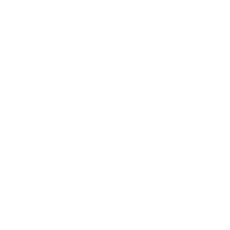

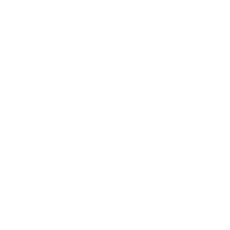

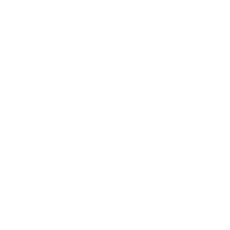

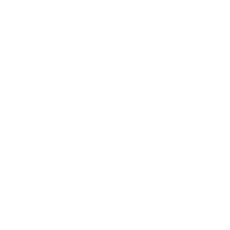

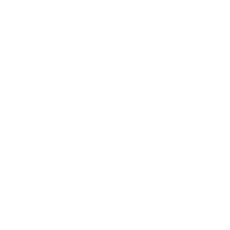

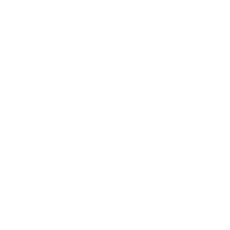

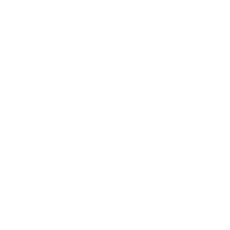

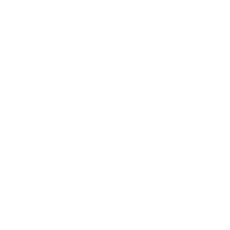

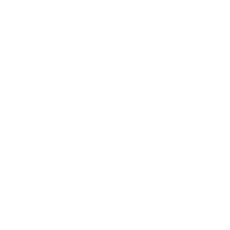

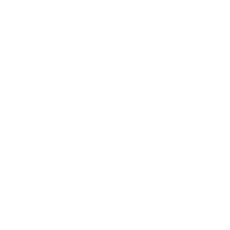

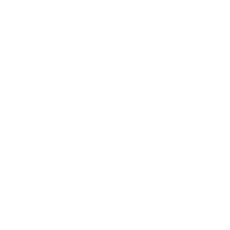

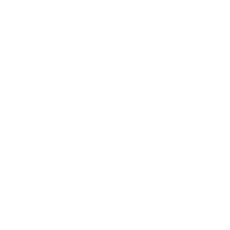

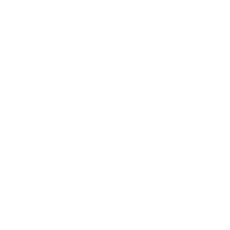

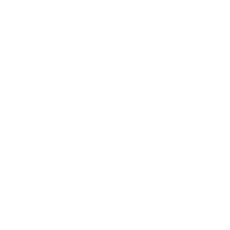

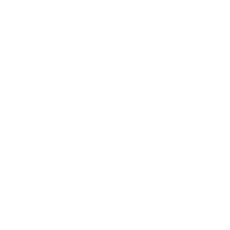

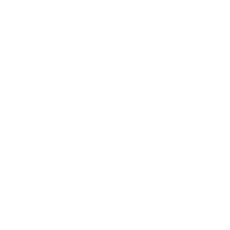

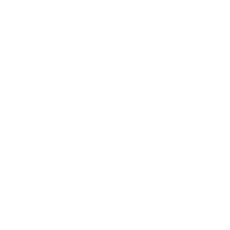

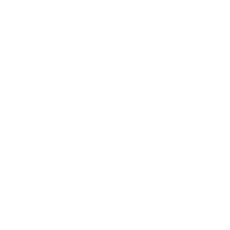

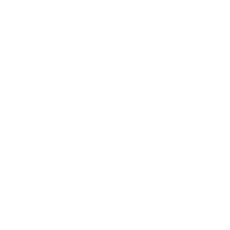

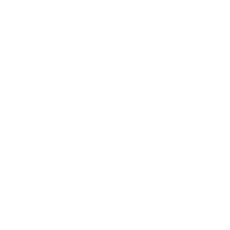

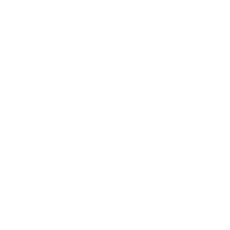

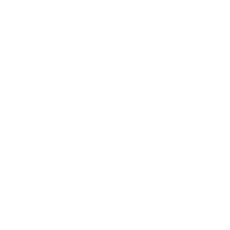

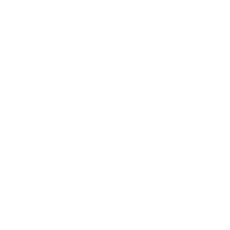

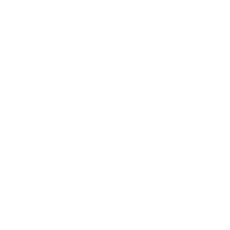

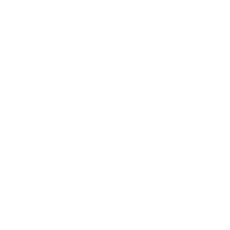

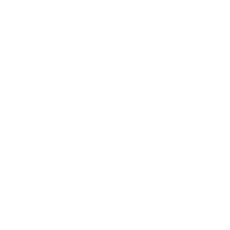

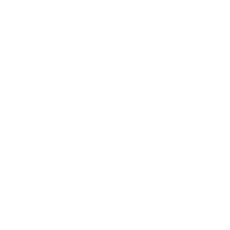

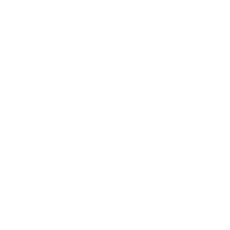

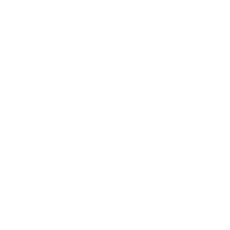

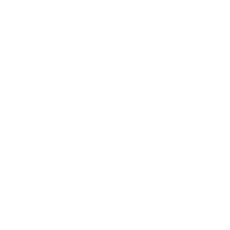

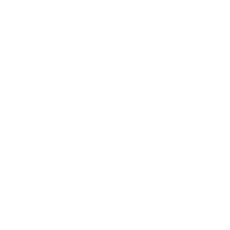

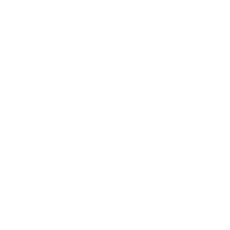

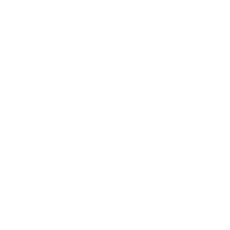

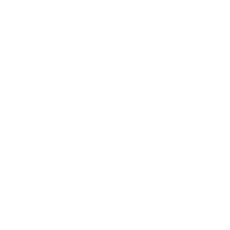

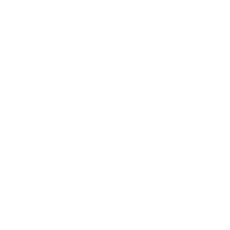

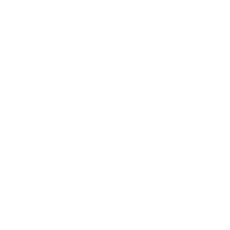

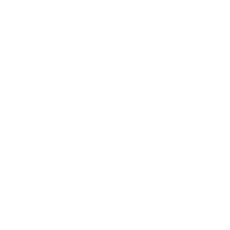

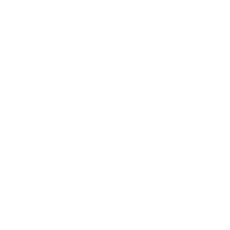

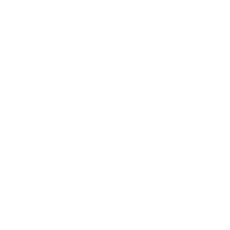

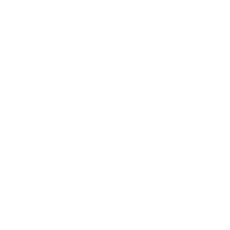

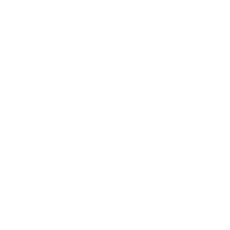

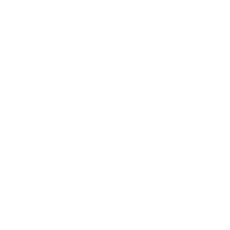

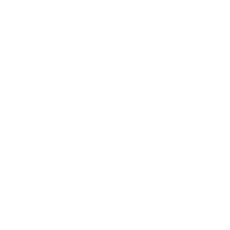

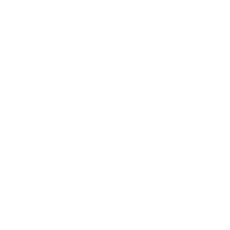

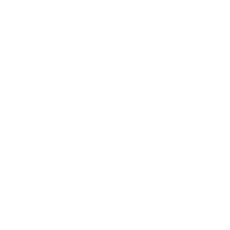

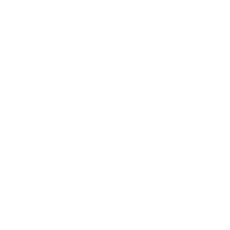

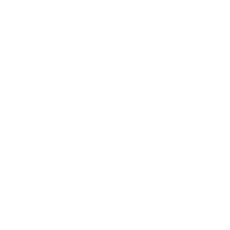

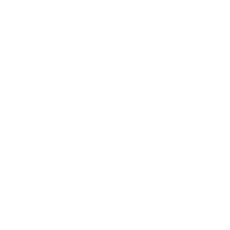

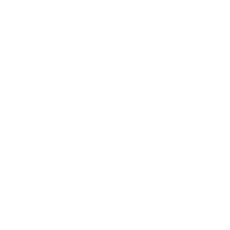

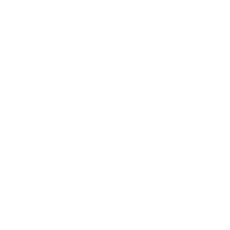

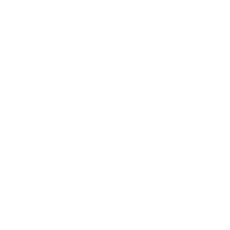

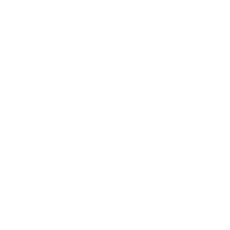

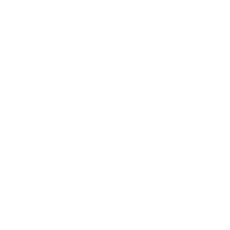

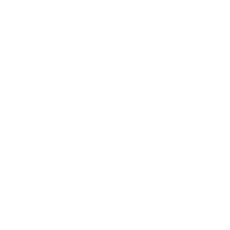

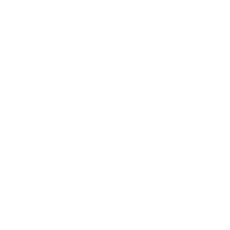

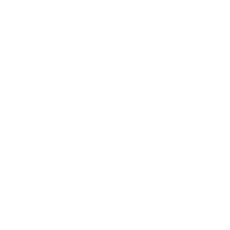

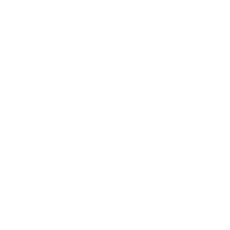

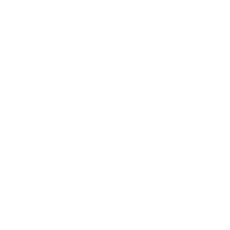

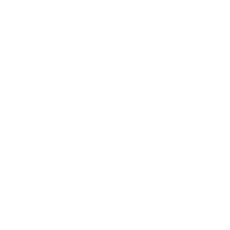

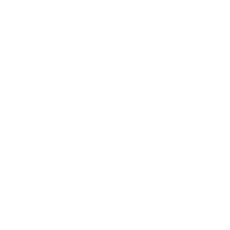

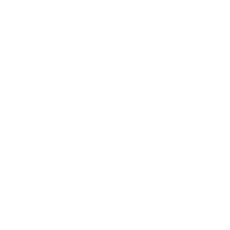

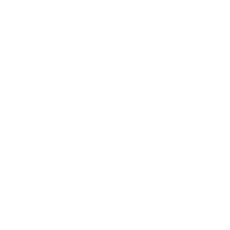

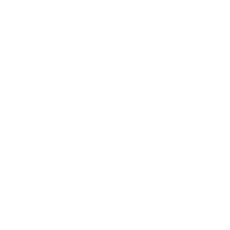

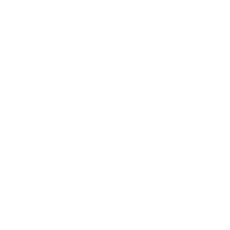

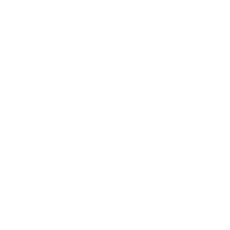

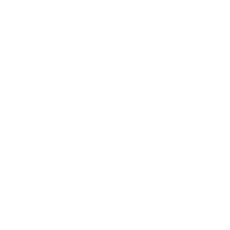

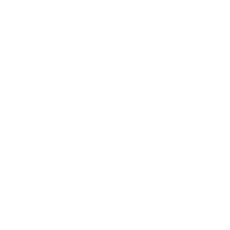

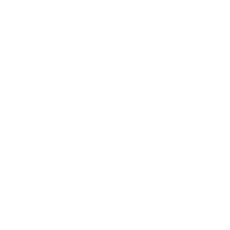

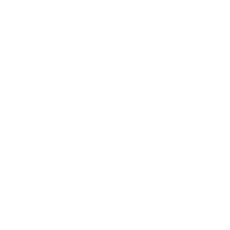

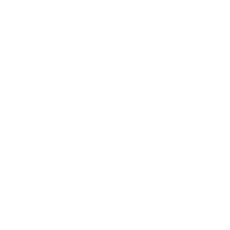

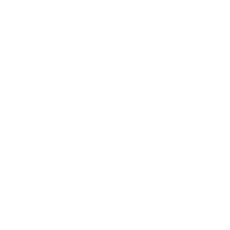

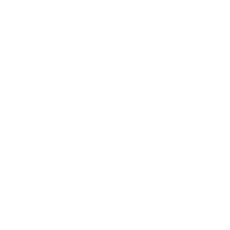

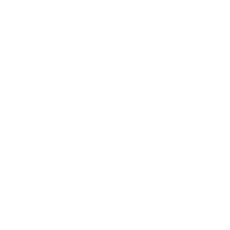

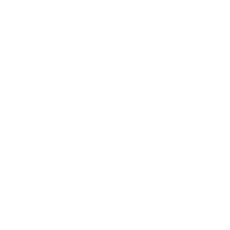

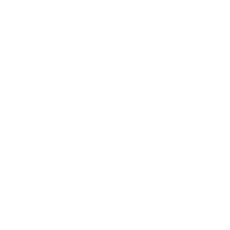

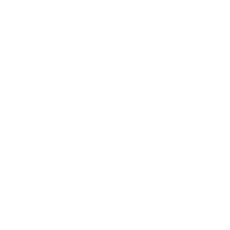

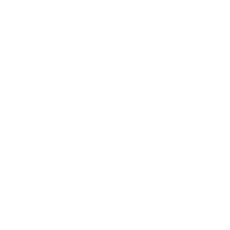

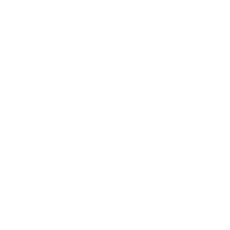

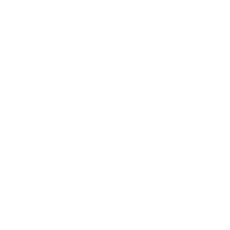

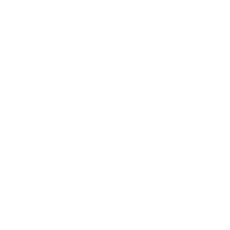

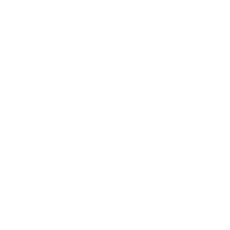

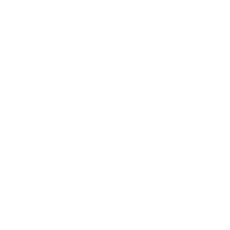

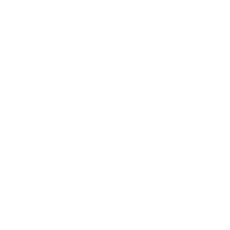

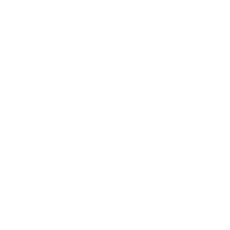

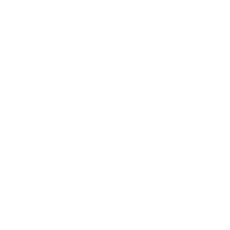

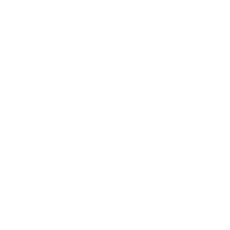

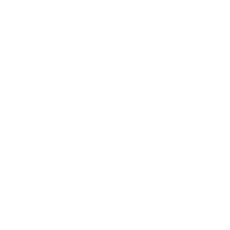

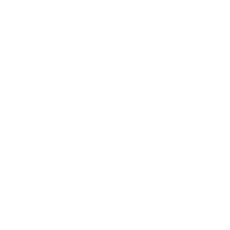

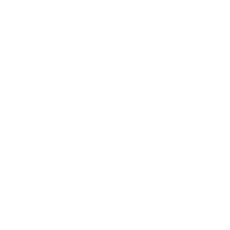

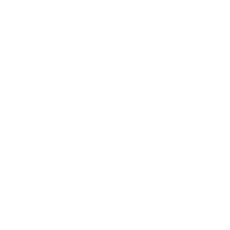

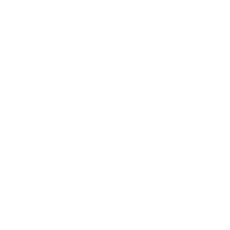

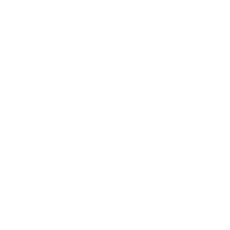

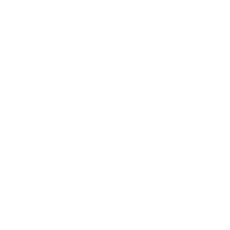

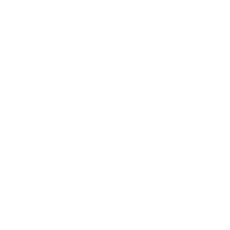

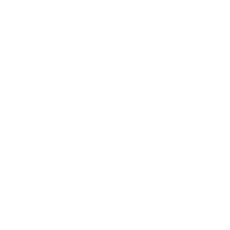

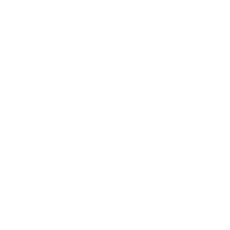

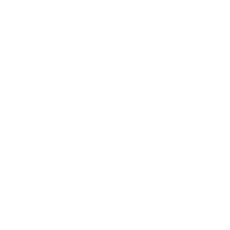

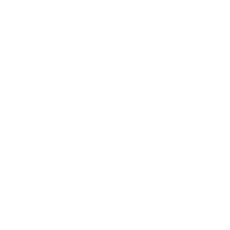

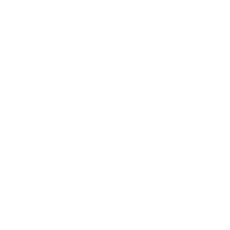

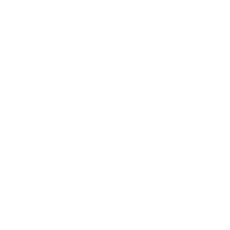

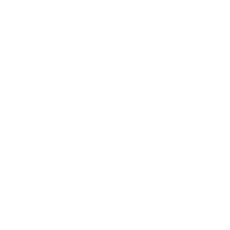

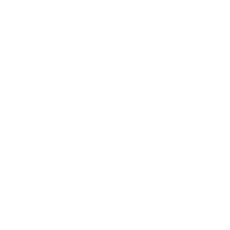

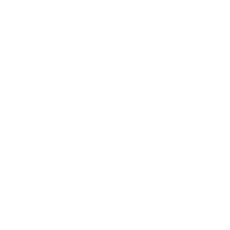

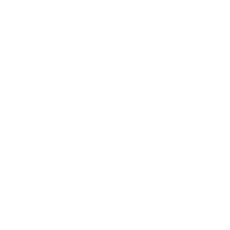

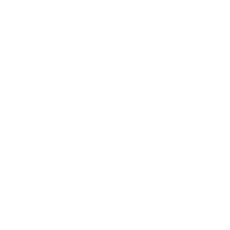

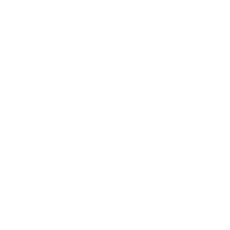

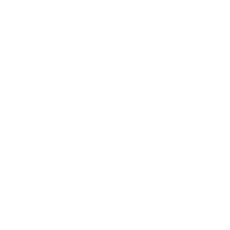

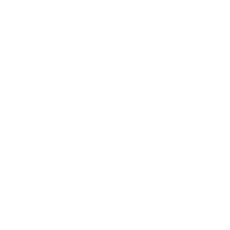

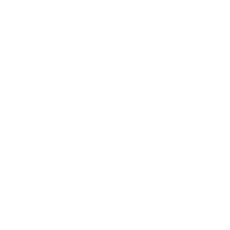

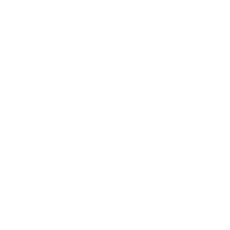

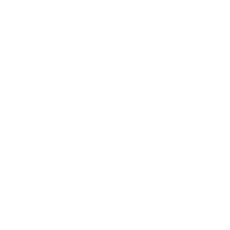

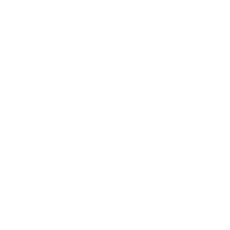

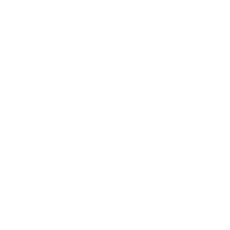

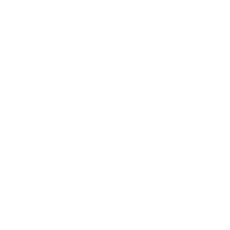

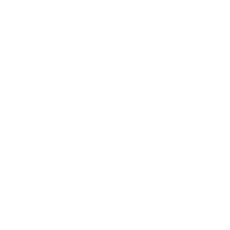

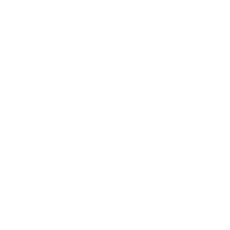

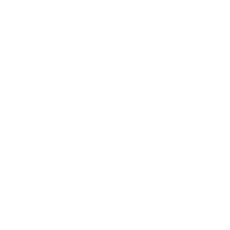

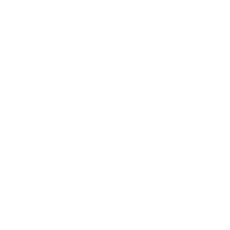

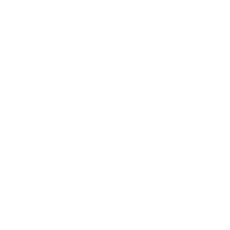

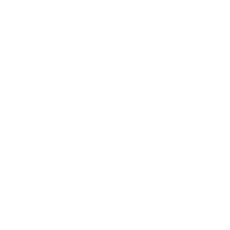

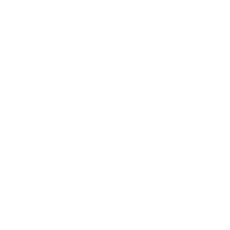

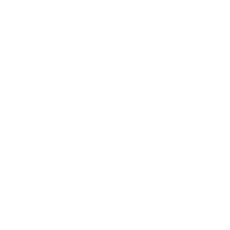

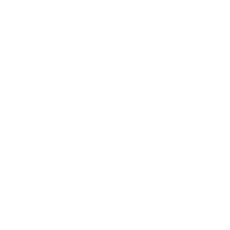

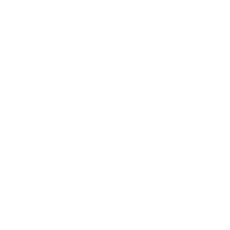

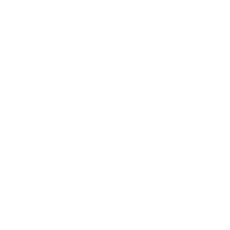

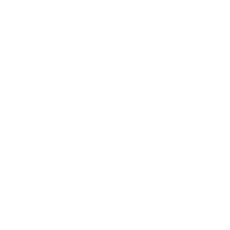

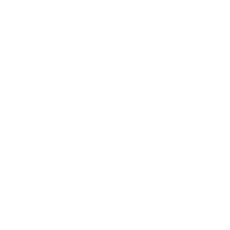

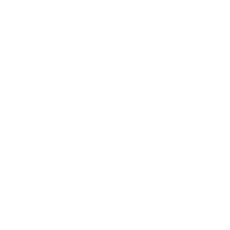

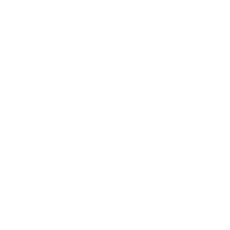

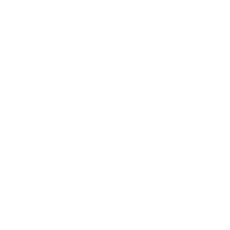

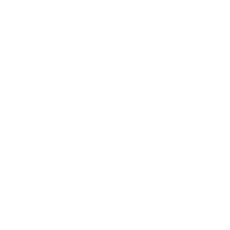

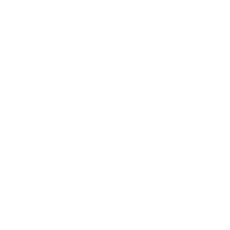

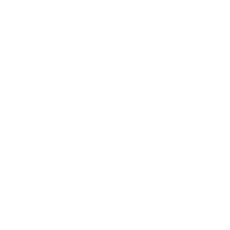

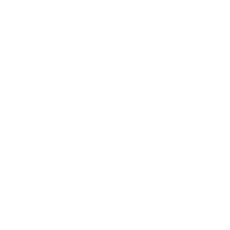

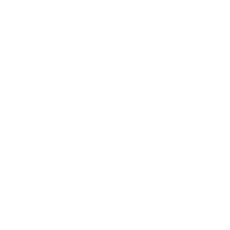

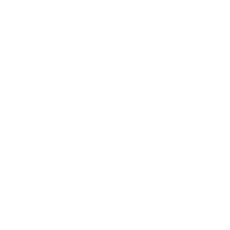

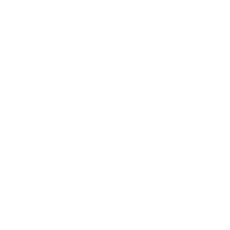

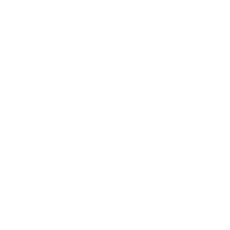

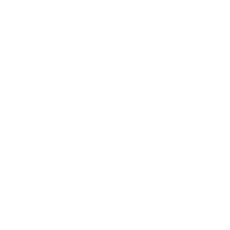

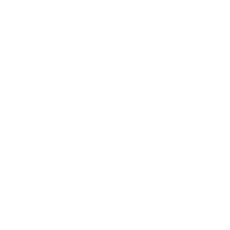

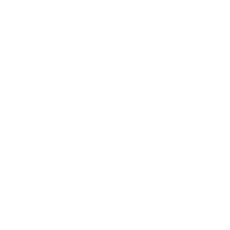

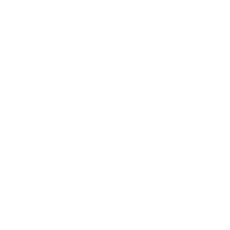

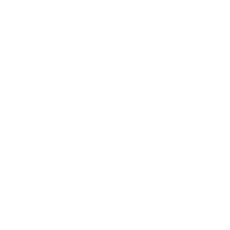

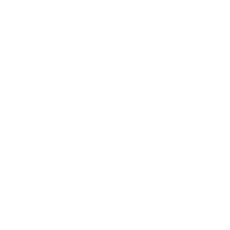

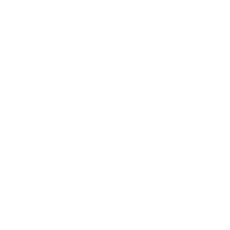

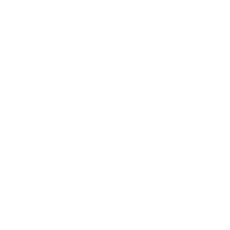

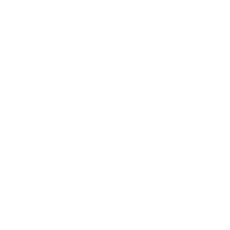

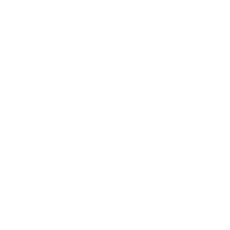

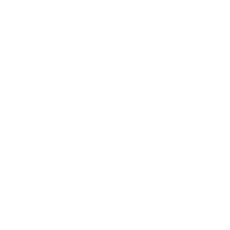

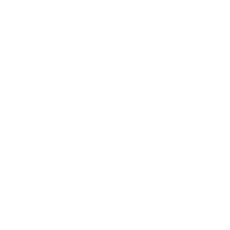

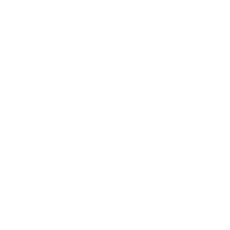

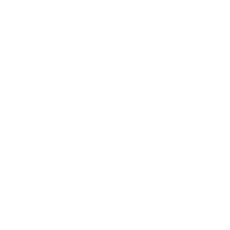

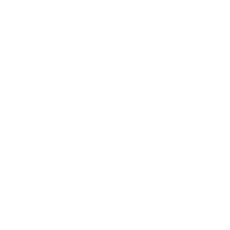

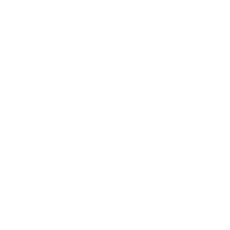

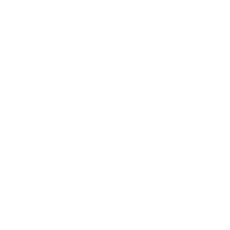

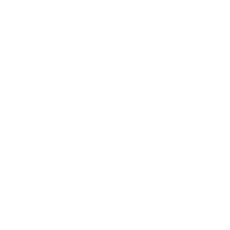

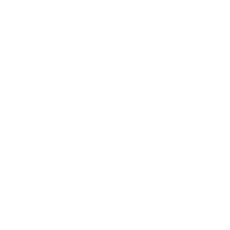

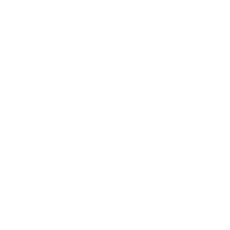

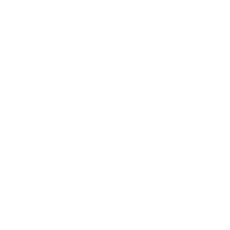

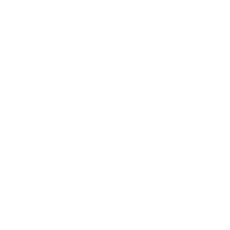

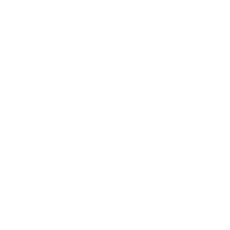

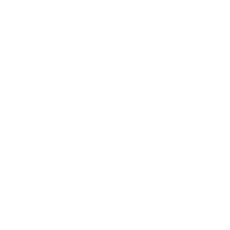

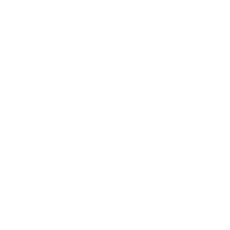

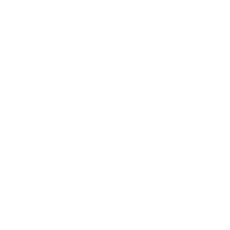

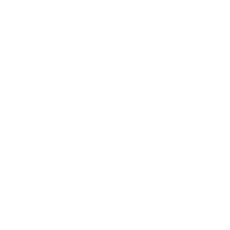

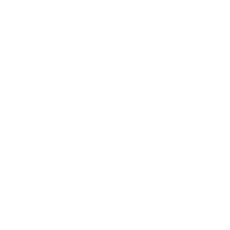

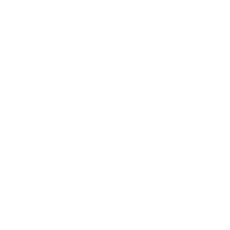

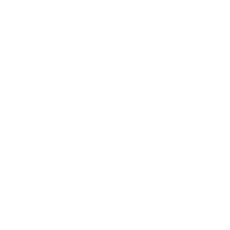

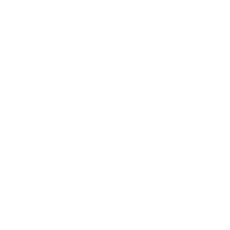

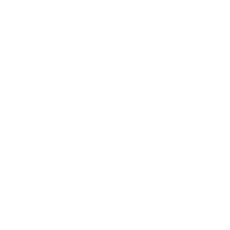

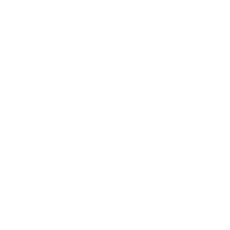

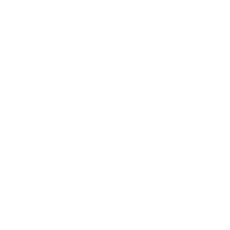

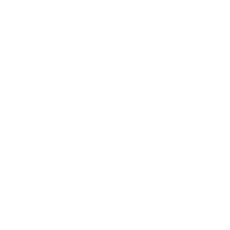

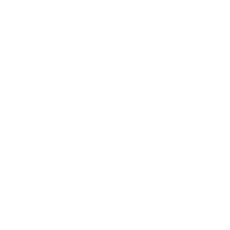

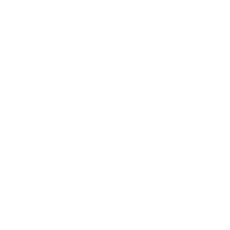

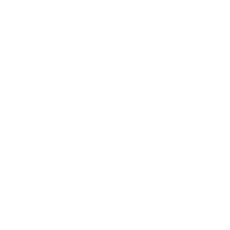

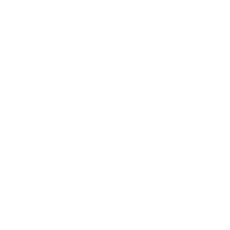

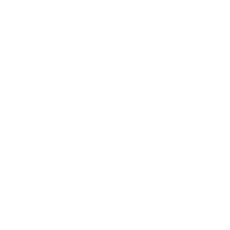

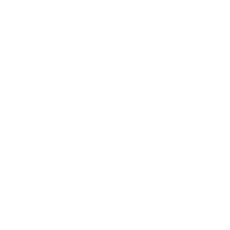

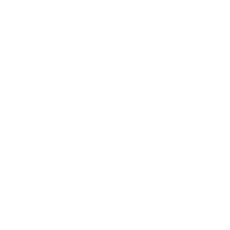

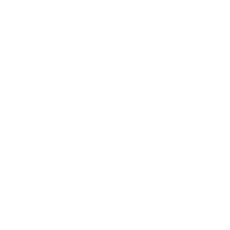

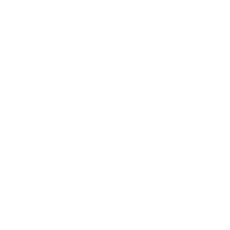

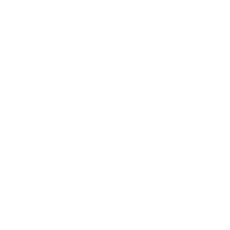

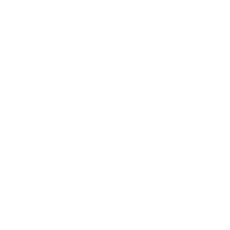

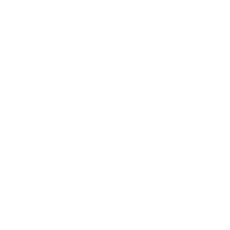

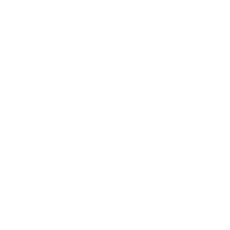

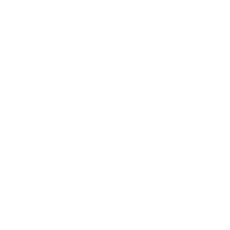

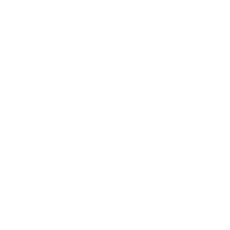

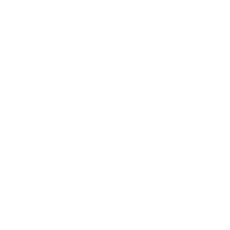

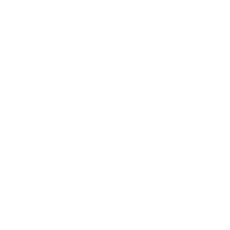

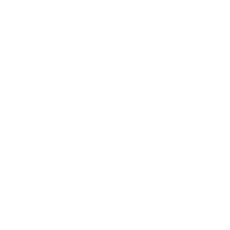

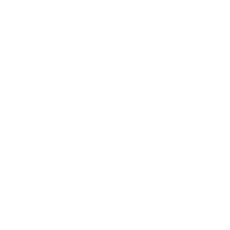

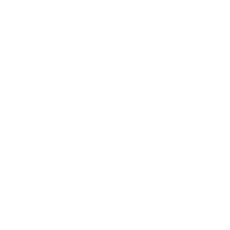

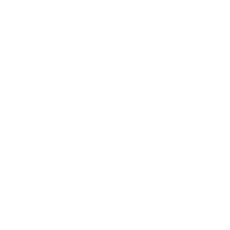

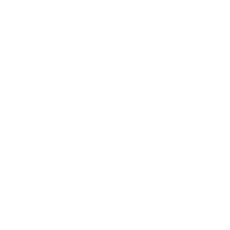

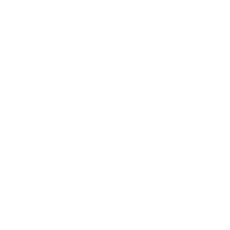

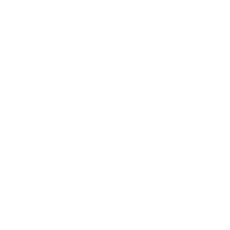

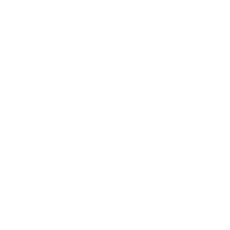

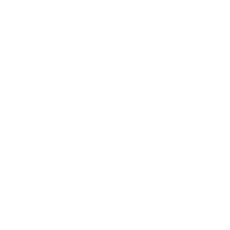

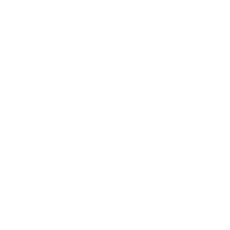

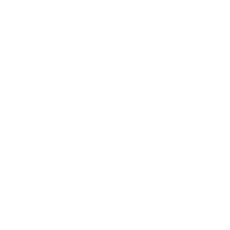

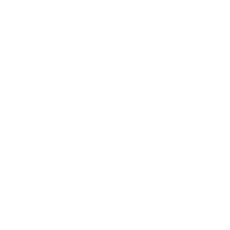

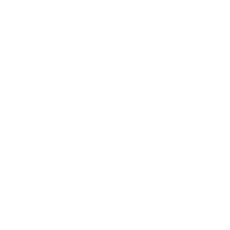

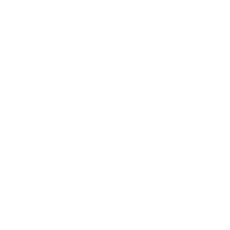

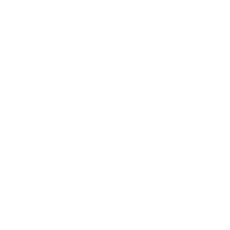

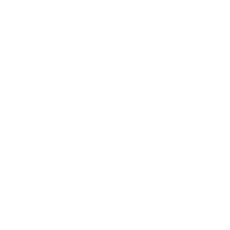

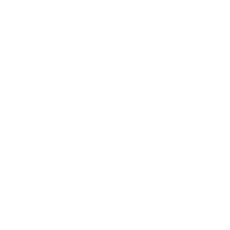

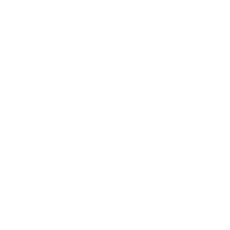

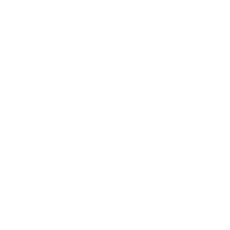

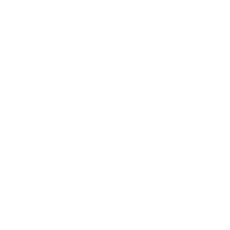

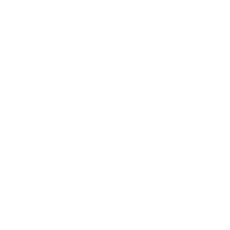

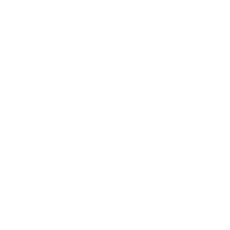

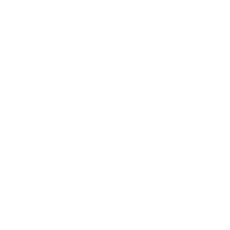

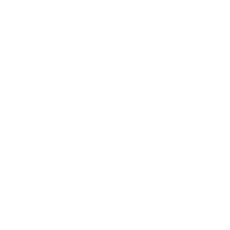

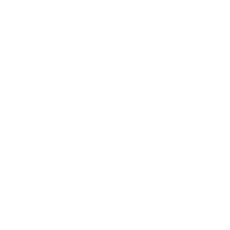

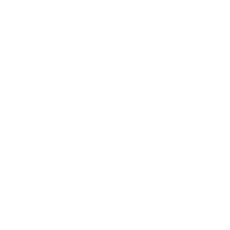

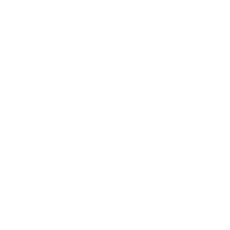

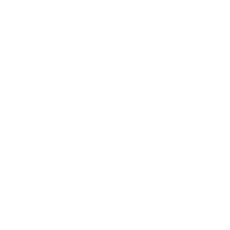

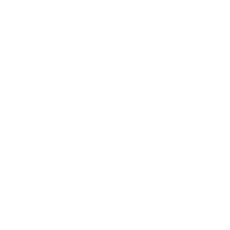

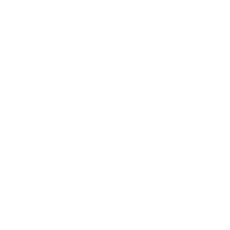

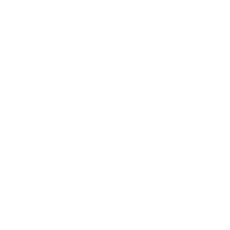

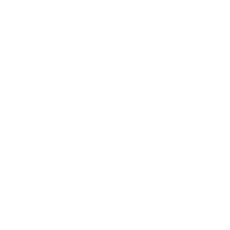

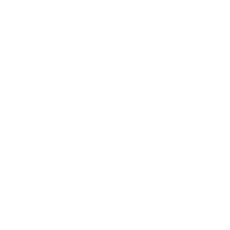

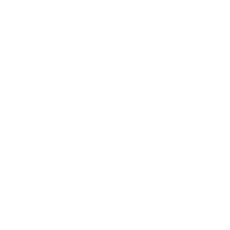

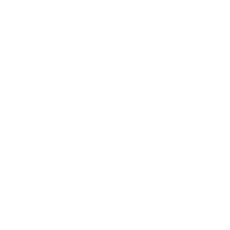

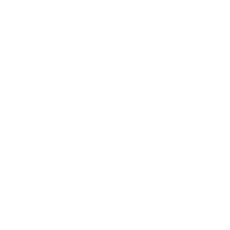

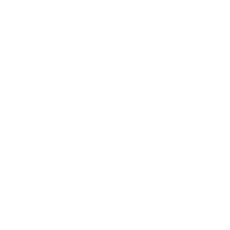

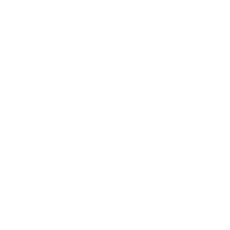

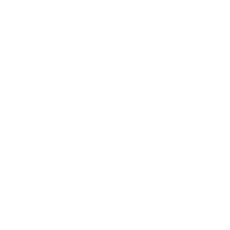

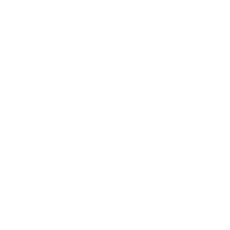

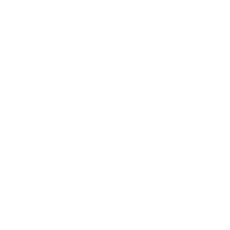

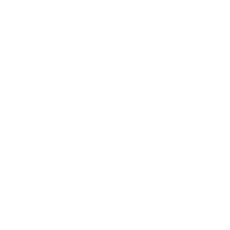

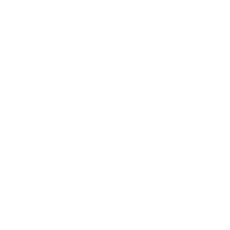

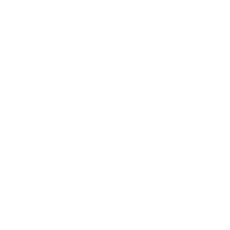

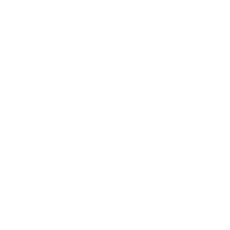

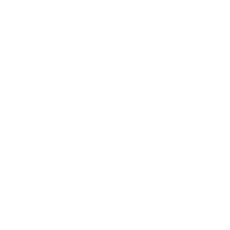

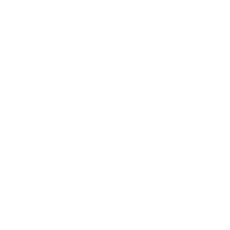

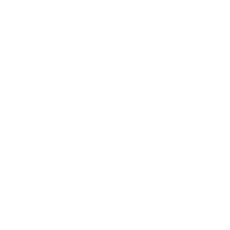

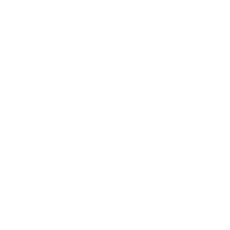

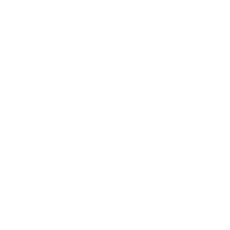

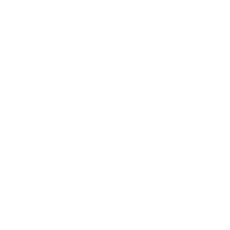

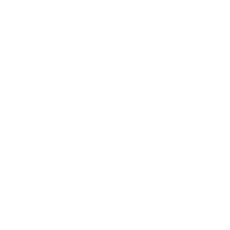

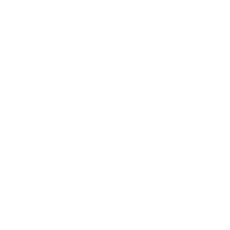

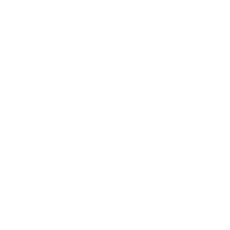

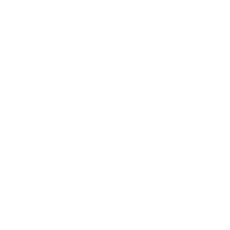

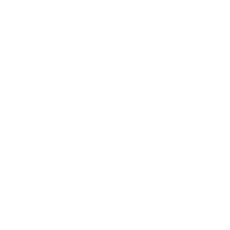

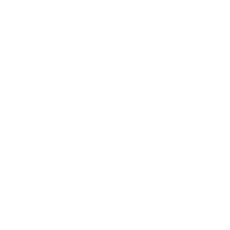

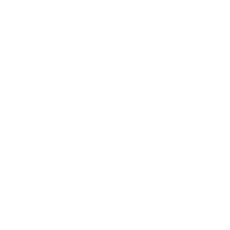

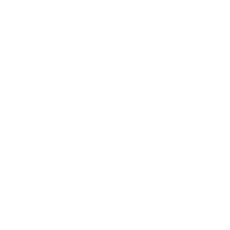

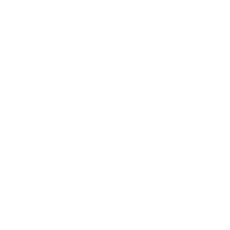

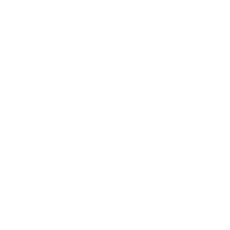

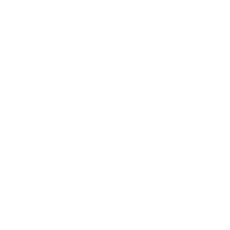

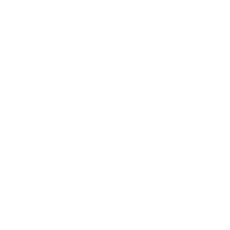

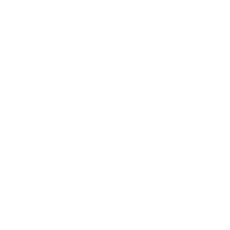

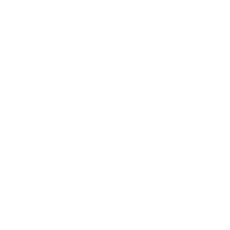

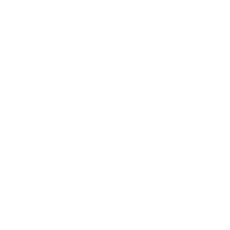

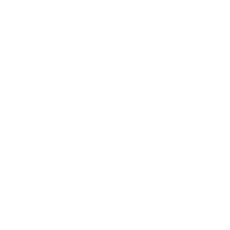

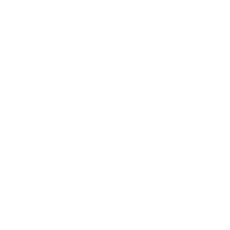

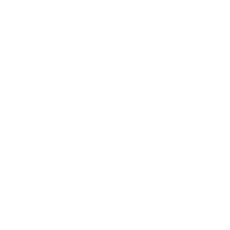

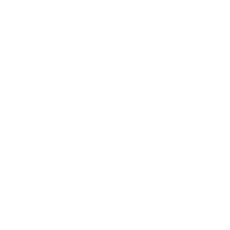

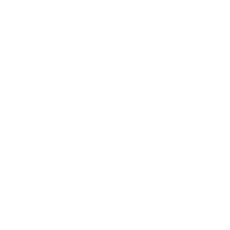

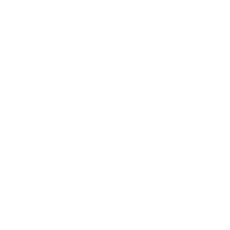

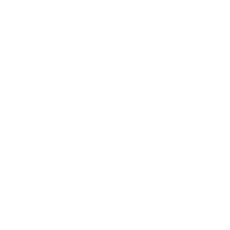

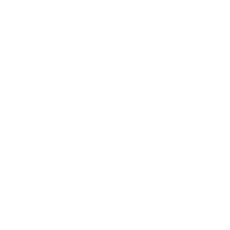

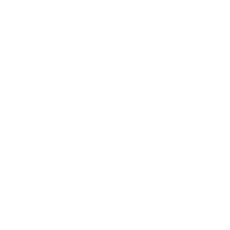

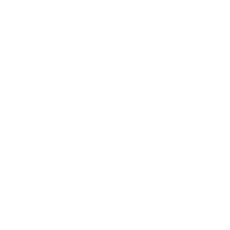

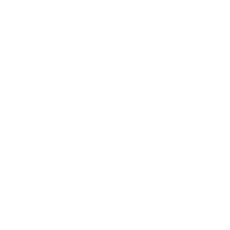

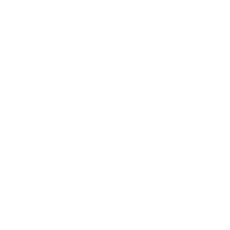

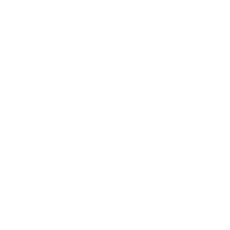

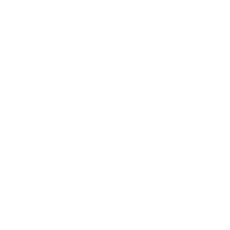

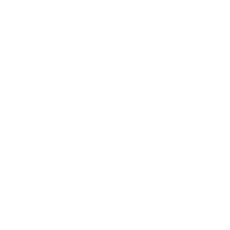

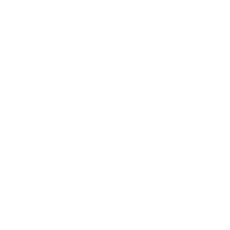

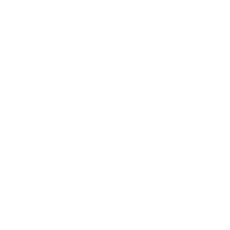

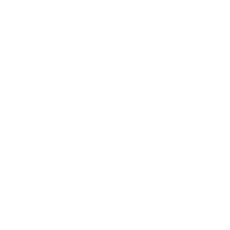

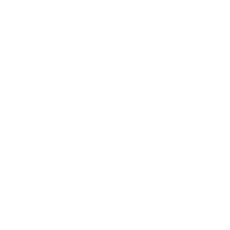

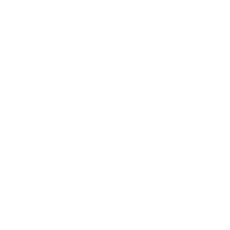

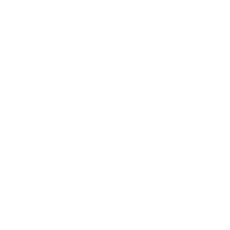

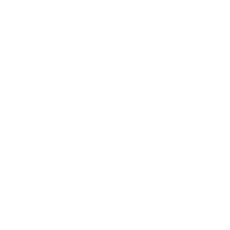

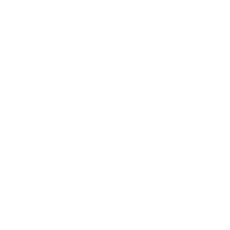

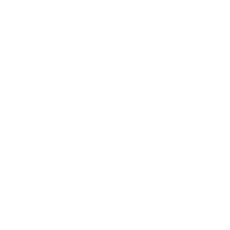

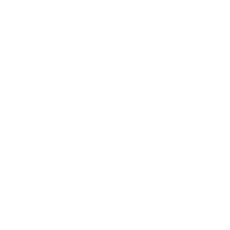

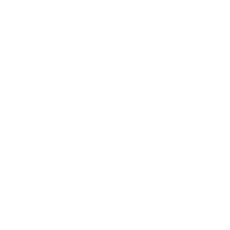

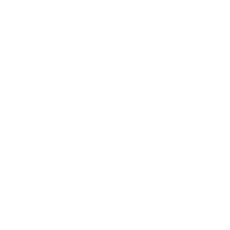

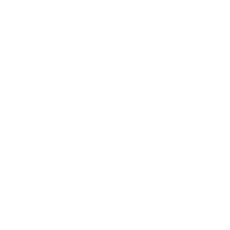

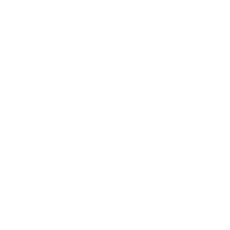

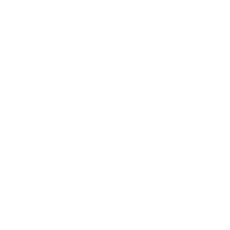

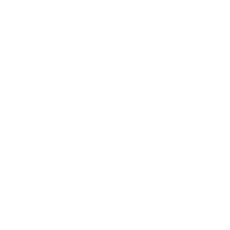

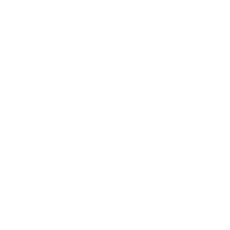

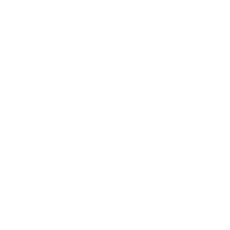

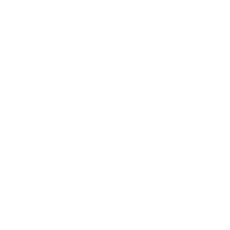

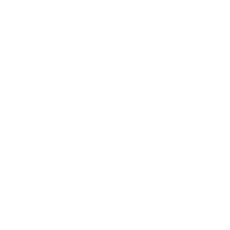

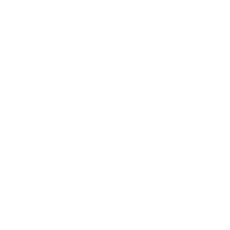

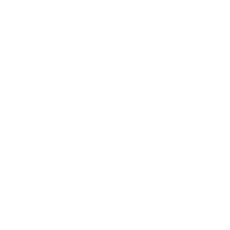

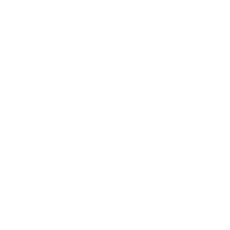

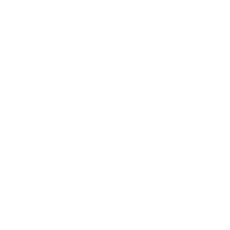

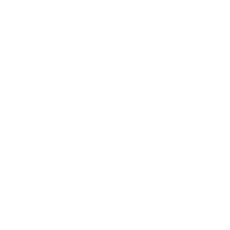

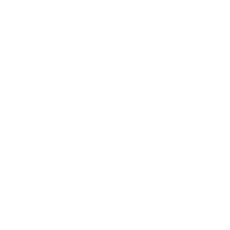

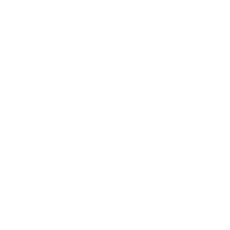

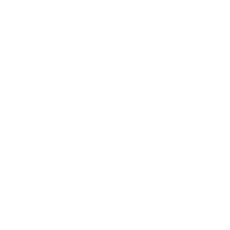

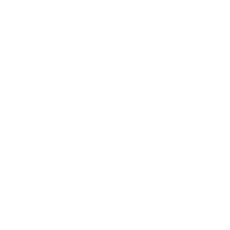

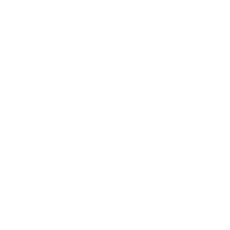

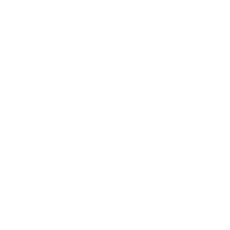

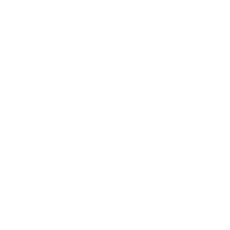

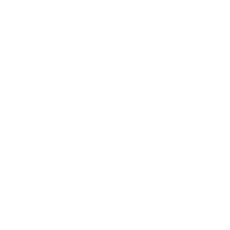

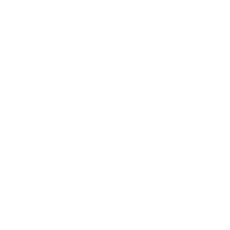

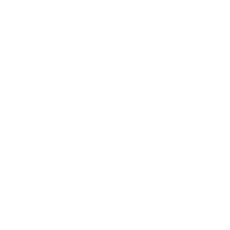

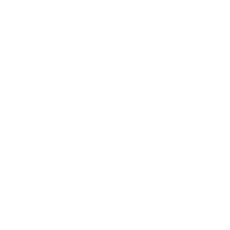

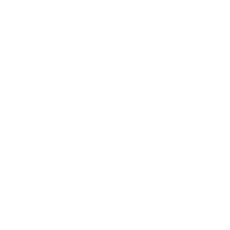

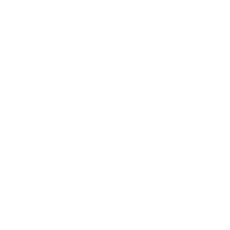

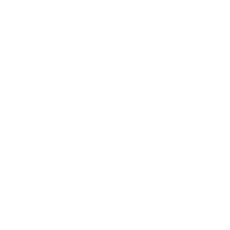

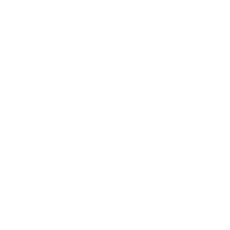

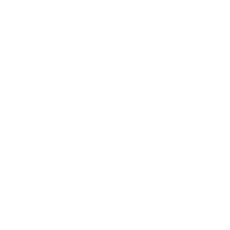

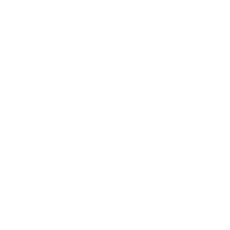

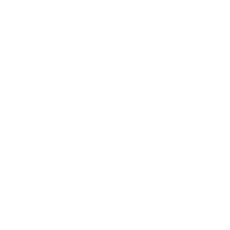

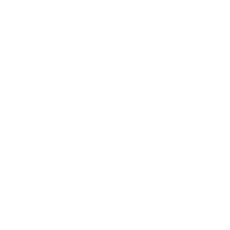

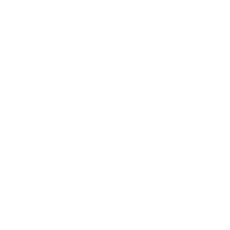

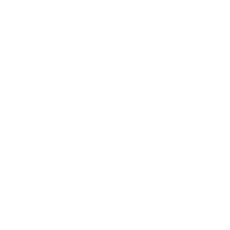

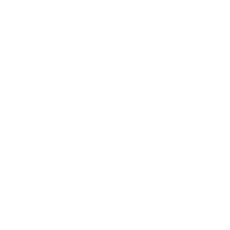

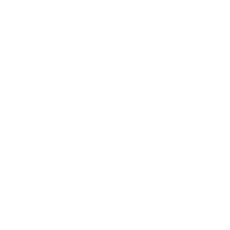

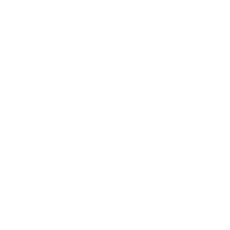

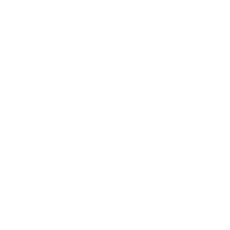

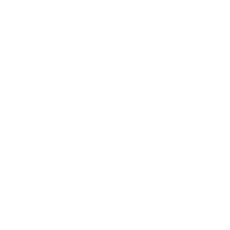

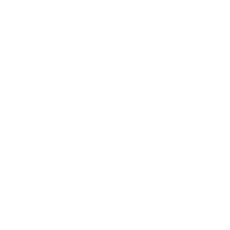

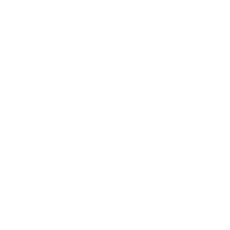

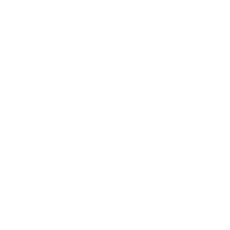

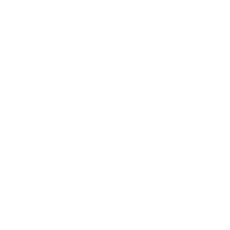

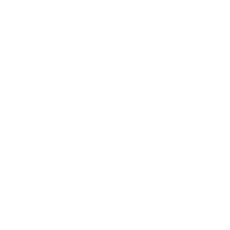

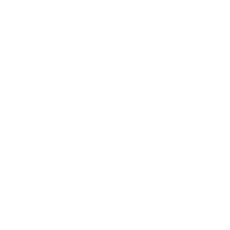

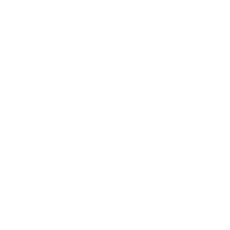

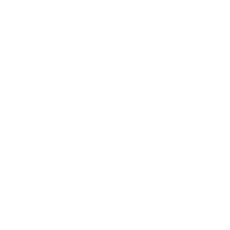

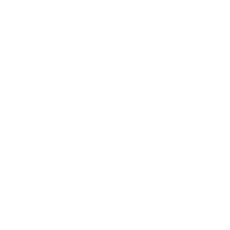

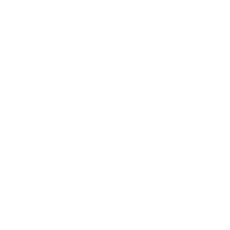

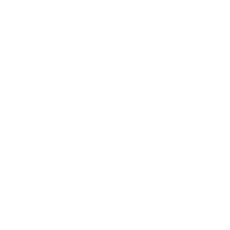

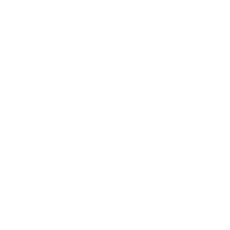

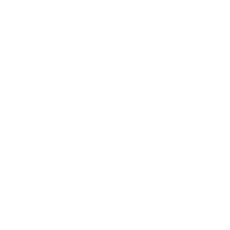

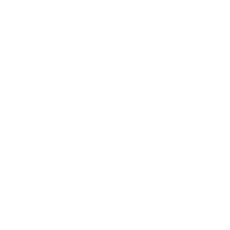

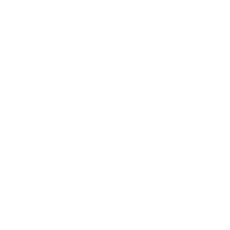

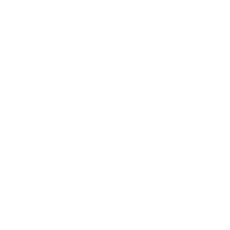

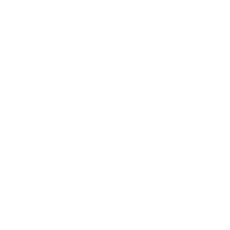

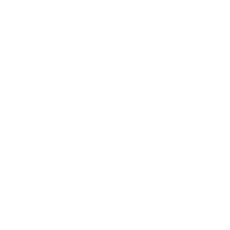

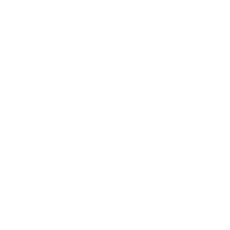

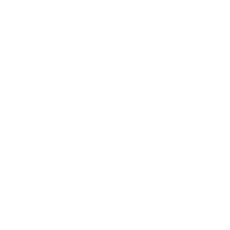

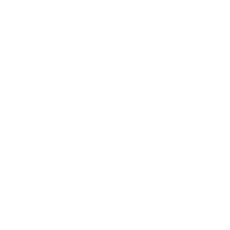

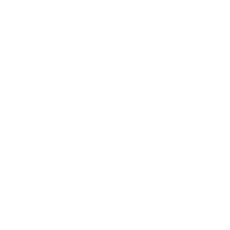

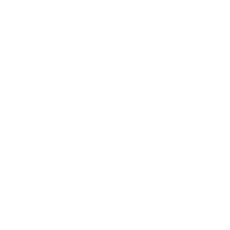

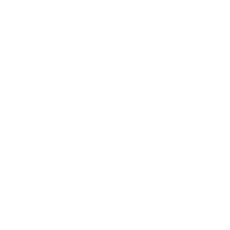

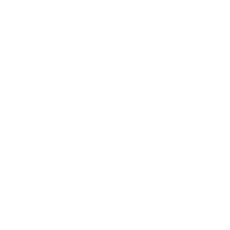

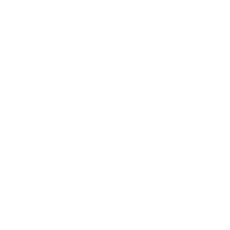

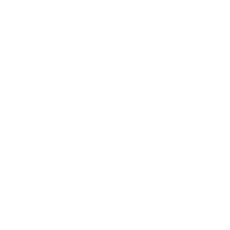

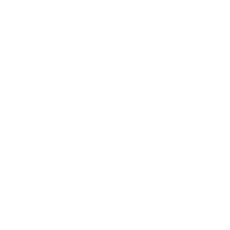

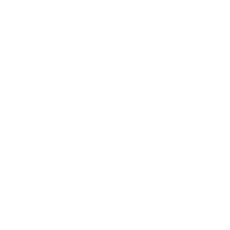

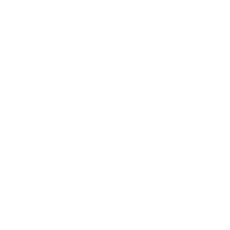

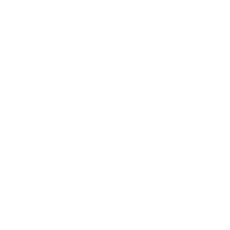

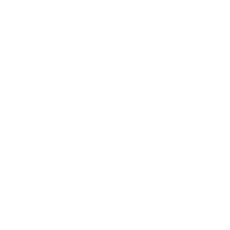

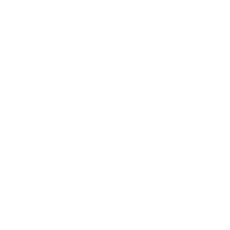

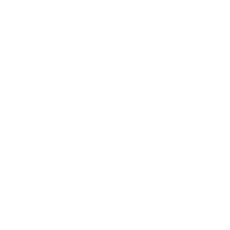

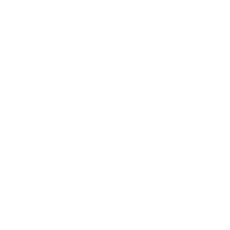

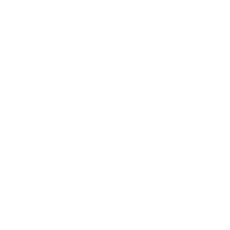

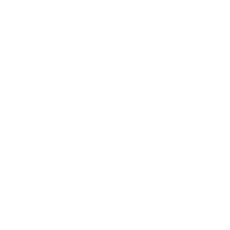

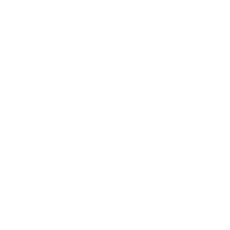

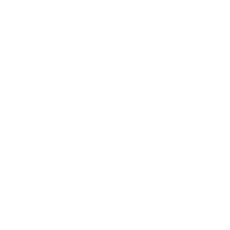

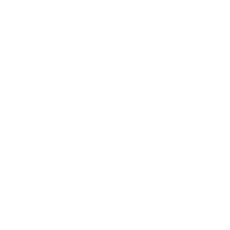

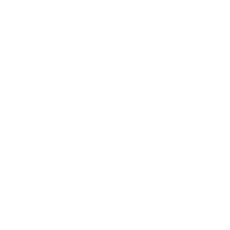

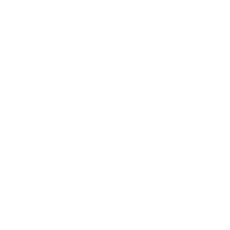

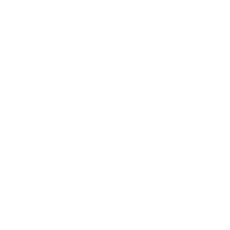

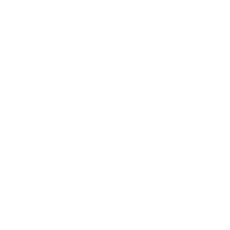

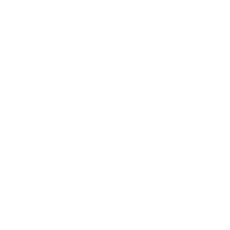

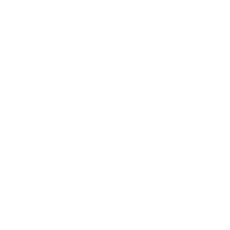

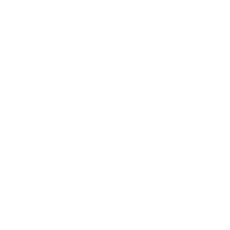

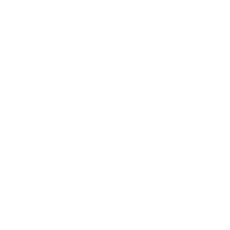

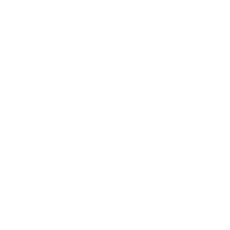

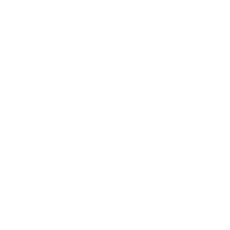

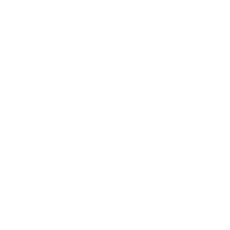

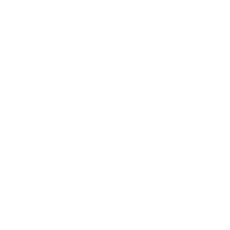

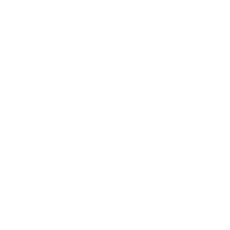

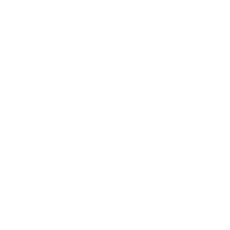

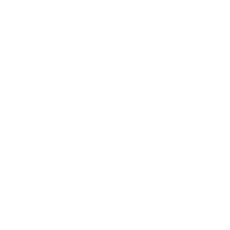

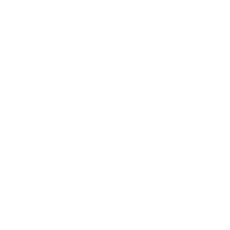

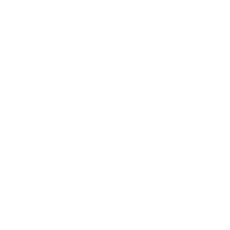

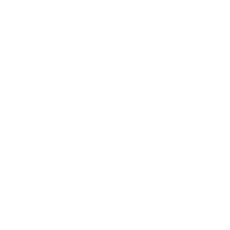

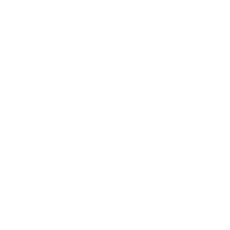

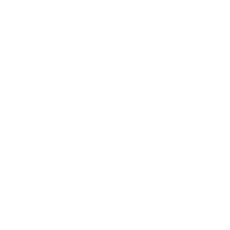

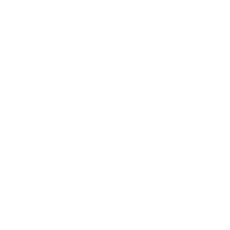

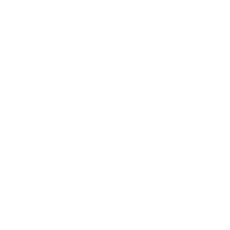

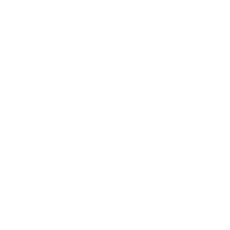

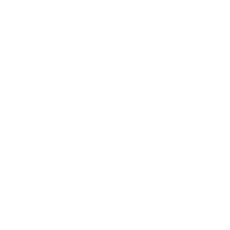

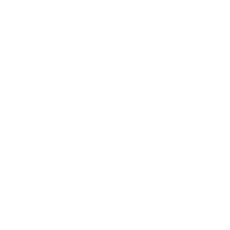

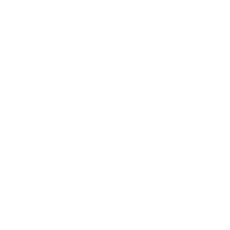

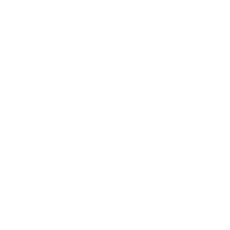

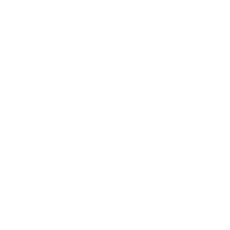

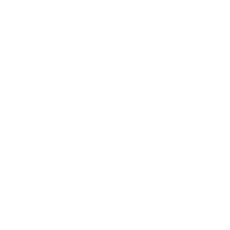

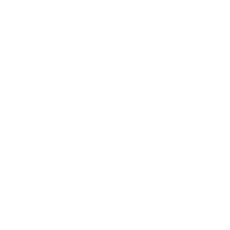

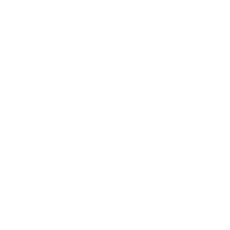

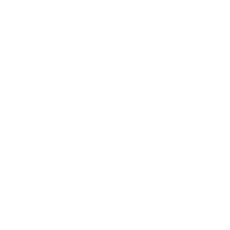

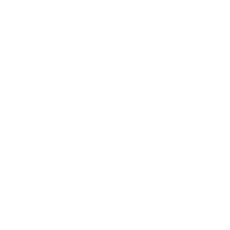

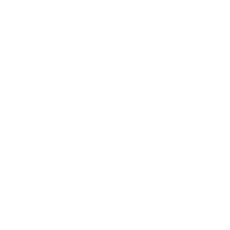

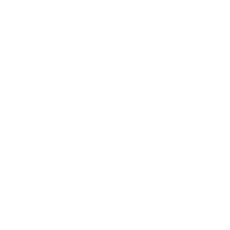

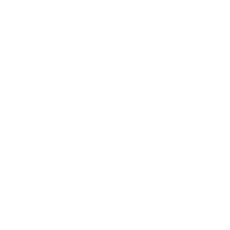

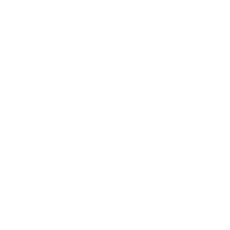

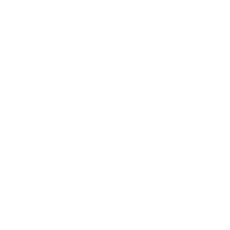

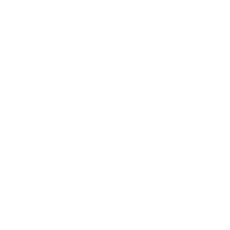

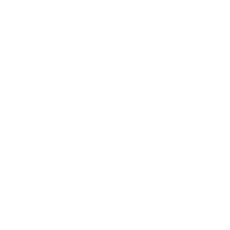

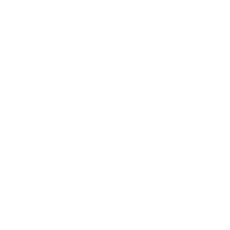

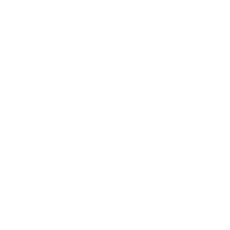

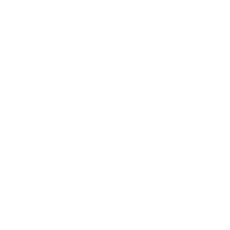

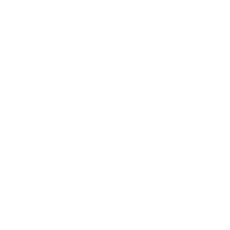

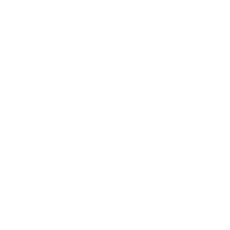

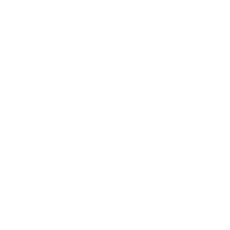

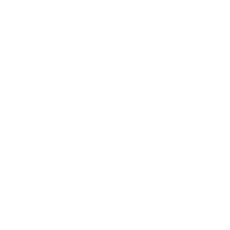

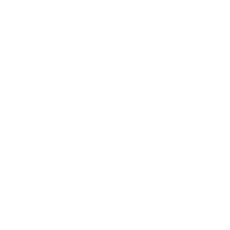

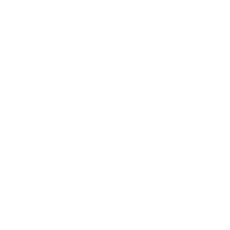

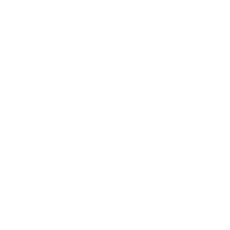

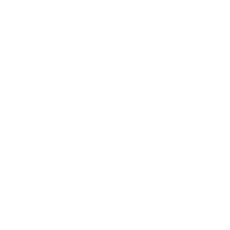

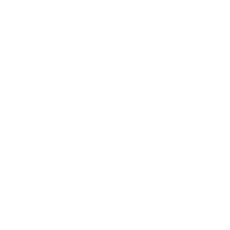

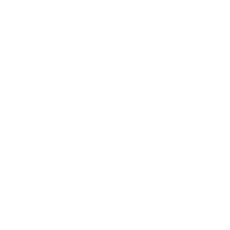

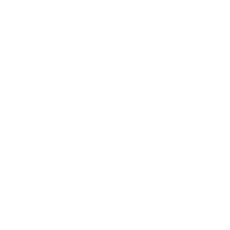

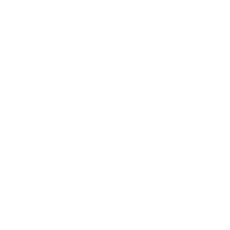

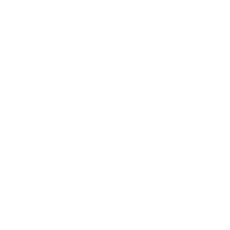

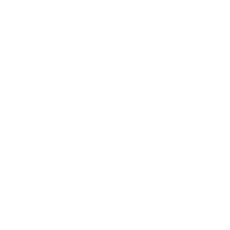

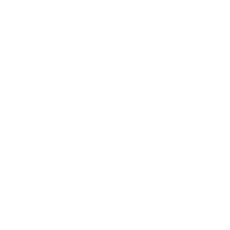

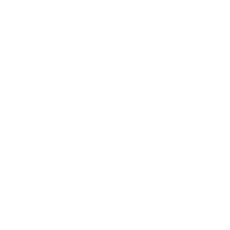

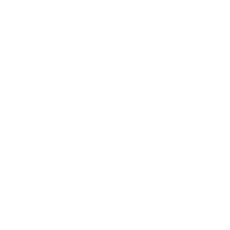

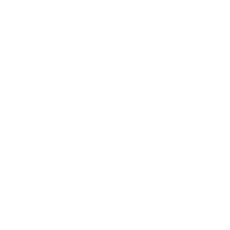

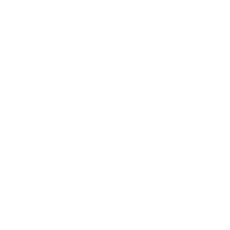

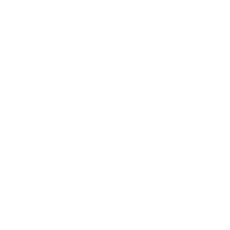

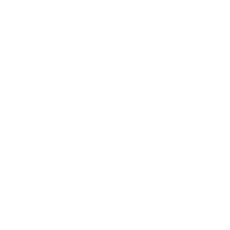

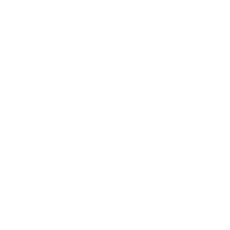

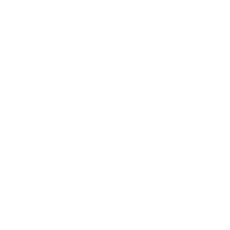

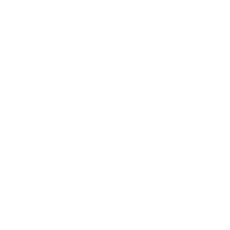

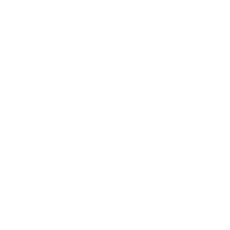

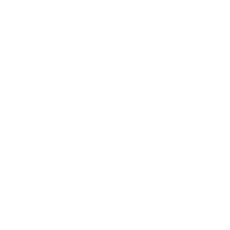

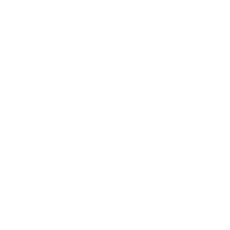

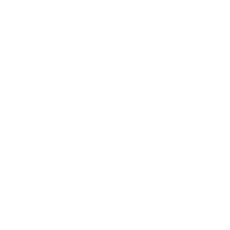

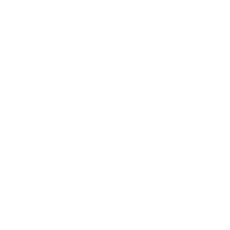

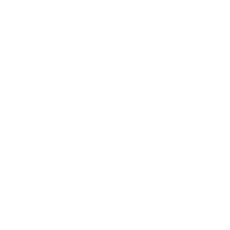

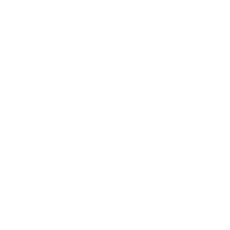

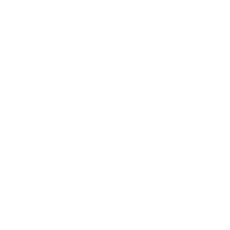

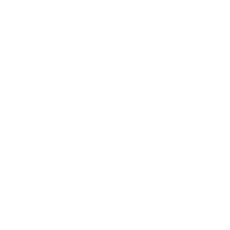

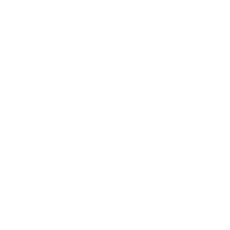

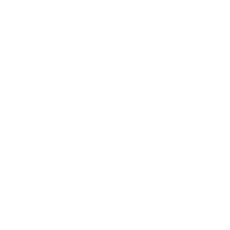

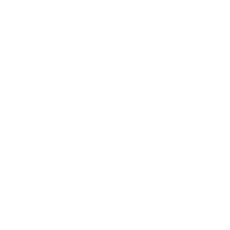

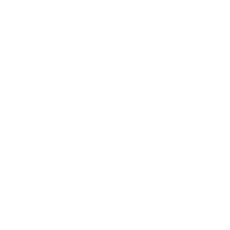

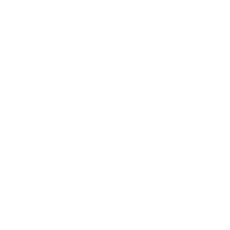

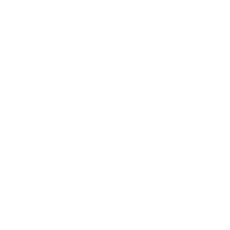

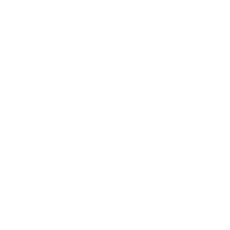

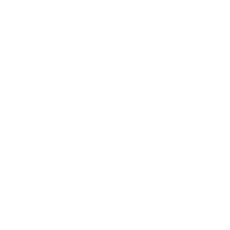

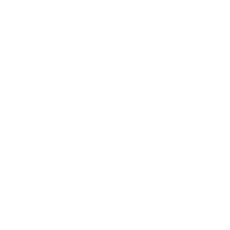

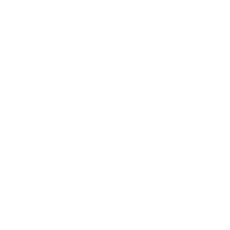

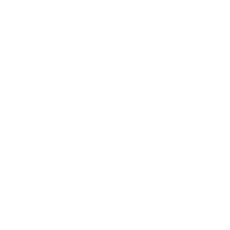

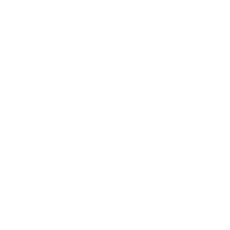

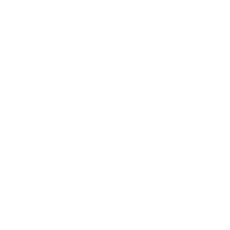

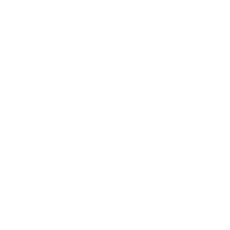

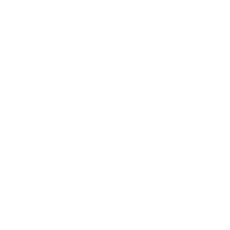

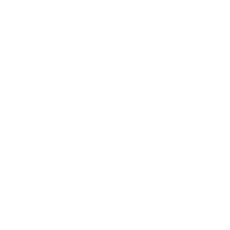

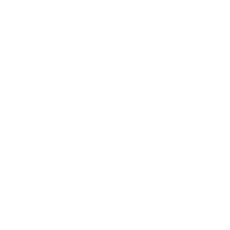

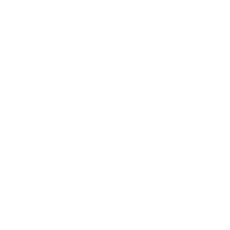

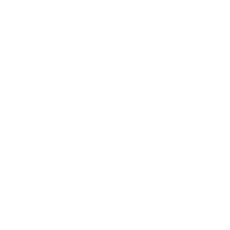

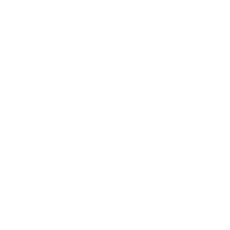

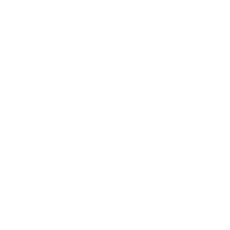

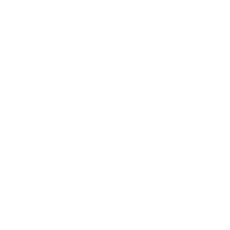

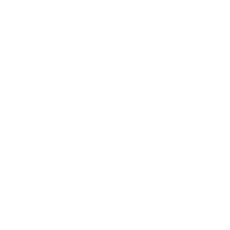

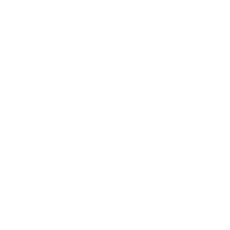

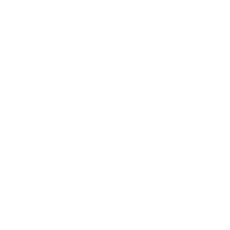

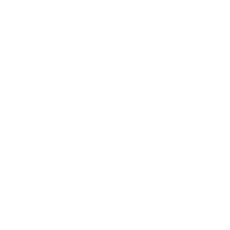

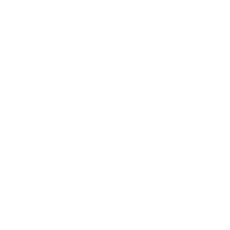

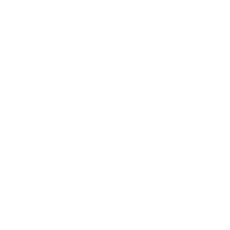

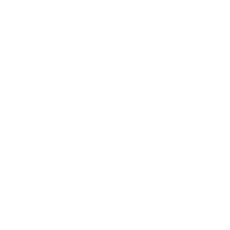

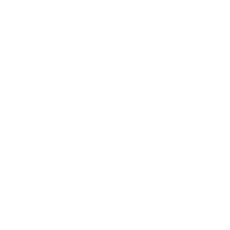

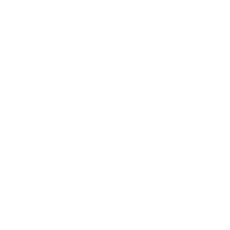

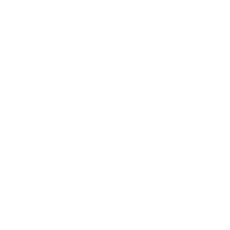

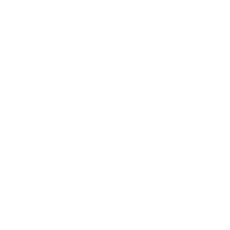

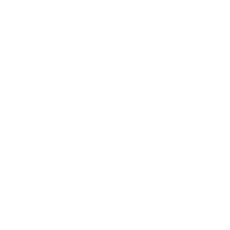

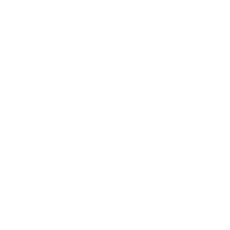

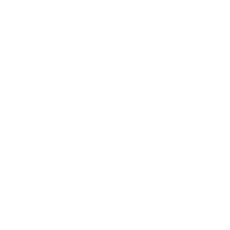

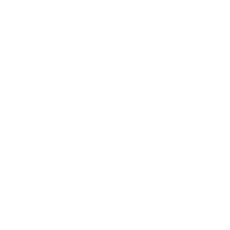

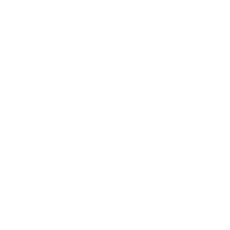

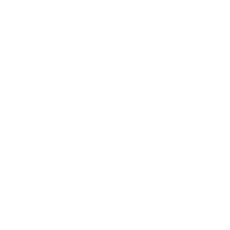

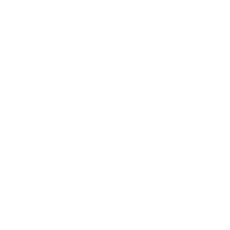

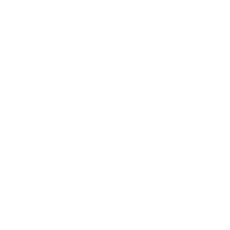

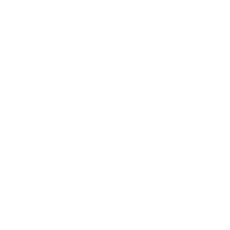

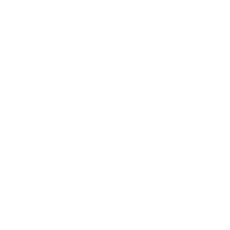

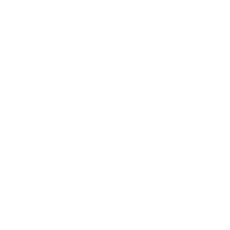

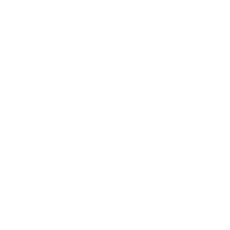

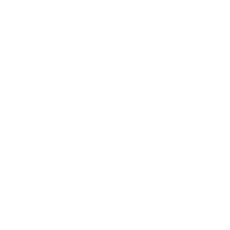

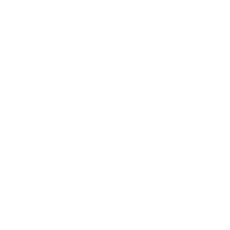

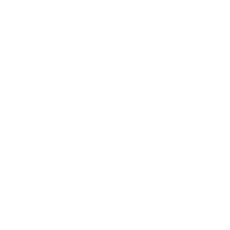

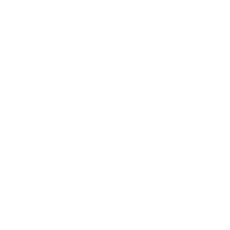

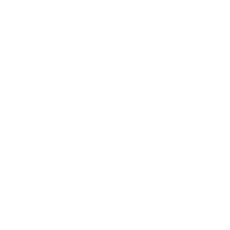

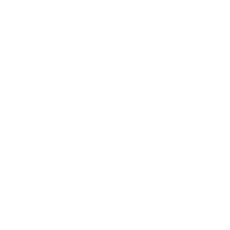

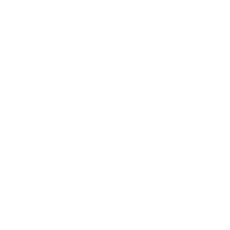

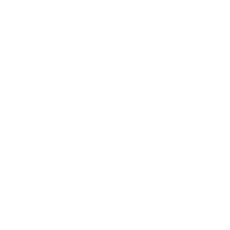

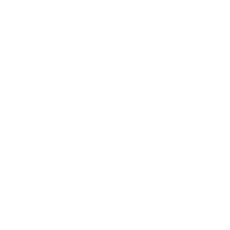

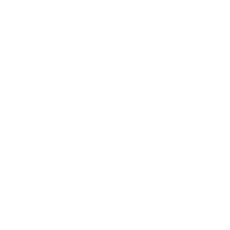

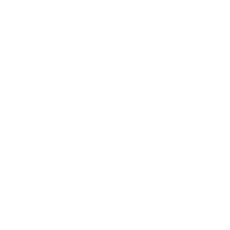

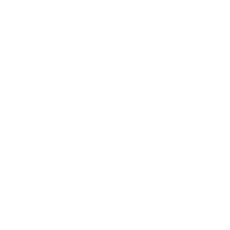

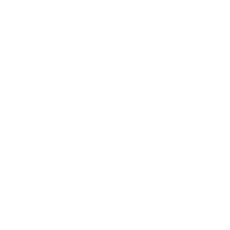

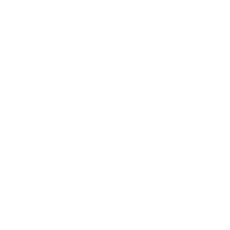

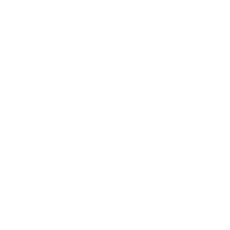

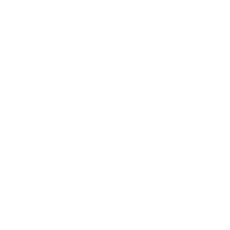

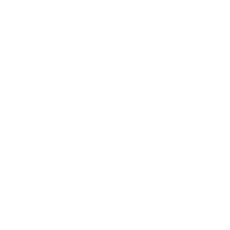

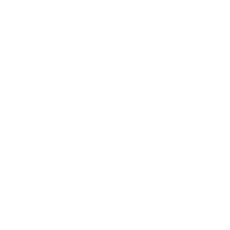

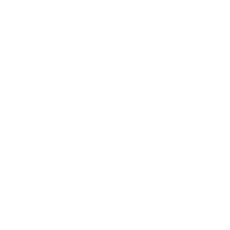

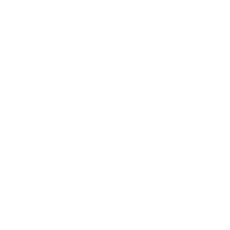

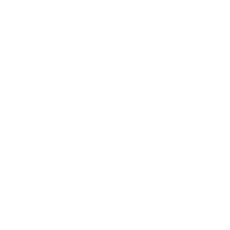

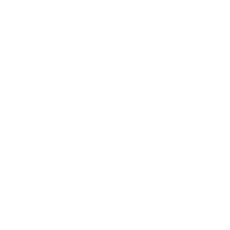

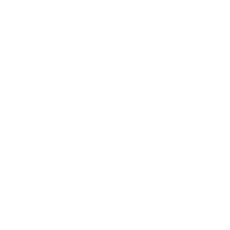

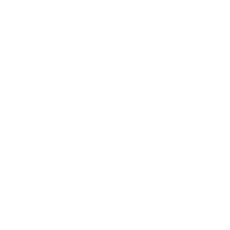

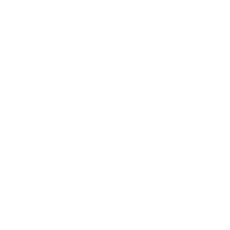

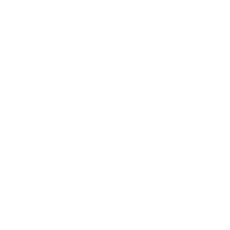

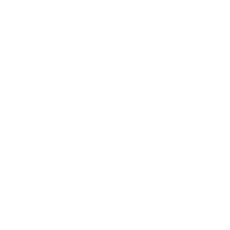

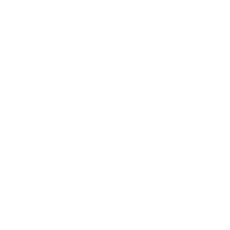

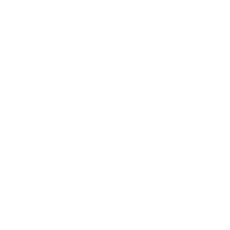

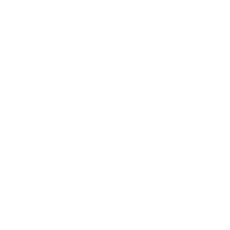

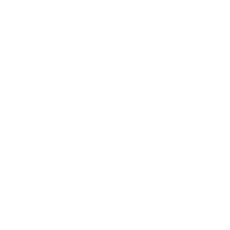

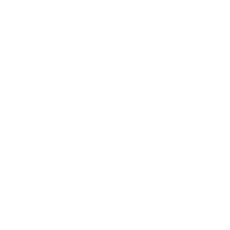

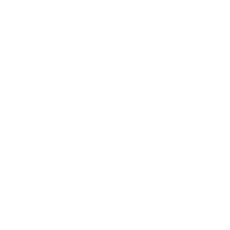

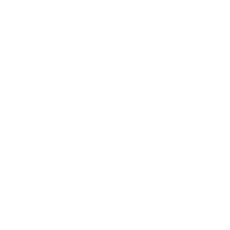

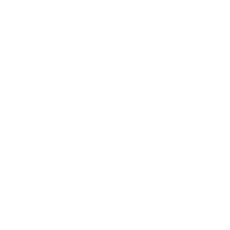

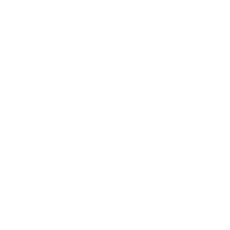

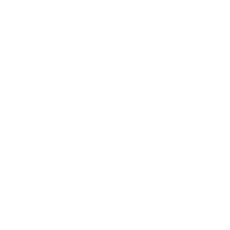

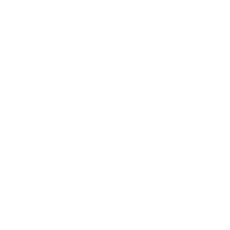

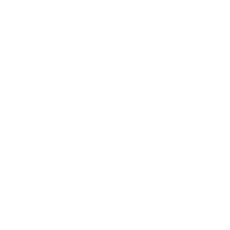

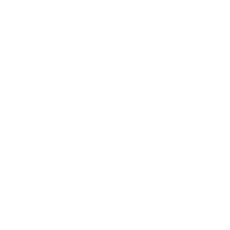

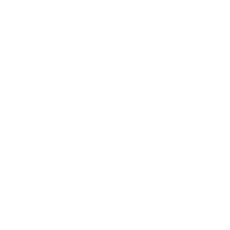

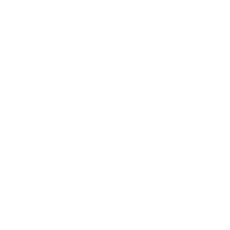

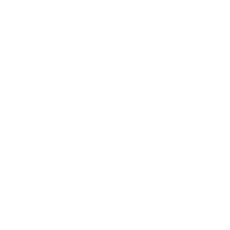

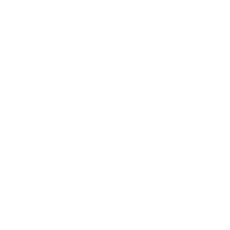

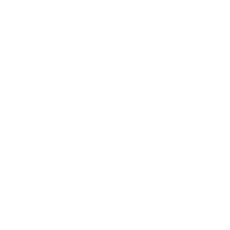

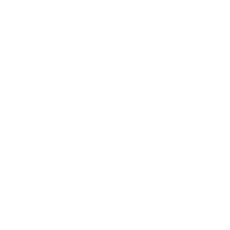

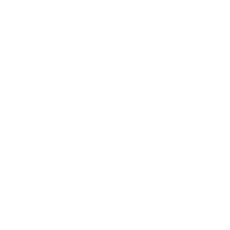

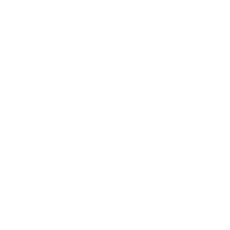

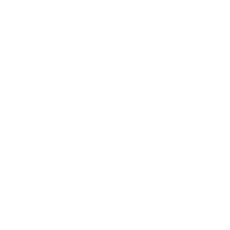

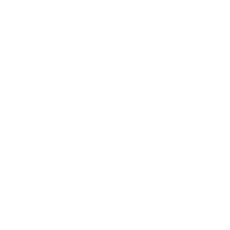

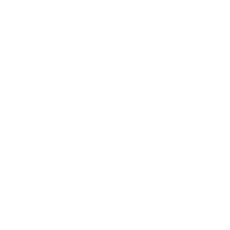

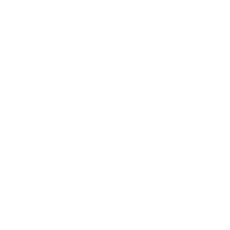

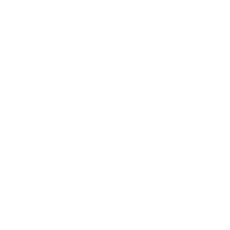

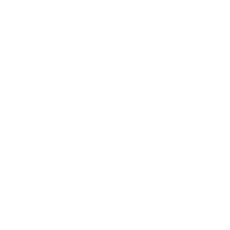

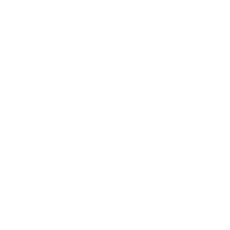

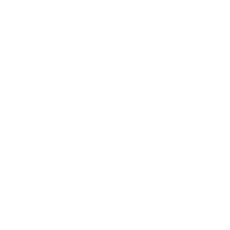

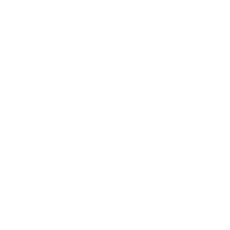

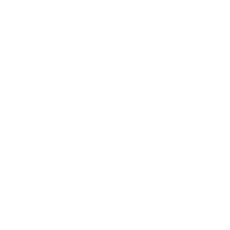

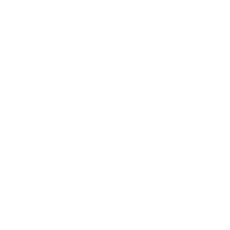

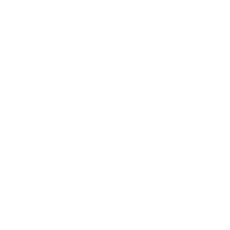

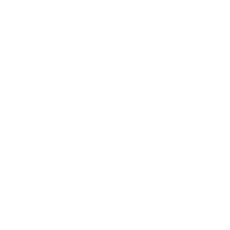

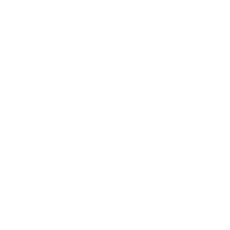

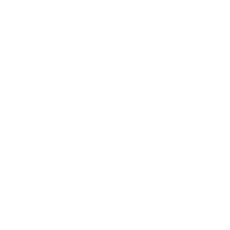

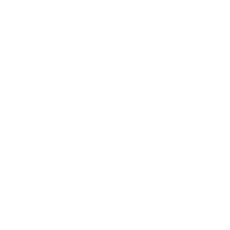

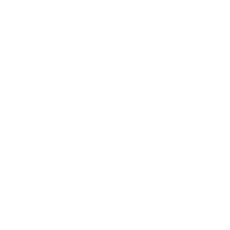

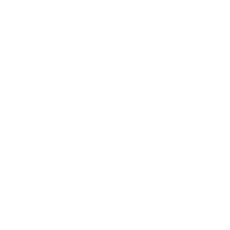

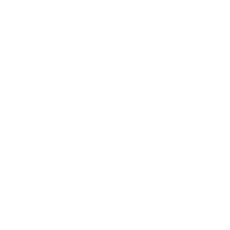

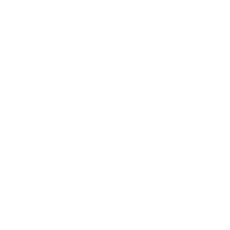

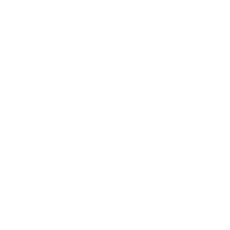

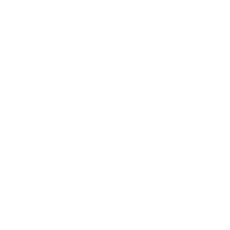

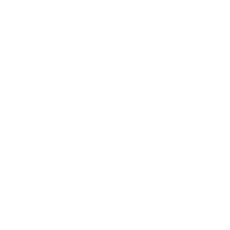

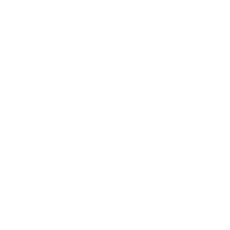

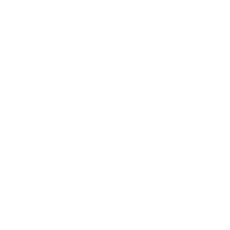

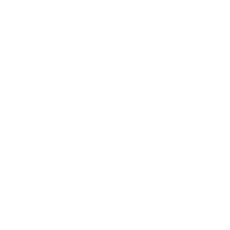

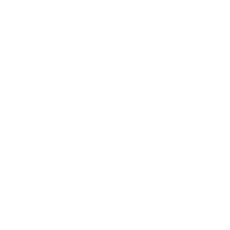

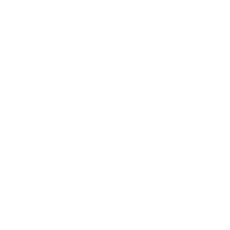

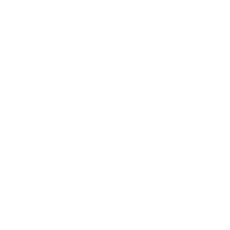

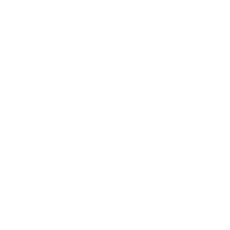

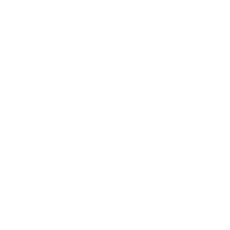

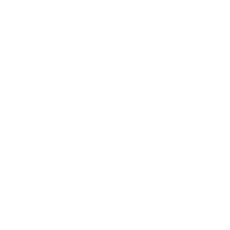

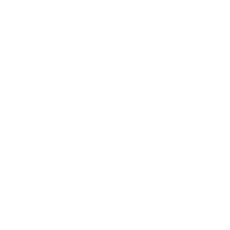

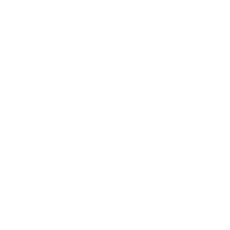

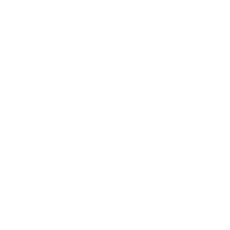

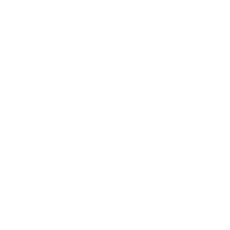

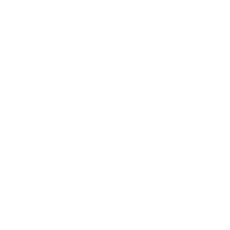

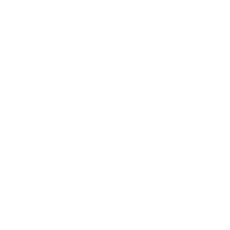

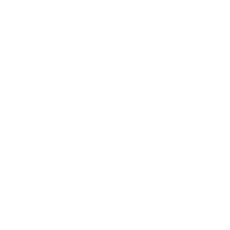

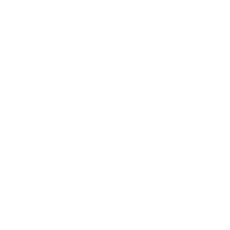

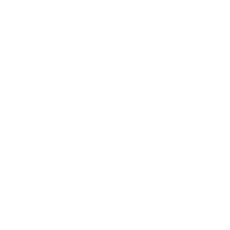

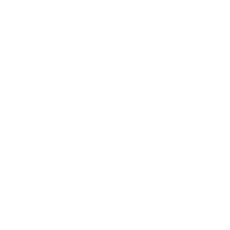

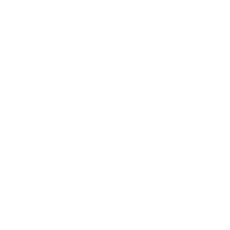

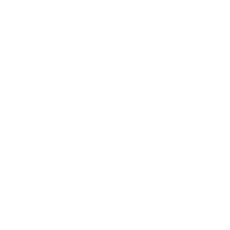

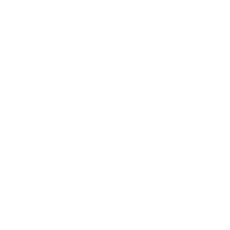

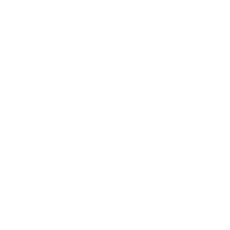

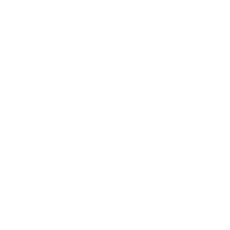

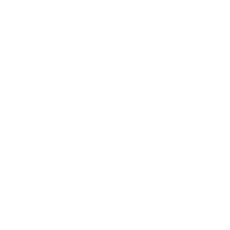

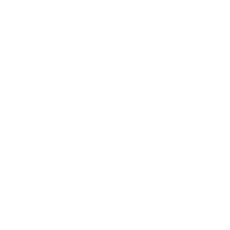

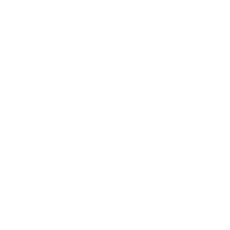

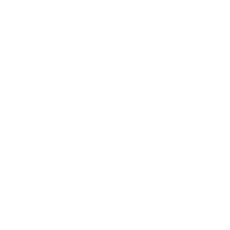

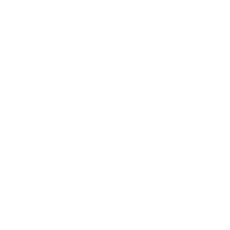

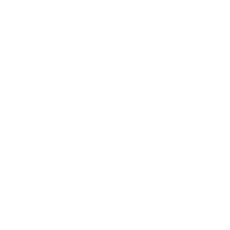

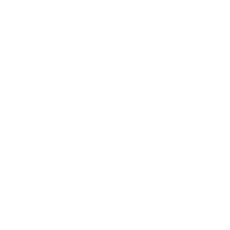

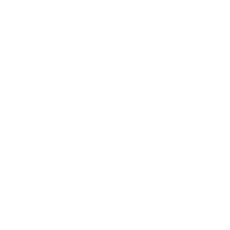

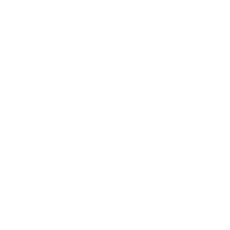

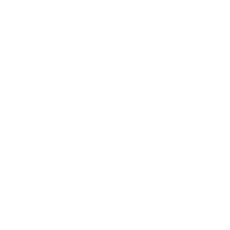

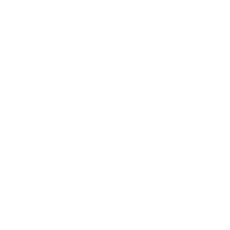

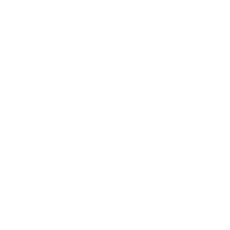

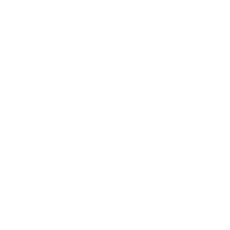

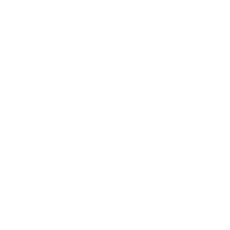

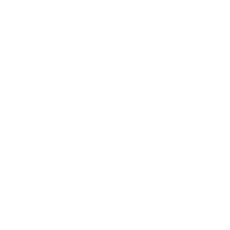

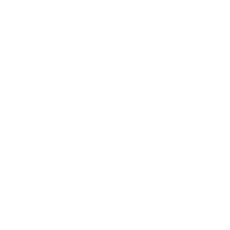

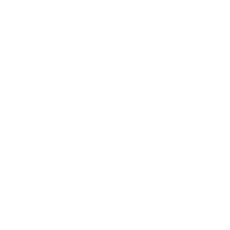

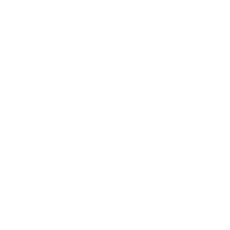

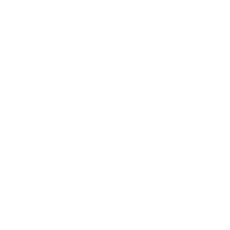

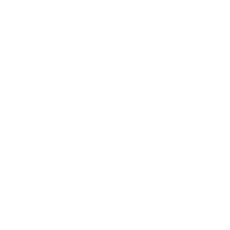

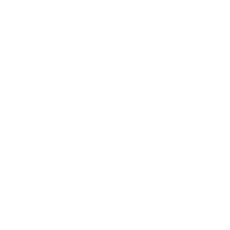

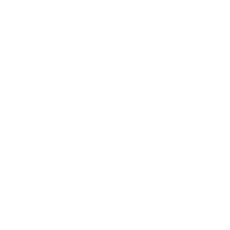

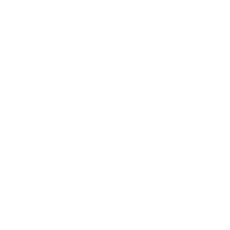

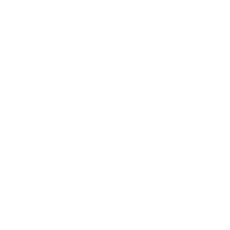

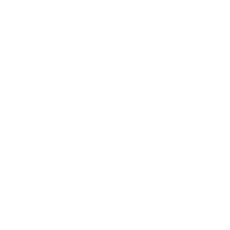

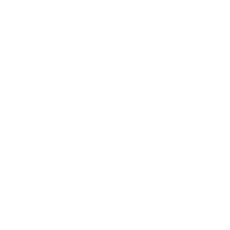

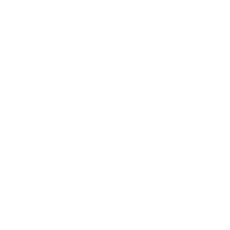

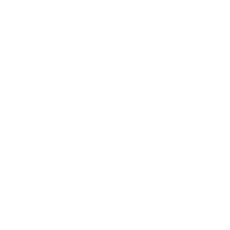

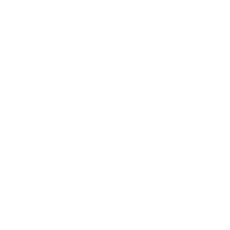

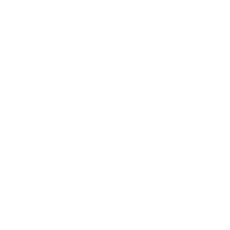

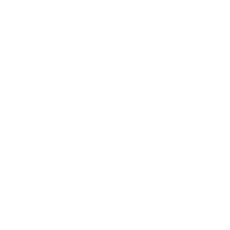

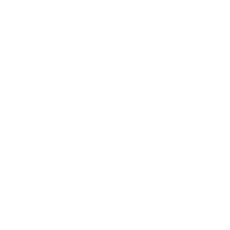

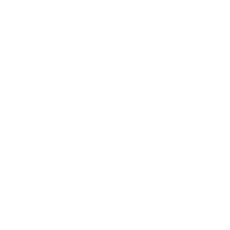

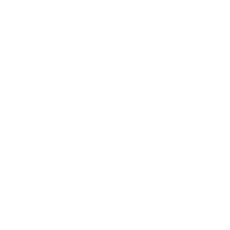

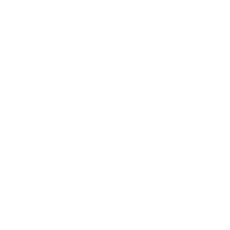

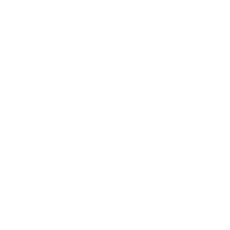

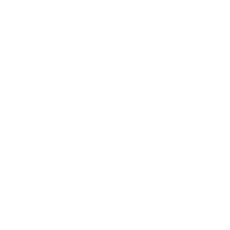

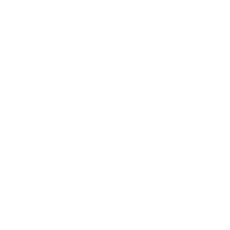

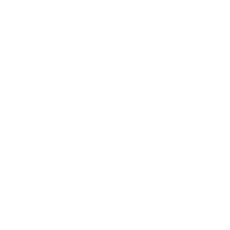

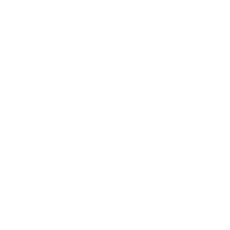

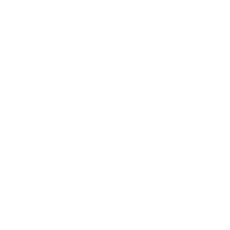

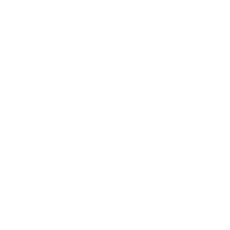

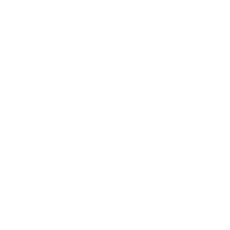

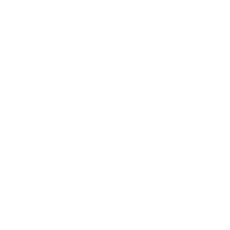

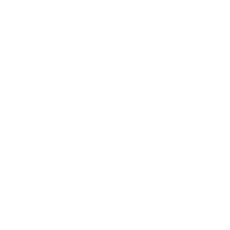

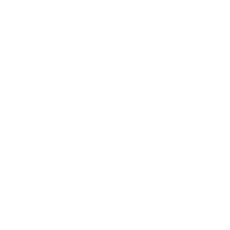

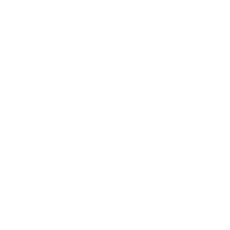

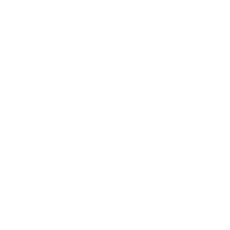

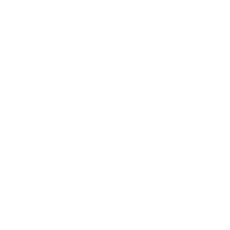

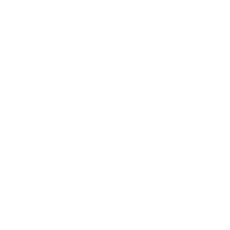

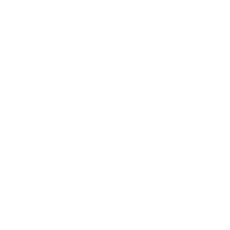

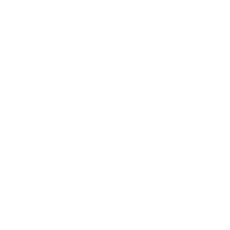

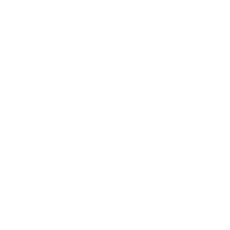

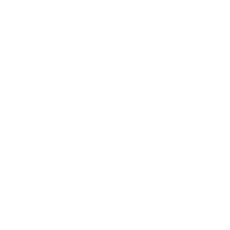

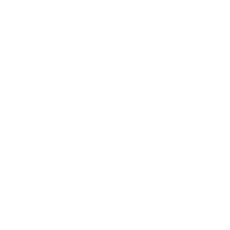

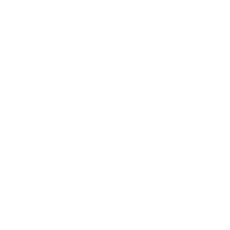

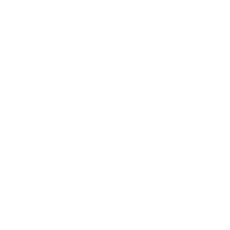

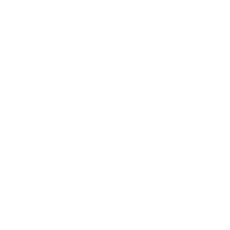

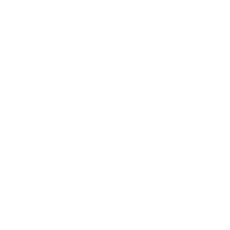

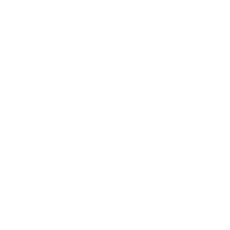

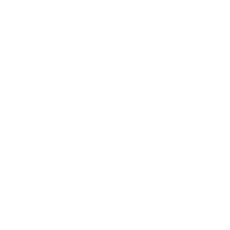

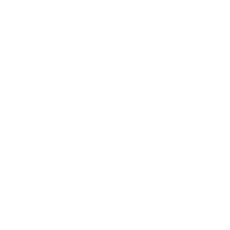

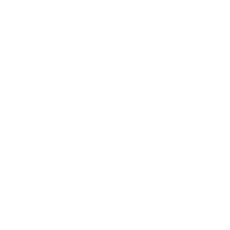

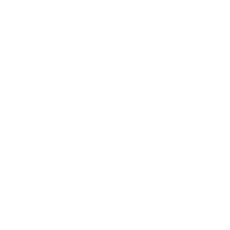

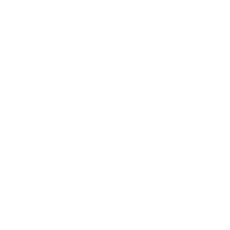

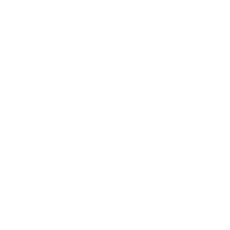

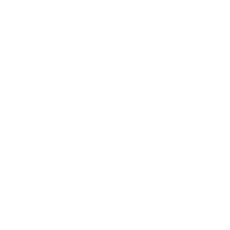

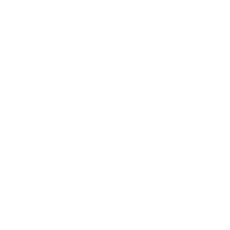

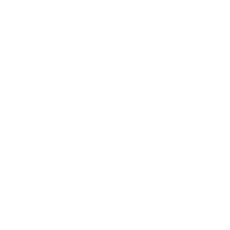

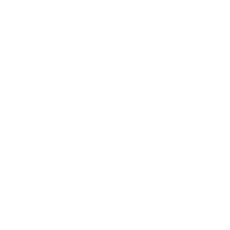

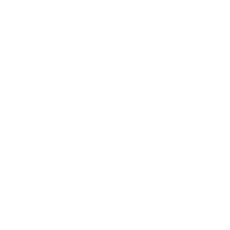

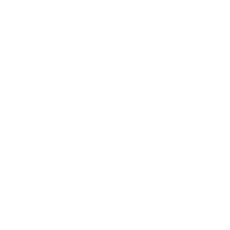

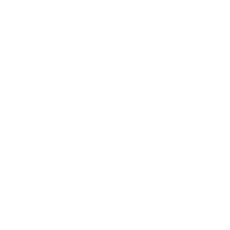

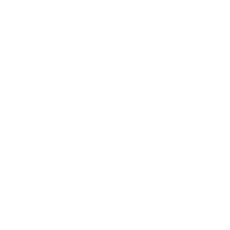

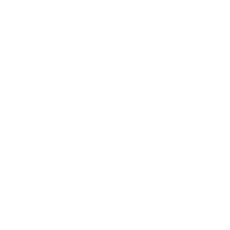

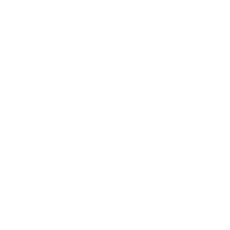

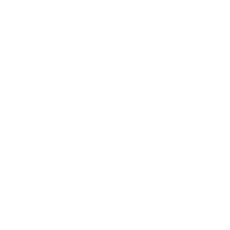

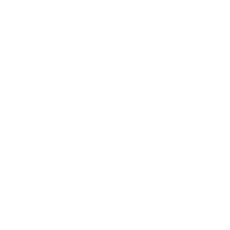

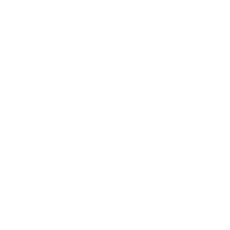

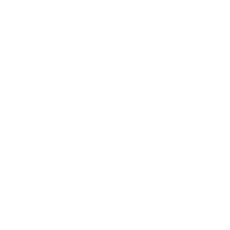

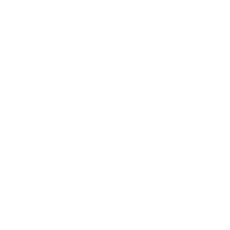

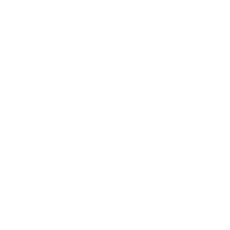

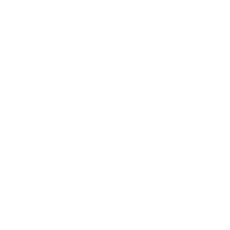

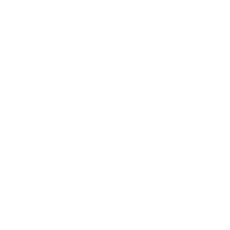

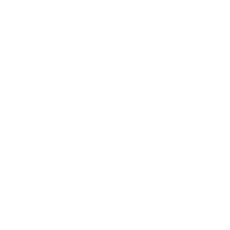

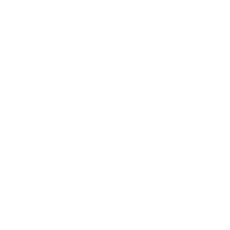

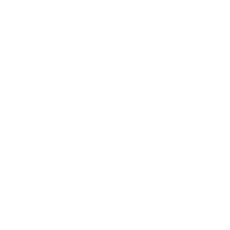

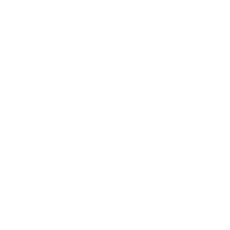

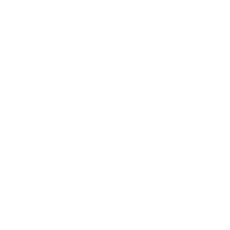

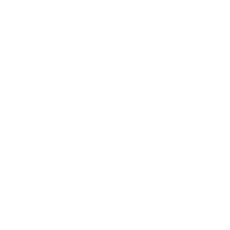

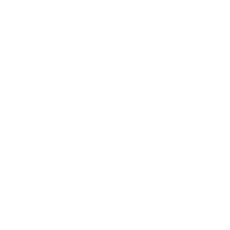

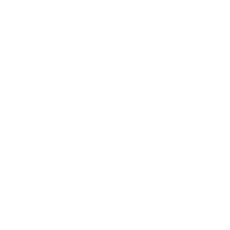

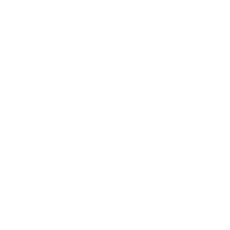

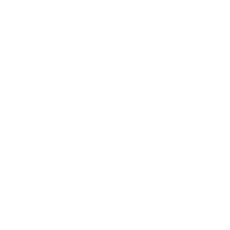

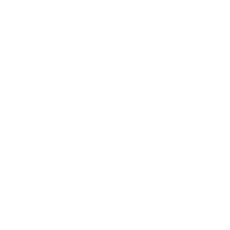

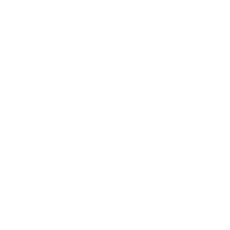

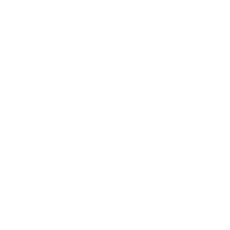

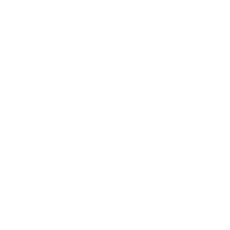

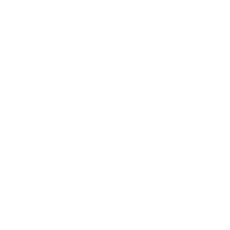

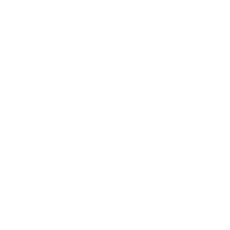

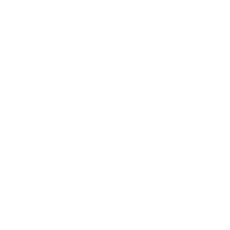

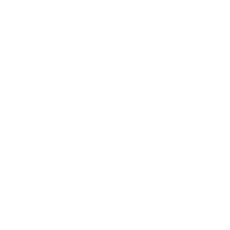

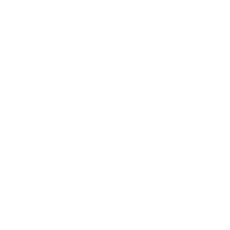

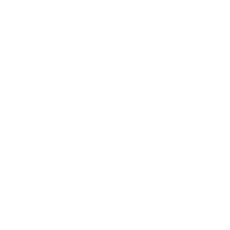

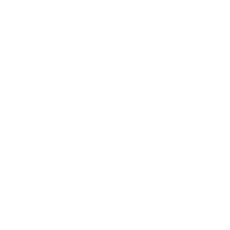

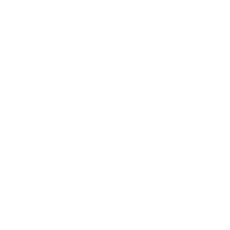

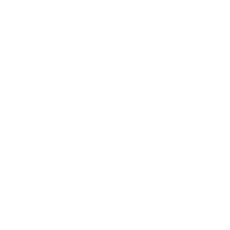

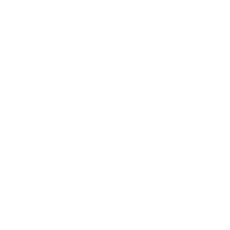

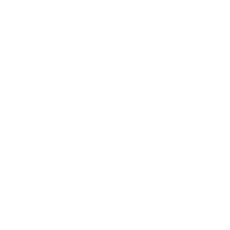

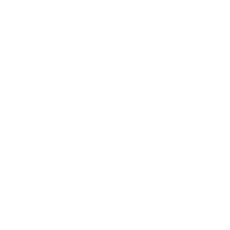

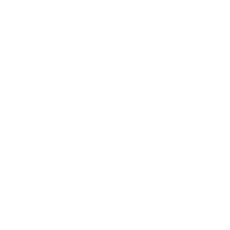

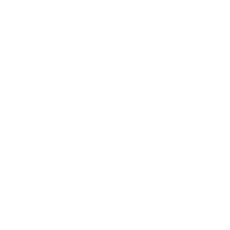

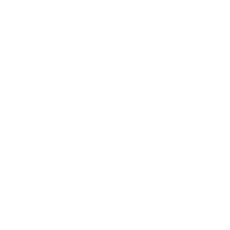

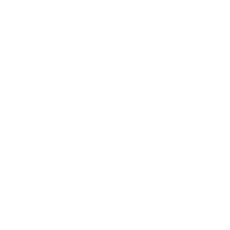

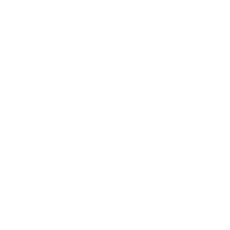

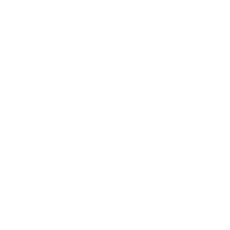

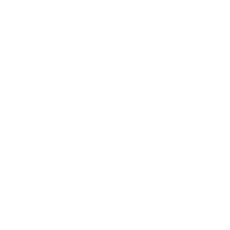

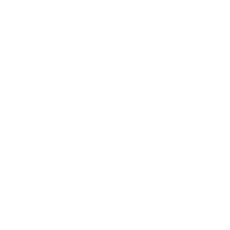

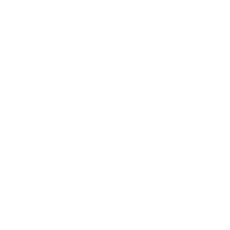

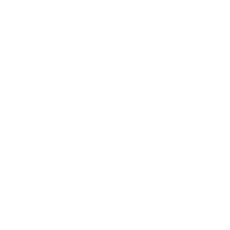

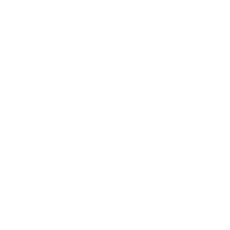

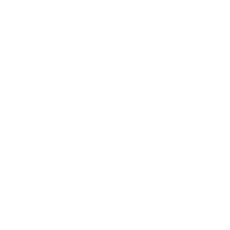

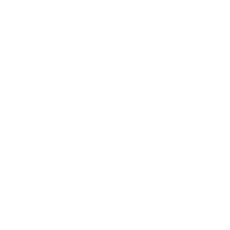

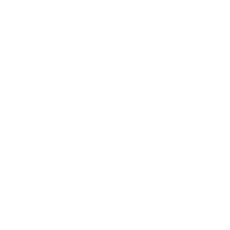

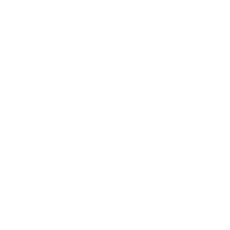

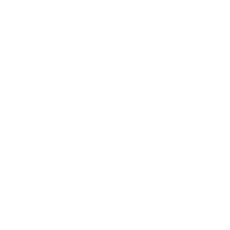

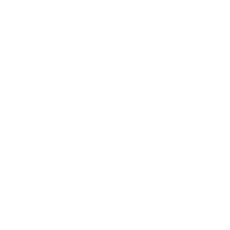

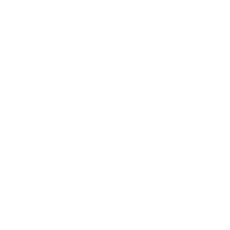

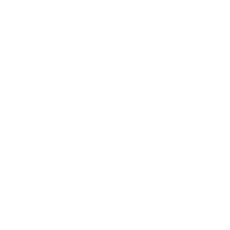

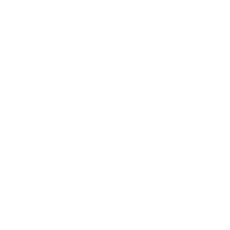

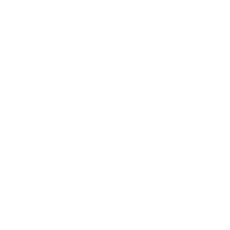

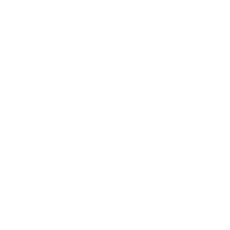

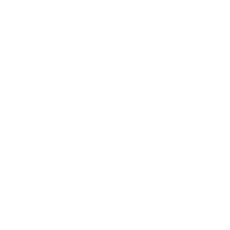

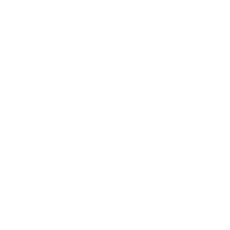

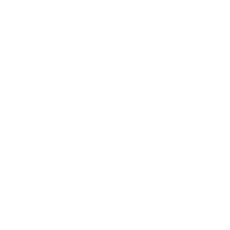

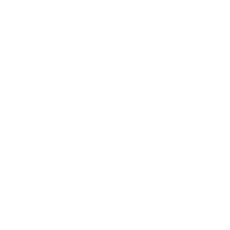

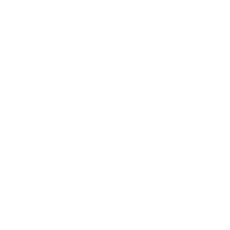

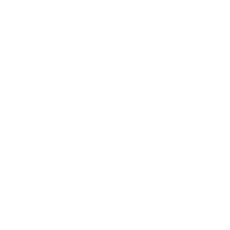

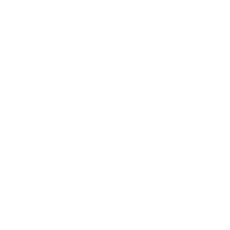

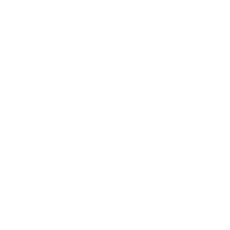

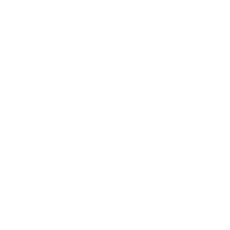

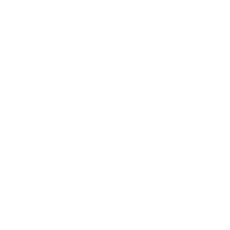

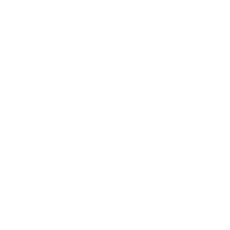

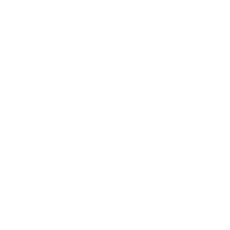

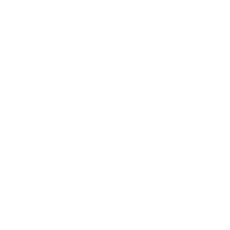

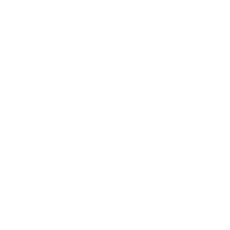

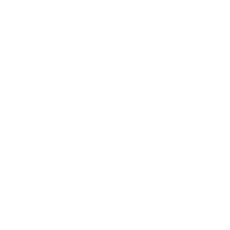

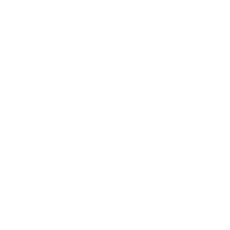

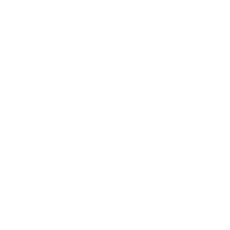

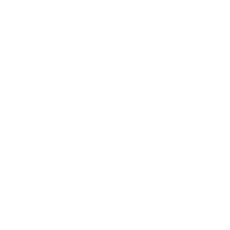

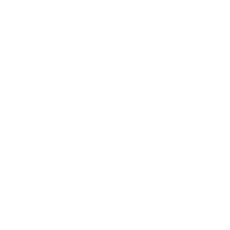

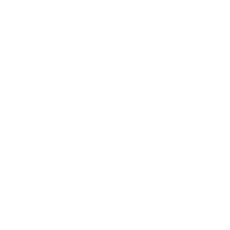

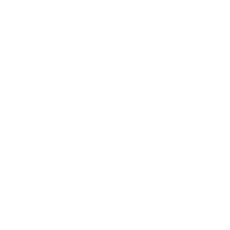

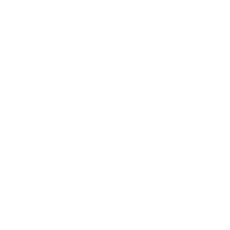

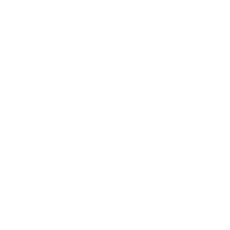

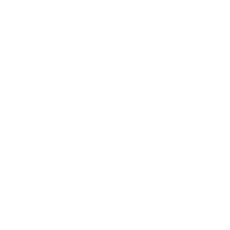

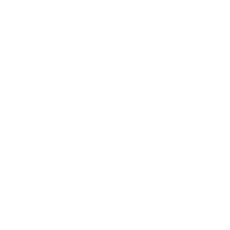

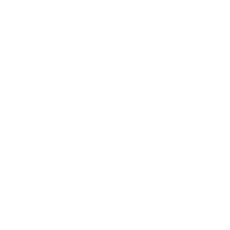

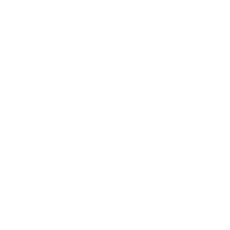

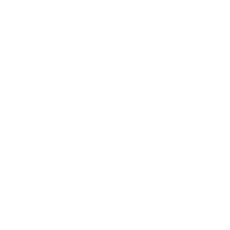

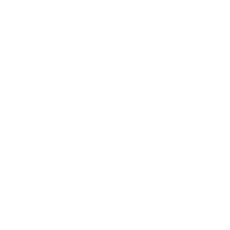

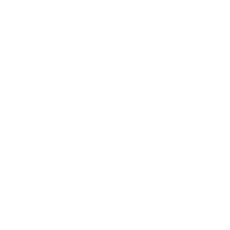

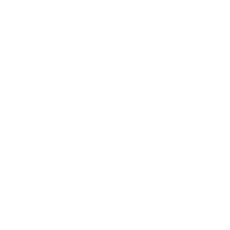

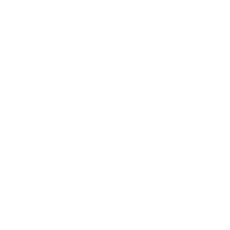

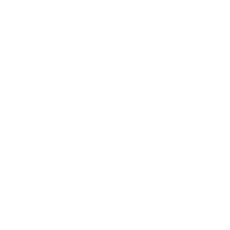

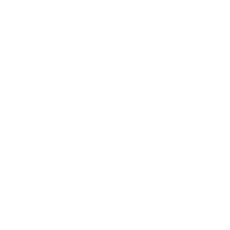

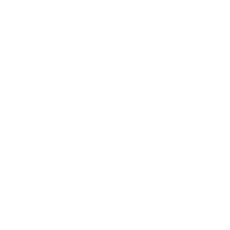

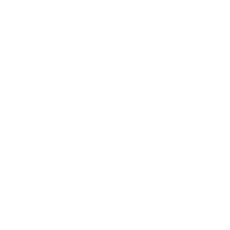

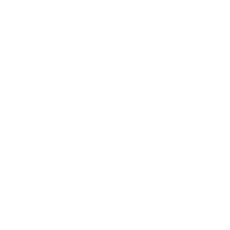

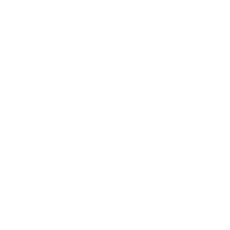

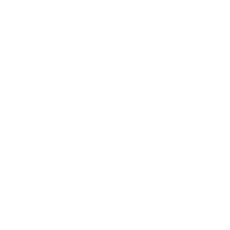

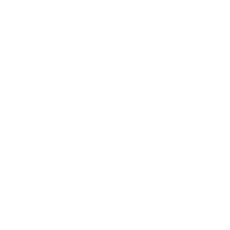

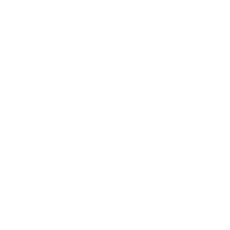

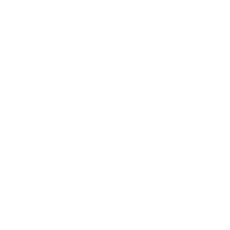

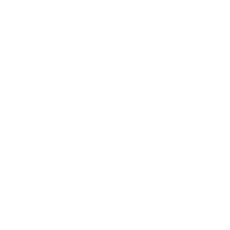

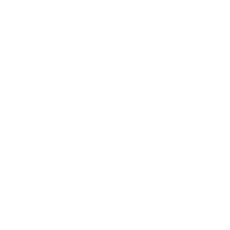

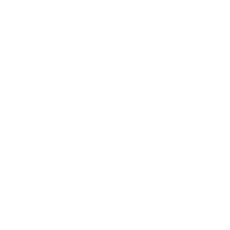

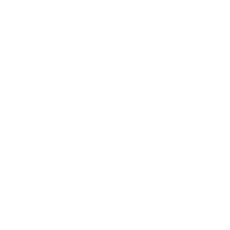

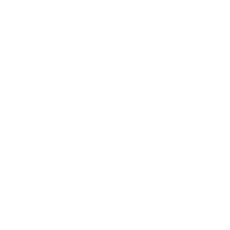

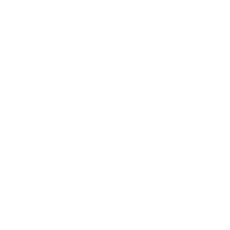

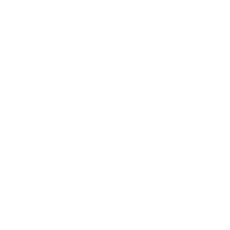

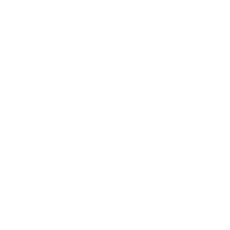

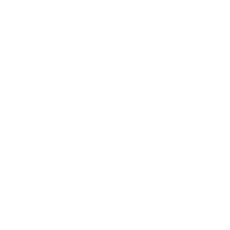

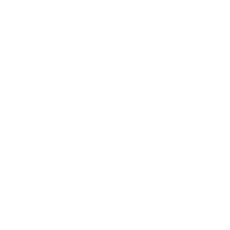

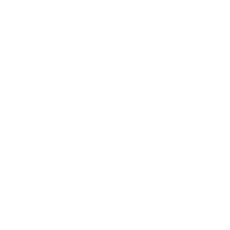

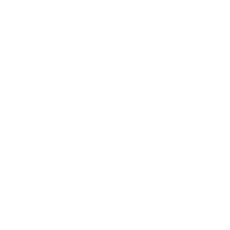

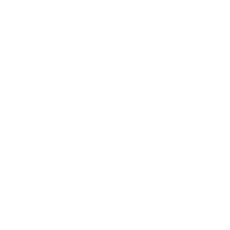

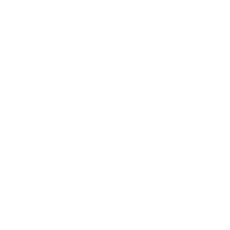

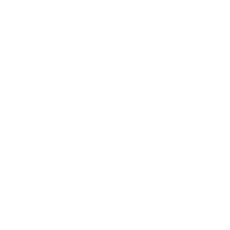

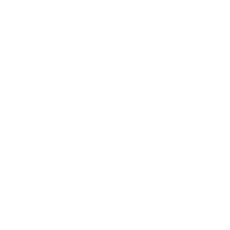

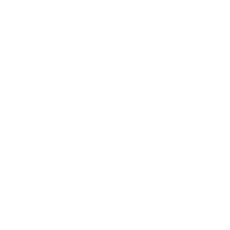

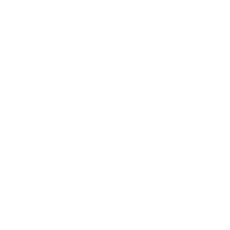

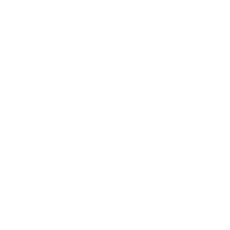

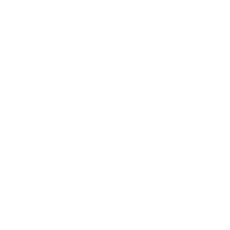

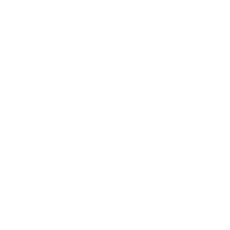

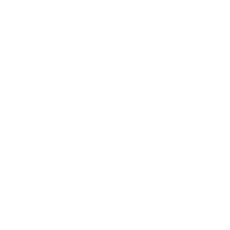

In [ ]:
#importing the spectrogram and saving it as png file
%cd /content/

IMG_DIR = '/content/spectrogram/'
import pylab
X, y =[], []
i=1
for path, emotion in zip(ravdess_df.Paths, ravdess_df.Emotions):
  data, sampling_rate = librosa.load(path)
  x =  librosa.stft(data)
  Xdb =  librosa.amplitude_to_db(abs(x))
  pylab.figure(figsize=(3,3))
  pylab.axis('off')
  pylab.axes([0., 0., 1., 1.], frameon=False, xticks=[], yticks=[]) # Remove the white edge
  pylab.savefig(IMG_DIR + str(i) +'.png', bbox_inches=None, pad_inches=0)
  i+=1

In [ ]:
i=0
X, y =[],[]
for path, emotion in zip(ravdess_df.Paths, ravdess_df.Emotions):
  X.append(str(i))
  y.append(emotion)
  i+=1

In [ ]:
%cd /content/
Features = pd.DataFrame(X)
Features['labels'] = y
Features.to_csv('features.csv', index=False)
Features.head(10)

/content


0    labels
0  0      fear
1  1  surprise
2  2   disgust
3  3     angry
4  4      fear
5  5      fear
6  6   disgust
7  7  surprise
8  8       sad
9  9      calm

In [ ]:
Features.columns

Index([0, 'labels'], dtype='object')

In [ ]:
Features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 1439
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       1440 non-null   object
 1   labels  1440 non-null   object
dtypes: object(2)
memory usage: 22.6+ KB


## DATA PREPARATION

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255)
train_generator = datagen.flow_from_dataframe(
    dataframe = Features,
    directory='/content/spectrogram',
    x_col =0,
    y_col ='labels',
    target_size=(128,256),
    class_mode = 'categorical',
    batch_size=16,
    subset='training'
)
validation_generator = datagen.flow_from_dataframe(
    dataframe = Features,
    directory='/content/spectrogram',
    x_col = 0,
    y_col ='labels',
    target_size=(128,256),
    class_mode = 'categorical',
    batch_size=16,
    subset='validation'
)

Found 0 validated image filenames belonging to 0 classes.
Found 0 validated image filenames belonging to 0 classes.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 1440 invalid image filename(s) in x_col="0". These filename(s) will be ignored.
  .format(n_invalid, x_col)


  ## MODEL BUILDING

In [ ]:
def build_model():

  input = Input((128,256,3))
  #channel 1
  conv1 = Conv2D(filters=128, kernel_size=(3,3), strides = (1,1), padding='same')(input)
  act1 = Activation('relu')(conv1)
  max1 = MaxPool2D(pool_size=(2,2))(act1)
  conv11 = conv1 = Conv2D(filters=256, kernel_size=(3,3), strides = (1,1), padding='same')(max1)
  act11 = Activation('relu')(conv11)
  max11 = MaxPool2D(pool_size=(2,2))(act11)
  flat1 = Flatten()(max11)

  #channel 2
  conv2 = Conv2D(filters=128, kernel_size=(5,5), strides = (1,1), padding='same')(input)
  act2 = Activation('relu')(conv2)
  max2 = MaxPool2D(pool_size=(2,2))(act2)
  conv22 = Conv2D(filters=256, kernel_size=(5,5), strides = (1,1), padding='same')(max2)
  act22 = Activation('relu')(conv22)
  max22 = MaxPool2D(pool_size=(2,2))(act22)
  flat2 = Flatten()(max22)

  #channel 3
  conv3 = Conv2D(filters=128, kernel_size=(3,3), strides = (1,1), padding='same')(input)
  act3 = Activation('relu')(conv3)
  max3 = MaxPool2D(pool_size=(2,2))(act3)
  conv33 = Conv2D(filters=256, kernel_size=(3,3), strides = (1,1), padding='same')(max3)
  act33 = Activation('relu')(conv33)
  max33 = MaxPool2D(pool_size=(2,2))(act33)
  flat3 = Flatten()(max33)

  #channel 4
  conv4 = Conv2D(filters=128, kernel_size=(5,5), strides = (1,1), padding='same')(input)
  act4 = Activation('relu')(conv4)
  max4 = MaxPool2D(pool_size=(2,2))(act4)
  conv44 = Conv2D(filters=256, kernel_size=(5,5), strides = (1,1), padding='same')(max4)
  act44 = Activation('relu')(conv44)
  max44 = MaxPool2D(pool_size=(2,2))(act44)
  flat4 = Flatten()(max44)

  merged = Concatenate(axis=-1)([flat1,flat2,flat3,flat4])
  #merge = Flatten()(merged)

  dense1 = Dense(32)(merged)
  bn1 = BatchNormalization()(dense1)
  act_dense1 = Activation('relu')(bn1)
  drop1 = Dropout(0.7)(act_dense1)
  dense2 = Dense(16, activation='relu')(drop1)
  bn2 = BatchNormalization()(dense2)
  act_dense2 = Activation('relu')(bn2)
  output = Dense(8,activation='softmax')(act_dense2)

  model = Model(inputs=[input], outputs=output)
  model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
  return model

In [ ]:
model = build_model()

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 256, 128 3584        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 128, 256, 128 9728        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 128, 256, 128 3584        input_1[0][0]                    
____________________________________________________________________________________________

In [ ]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=1, patience=2, min_lr = 0.0000001)
history = model.fit_generator(generator = train_generator, steps_per_epoch=32, validation_data=validation_generator, validation_steps=32, epochs=5, verbose=1)

Epoch 1/5


In [ ]:
!mkdir weights

In [ ]:
model.save('/content/weights')

We can take an input from the user.

In [ ]:
test = files.upload()

In [ ]:
!mkdir test

In [ ]:
TEST_DIR = '/content/test'

In [ ]:
import cv2
x =  librosa.stft(data)
Xdb =  librosa.amplitude_to_db(abs(x))
pylab.figure(figsize=(3,3))
pylab.axis('off')
pylab.axes([0., 0., 1., 1.], frameon=False, xticks=[], yticks=[]) # Remove the white edge
librosa.display.specshow(Xdb, sr= sampling_rate)
pylab.savefig(TEST_DIR + 'test' +'.png', bbox_inches=None, pad_inches=0)
image = cv2.imread('/content/test/test.png')
predict = model.predict_classes(image)

In [ ]:
print(classification_report(y_test,y_pred))